In [1]:
##### MODELING LIBRARIES #####
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.random import set_seed
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from patsy import dmatrices, dmatrix

##### FORMATTING AND GRAPHING LIBRARIES #####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

##### TIMING AND UTILITY LIBRARIES #####
from datetime import datetime
import timeit
from dateutil.relativedelta import relativedelta 
import random

In [2]:
# MAPE function taken from:
# https://www.statology.org/mape-python/
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [3]:
##### IMPORT PREPARED DATA #####
print('Reading pre-built dataset...')
df_load = pd.read_csv('../PJM_Weekly_Model/sample_base_data.csv', index_col = 0, parse_dates = [0])

# Drop all lag columns for use in RNN
lag_sq_cols = [column for column in df_load.columns if 'Lag' in column or 'Sq' in column]
df_load = df_load.drop(columns = lag_sq_cols)

# Drop null rows - should only be losing daylight savings in March
dropped = df_load.shape[0] - df_load.dropna().shape[0]
print('Dropping %s null values...'%(dropped))
df_load = df_load.dropna()

# Limit dataset to 13 months of data (18240 hours)
df_load.head(18240)

# Convert date, time, holiday columns to categorical variables
for col in ['Month','WeekDay','Day','Hour']:
    df_load[col] = df_load[col].astype('category')

Reading pre-built dataset...
Dropping 1 null values...


In [4]:
##### FINAL DATA PREPARATION #####
print("\nDefining testing and training set...") 

# Use Patsy to create the one-hot encoded dummy variables with interactions 
y, X =  dmatrices('value~Light+WWP+THI+Month+Day+WeekDay+Hour+Holiday',df_load,return_type='dataframe')

# Split data into training and testing data sets with two-year training sample (8760 h/yr * 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 17520 / X.shape[0], shuffle = False)

# Standardize both datasets - create fit to use on backcast dataset
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)


Defining testing and training set...


In [5]:
##### GRID SEARCH #####
print('/nBeginning grid search...')

# Define individual grid search parameters
# Parameters derived from LoadModel_RNN_GridSearchAnalysis file
param_dict = {'seq_length':[12, 24],
              'seq_batch_size':[256],
              'layer_one_neurons':[128],
              'layer_two_neurons':[32],
              'layer_three_neurons':[16],
              'layer_four_neurons':[16],
              'dropout_rate':[0, 0.2, 0.4],
              'stop_patience':[3, 4],
              'learning_rate':[0.001, 0.01],
              'epochs':[40,80]
             }

# Create array of interactions between parameters
# Itertools approach taken from:
# https://stackoverflow.com/questions/798854/all-combinations-of-a-list-of-lists
df_params = pd.DataFrame(list(itertools.product(*param_dict.values())), columns = param_dict.keys())

# Add columns for tracking model performance
df_params['mse_train'],df_params['mse_test'],df_params['mape_train'],df_params['mape_test'] = [np.nan,np.nan,np.nan,np.nan]

/nBeginning grid search...



Building and training models...
seq_length              12.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            3.000
learning_rate            0.001
epochs                  40.000
Name: 0, dtype: float64
Epoch 1/40
69/69 [==============================] - 3s 43ms/step - loss: 4601036800.0000 - mean_absolute_percentage_error: 64.6384 - val_loss: 1029958784.0000 - val_mean_absolute_percentage_error: 30.4097
Epoch 2/40
69/69 [==============================] - 2s 35ms/step - loss: 553193984.0000 - mean_absolute_percentage_error: 19.8202 - val_loss: 386120096.0000 - val_mean_absolute_percentage_error: 18.6369
Epoch 3/40
69/69 [==============================] - 2s 35ms/step - loss: 221099536.0000 - mean_absolute_percentage_error: 13.2129 - val_loss: 180930336.0000 - val_mean_absolute_percentage_error: 11.1240
Epoch 4/40
69/69 [====

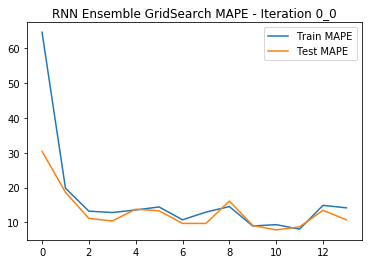

Epoch 1/40
69/69 [==============================] - 3s 39ms/step - loss: 5472687616.0000 - mean_absolute_percentage_error: 75.0364 - val_loss: 3112695552.0000 - val_mean_absolute_percentage_error: 58.5661
Epoch 2/40
69/69 [==============================] - 2s 35ms/step - loss: 609742272.0000 - mean_absolute_percentage_error: 20.2507 - val_loss: 191463616.0000 - val_mean_absolute_percentage_error: 11.9942
Epoch 3/40
69/69 [==============================] - 2s 35ms/step - loss: 176556736.0000 - mean_absolute_percentage_error: 11.5243 - val_loss: 191068560.0000 - val_mean_absolute_percentage_error: 12.8669
Epoch 4/40
69/69 [==============================] - 2s 35ms/step - loss: 272625056.0000 - mean_absolute_percentage_error: 14.3392 - val_loss: 141307664.0000 - val_mean_absolute_percentage_error: 10.3278
Epoch 5/40
69/69 [==============================] - 2s 35ms/step - loss: 144389600.0000 - mean_absolute_percentage_error: 10.5058 - val_loss: 130047632.0000 - val_mean_absolute_percentag

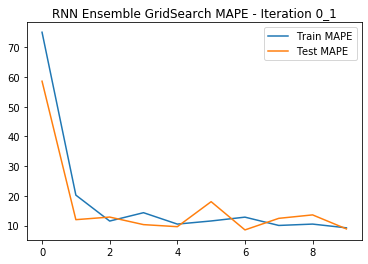

Epoch 1/40
69/69 [==============================] - 3s 42ms/step - loss: 5170212352.0000 - mean_absolute_percentage_error: 71.1051 - val_loss: 620648256.0000 - val_mean_absolute_percentage_error: 22.2837
Epoch 2/40
69/69 [==============================] - 2s 35ms/step - loss: 464808160.0000 - mean_absolute_percentage_error: 18.7799 - val_loss: 183626320.0000 - val_mean_absolute_percentage_error: 11.9692
Epoch 3/40
69/69 [==============================] - 2s 35ms/step - loss: 248254272.0000 - mean_absolute_percentage_error: 13.8894 - val_loss: 224367088.0000 - val_mean_absolute_percentage_error: 14.0739
Epoch 4/40
69/69 [==============================] - 2s 35ms/step - loss: 232741280.0000 - mean_absolute_percentage_error: 13.2134 - val_loss: 274784672.0000 - val_mean_absolute_percentage_error: 15.7266
Epoch 5/40
69/69 [==============================] - 2s 35ms/step - loss: 153631136.0000 - mean_absolute_percentage_error: 10.6981 - val_loss: 168835392.0000 - val_mean_absolute_percentage

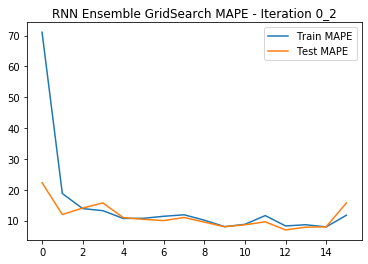

Epoch 1/40
69/69 [==============================] - 3s 39ms/step - loss: 5321549824.0000 - mean_absolute_percentage_error: 71.3523 - val_loss: 666564352.0000 - val_mean_absolute_percentage_error: 22.9674
Epoch 2/40
69/69 [==============================] - 2s 34ms/step - loss: 567732672.0000 - mean_absolute_percentage_error: 21.4641 - val_loss: 504759520.0000 - val_mean_absolute_percentage_error: 20.6898
Epoch 3/40
69/69 [==============================] - 2s 34ms/step - loss: 237330704.0000 - mean_absolute_percentage_error: 13.3907 - val_loss: 165071808.0000 - val_mean_absolute_percentage_error: 10.9346
Epoch 4/40
69/69 [==============================] - 2s 34ms/step - loss: 139467520.0000 - mean_absolute_percentage_error: 10.2860 - val_loss: 132885040.0000 - val_mean_absolute_percentage_error: 9.3537
Epoch 5/40
69/69 [==============================] - 2s 34ms/step - loss: 154472960.0000 - mean_absolute_percentage_error: 10.5709 - val_loss: 132626032.0000 - val_mean_absolute_percentage_

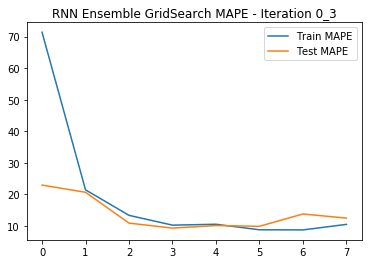

Epoch 1/40
69/69 [==============================] - 3s 49ms/step - loss: 4833387520.0000 - mean_absolute_percentage_error: 66.7186 - val_loss: 642378752.0000 - val_mean_absolute_percentage_error: 22.5209
Epoch 2/40
69/69 [==============================] - 3s 45ms/step - loss: 309826528.0000 - mean_absolute_percentage_error: 15.0324 - val_loss: 194524256.0000 - val_mean_absolute_percentage_error: 11.7517
Epoch 3/40
69/69 [==============================] - 3s 44ms/step - loss: 233721840.0000 - mean_absolute_percentage_error: 13.2712 - val_loss: 821333056.0000 - val_mean_absolute_percentage_error: 28.6199
Epoch 4/40
69/69 [==============================] - 3s 44ms/step - loss: 232579664.0000 - mean_absolute_percentage_error: 13.0373 - val_loss: 162276240.0000 - val_mean_absolute_percentage_error: 10.6560
Epoch 5/40
69/69 [==============================] - 3s 44ms/step - loss: 150493408.0000 - mean_absolute_percentage_error: 10.9782 - val_loss: 140598736.0000 - val_mean_absolute_percentage

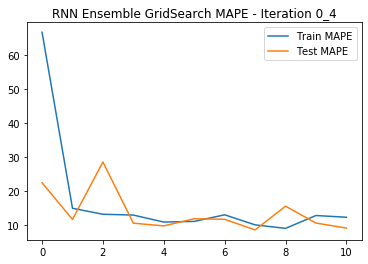

seq_length              12.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            3.000
learning_rate            0.001
epochs                  80.000
Name: 1, dtype: float64
Epoch 1/80
69/69 [==============================] - 3s 44ms/step - loss: 4601036800.0000 - mean_absolute_percentage_error: 64.6384 - val_loss: 1029958784.0000 - val_mean_absolute_percentage_error: 30.4097
Epoch 2/80
69/69 [==============================] - 3s 39ms/step - loss: 553193984.0000 - mean_absolute_percentage_error: 19.8202 - val_loss: 386120096.0000 - val_mean_absolute_percentage_error: 18.6369
Epoch 3/80
69/69 [==============================] - 3s 39ms/step - loss: 221099536.0000 - mean_absolute_percentage_error: 13.2129 - val_loss: 180930336.0000 - val_mean_absolute_percentage_error: 11.1240
Epoch 4/80
69/69 [==============================] - 3s 

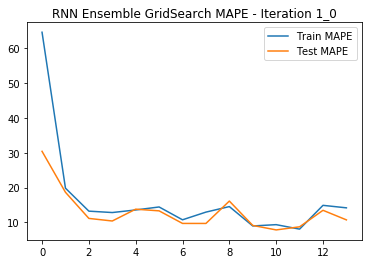

Epoch 1/80
69/69 [==============================] - 3s 40ms/step - loss: 5472687616.0000 - mean_absolute_percentage_error: 75.0364 - val_loss: 3112695552.0000 - val_mean_absolute_percentage_error: 58.5661
Epoch 2/80
69/69 [==============================] - 2s 35ms/step - loss: 609742272.0000 - mean_absolute_percentage_error: 20.2507 - val_loss: 191463616.0000 - val_mean_absolute_percentage_error: 11.9942
Epoch 3/80
69/69 [==============================] - 2s 35ms/step - loss: 176556736.0000 - mean_absolute_percentage_error: 11.5243 - val_loss: 191068560.0000 - val_mean_absolute_percentage_error: 12.8669
Epoch 4/80
69/69 [==============================] - 2s 35ms/step - loss: 272625056.0000 - mean_absolute_percentage_error: 14.3392 - val_loss: 141307664.0000 - val_mean_absolute_percentage_error: 10.3278
Epoch 5/80
69/69 [==============================] - 2s 35ms/step - loss: 144389600.0000 - mean_absolute_percentage_error: 10.5058 - val_loss: 130047632.0000 - val_mean_absolute_percentag

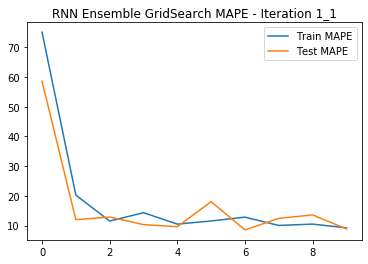

Epoch 1/80
69/69 [==============================] - 3s 39ms/step - loss: 5170212352.0000 - mean_absolute_percentage_error: 71.1051 - val_loss: 620648256.0000 - val_mean_absolute_percentage_error: 22.2837
Epoch 2/80
69/69 [==============================] - 2s 35ms/step - loss: 464808160.0000 - mean_absolute_percentage_error: 18.7799 - val_loss: 183626320.0000 - val_mean_absolute_percentage_error: 11.9692
Epoch 3/80
69/69 [==============================] - 2s 35ms/step - loss: 248254272.0000 - mean_absolute_percentage_error: 13.8894 - val_loss: 224367088.0000 - val_mean_absolute_percentage_error: 14.0739
Epoch 4/80
69/69 [==============================] - 2s 35ms/step - loss: 232741280.0000 - mean_absolute_percentage_error: 13.2134 - val_loss: 274784672.0000 - val_mean_absolute_percentage_error: 15.7266
Epoch 5/80
69/69 [==============================] - 2s 35ms/step - loss: 153631136.0000 - mean_absolute_percentage_error: 10.6981 - val_loss: 168835392.0000 - val_mean_absolute_percentage

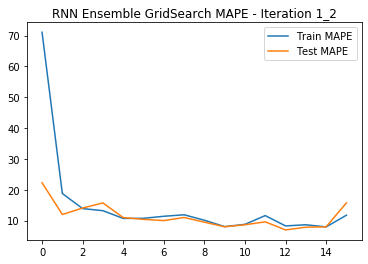

Epoch 1/80
69/69 [==============================] - 3s 40ms/step - loss: 5321549824.0000 - mean_absolute_percentage_error: 71.3523 - val_loss: 666564352.0000 - val_mean_absolute_percentage_error: 22.9674
Epoch 2/80
69/69 [==============================] - 2s 36ms/step - loss: 567732672.0000 - mean_absolute_percentage_error: 21.4641 - val_loss: 504759520.0000 - val_mean_absolute_percentage_error: 20.6898
Epoch 3/80
69/69 [==============================] - 2s 35ms/step - loss: 237330704.0000 - mean_absolute_percentage_error: 13.3907 - val_loss: 165071808.0000 - val_mean_absolute_percentage_error: 10.9346
Epoch 4/80
69/69 [==============================] - 2s 34ms/step - loss: 139467520.0000 - mean_absolute_percentage_error: 10.2860 - val_loss: 132885040.0000 - val_mean_absolute_percentage_error: 9.3537
Epoch 5/80
69/69 [==============================] - 2s 34ms/step - loss: 154472960.0000 - mean_absolute_percentage_error: 10.5709 - val_loss: 132626032.0000 - val_mean_absolute_percentage_

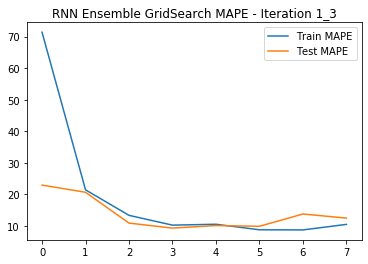

Epoch 1/80
69/69 [==============================] - 3s 46ms/step - loss: 4833387520.0000 - mean_absolute_percentage_error: 66.7186 - val_loss: 642378752.0000 - val_mean_absolute_percentage_error: 22.5209
Epoch 2/80
69/69 [==============================] - 3s 37ms/step - loss: 309826528.0000 - mean_absolute_percentage_error: 15.0324 - val_loss: 194524256.0000 - val_mean_absolute_percentage_error: 11.7517
Epoch 3/80
69/69 [==============================] - 3s 37ms/step - loss: 233721840.0000 - mean_absolute_percentage_error: 13.2712 - val_loss: 821333056.0000 - val_mean_absolute_percentage_error: 28.6199
Epoch 4/80
69/69 [==============================] - 3s 37ms/step - loss: 232579664.0000 - mean_absolute_percentage_error: 13.0373 - val_loss: 162276240.0000 - val_mean_absolute_percentage_error: 10.6560
Epoch 5/80
69/69 [==============================] - 3s 37ms/step - loss: 150493408.0000 - mean_absolute_percentage_error: 10.9782 - val_loss: 140598736.0000 - val_mean_absolute_percentage

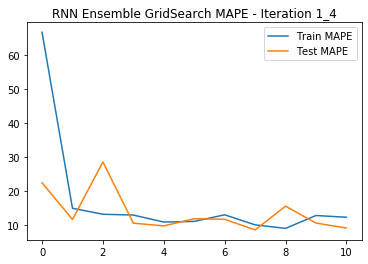

seq_length              12.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.00
stop_patience            3.00
learning_rate            0.01
epochs                  40.00
Name: 2, dtype: float64
Epoch 1/40
69/69 [==============================] - 3s 43ms/step - loss: 8578494976.0000 - mean_absolute_percentage_error: 97.0704 - val_loss: 8049129984.0000 - val_mean_absolute_percentage_error: 98.0720
Epoch 2/40
69/69 [==============================] - 3s 38ms/step - loss: 2736684288.0000 - mean_absolute_percentage_error: 48.9126 - val_loss: 643397824.0000 - val_mean_absolute_percentage_error: 22.2379
Epoch 3/40
69/69 [==============================] - 3s 38ms/step - loss: 574602176.0000 - mean_absolute_percentage_error: 21.2161 - val_loss: 237966128.0000 - val_mean_absolute_percentage_error: 11.9395
Epoch 4/40
69/69 [==============================] - 3s 37ms/step

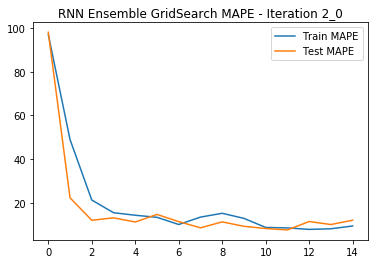

Epoch 1/40
69/69 [==============================] - 4s 52ms/step - loss: 6784566784.0000 - mean_absolute_percentage_error: 66.8120 - val_loss: 364373760.0000 - val_mean_absolute_percentage_error: 15.5566
Epoch 2/40
69/69 [==============================] - 3s 47ms/step - loss: 331783808.0000 - mean_absolute_percentage_error: 15.9213 - val_loss: 444596096.0000 - val_mean_absolute_percentage_error: 18.6421
Epoch 3/40
69/69 [==============================] - 3s 47ms/step - loss: 286382976.0000 - mean_absolute_percentage_error: 14.3993 - val_loss: 325022592.0000 - val_mean_absolute_percentage_error: 18.7483
Epoch 4/40
69/69 [==============================] - 3s 48ms/step - loss: 229702864.0000 - mean_absolute_percentage_error: 13.5697 - val_loss: 132011856.0000 - val_mean_absolute_percentage_error: 9.5899
Epoch 5/40
69/69 [==============================] - 3s 47ms/step - loss: 208877216.0000 - mean_absolute_percentage_error: 12.6800 - val_loss: 279302656.0000 - val_mean_absolute_percentage_

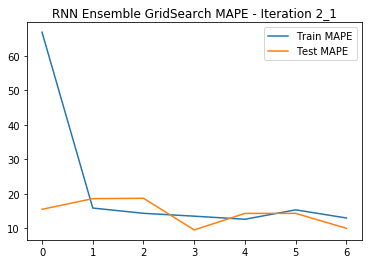

Epoch 1/40
69/69 [==============================] - 3s 48ms/step - loss: 6993918976.0000 - mean_absolute_percentage_error: 86.1231 - val_loss: 2276012288.0000 - val_mean_absolute_percentage_error: 47.5787
Epoch 2/40
69/69 [==============================] - 3s 43ms/step - loss: 1022903616.0000 - mean_absolute_percentage_error: 26.8075 - val_loss: 1734718208.0000 - val_mean_absolute_percentage_error: 41.8292
Epoch 3/40
69/69 [==============================] - 3s 43ms/step - loss: 437069376.0000 - mean_absolute_percentage_error: 18.7233 - val_loss: 122144384.0000 - val_mean_absolute_percentage_error: 9.0015
Epoch 4/40
69/69 [==============================] - 3s 43ms/step - loss: 171215168.0000 - mean_absolute_percentage_error: 11.4185 - val_loss: 94837112.0000 - val_mean_absolute_percentage_error: 8.9203
Epoch 5/40
69/69 [==============================] - 3s 43ms/step - loss: 131411808.0000 - mean_absolute_percentage_error: 10.0198 - val_loss: 126737720.0000 - val_mean_absolute_percentage

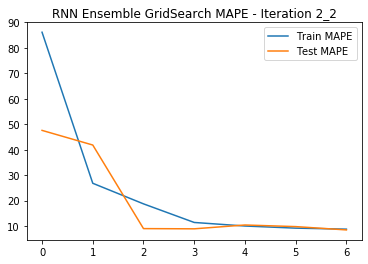

Epoch 1/40
69/69 [==============================] - 3s 48ms/step - loss: 6644788736.0000 - mean_absolute_percentage_error: 82.1999 - val_loss: 3099299840.0000 - val_mean_absolute_percentage_error: 56.5300
Epoch 2/40
69/69 [==============================] - 3s 37ms/step - loss: 1180164608.0000 - mean_absolute_percentage_error: 28.9560 - val_loss: 283963616.0000 - val_mean_absolute_percentage_error: 13.7522
Epoch 3/40
69/69 [==============================] - 3s 37ms/step - loss: 220508368.0000 - mean_absolute_percentage_error: 12.5520 - val_loss: 115539288.0000 - val_mean_absolute_percentage_error: 9.2055
Epoch 4/40
69/69 [==============================] - 3s 37ms/step - loss: 187761184.0000 - mean_absolute_percentage_error: 11.7588 - val_loss: 137473600.0000 - val_mean_absolute_percentage_error: 10.9558
Epoch 5/40
69/69 [==============================] - 3s 37ms/step - loss: 121434728.0000 - mean_absolute_percentage_error: 9.3541 - val_loss: 407019456.0000 - val_mean_absolute_percentage

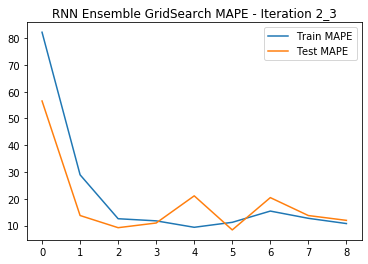

Epoch 1/40
69/69 [==============================] - 3s 41ms/step - loss: 6282720768.0000 - mean_absolute_percentage_error: 74.7828 - val_loss: 1802881024.0000 - val_mean_absolute_percentage_error: 41.2857
Epoch 2/40
69/69 [==============================] - 3s 36ms/step - loss: 7115197440.0000 - mean_absolute_percentage_error: 78.2196 - val_loss: 3319392256.0000 - val_mean_absolute_percentage_error: 60.9754
Epoch 3/40
69/69 [==============================] - 3s 36ms/step - loss: 925638848.0000 - mean_absolute_percentage_error: 26.6699 - val_loss: 387647008.0000 - val_mean_absolute_percentage_error: 17.1609
Epoch 4/40
69/69 [==============================] - 2s 36ms/step - loss: 304944896.0000 - mean_absolute_percentage_error: 15.3323 - val_loss: 218173984.0000 - val_mean_absolute_percentage_error: 13.4438
Epoch 5/40
69/69 [==============================] - 3s 36ms/step - loss: 201953920.0000 - mean_absolute_percentage_error: 12.5251 - val_loss: 209320160.0000 - val_mean_absolute_percent

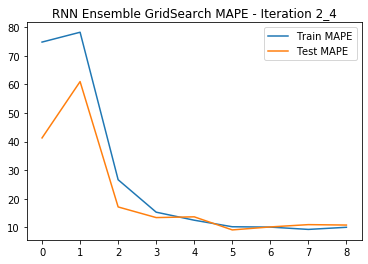

seq_length              12.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.00
stop_patience            3.00
learning_rate            0.01
epochs                  80.00
Name: 3, dtype: float64
Epoch 1/80
69/69 [==============================] - 4s 52ms/step - loss: 8578494976.0000 - mean_absolute_percentage_error: 97.0704 - val_loss: 8049129984.0000 - val_mean_absolute_percentage_error: 98.0720
Epoch 2/80
69/69 [==============================] - 3s 46ms/step - loss: 2736684288.0000 - mean_absolute_percentage_error: 48.9126 - val_loss: 643397824.0000 - val_mean_absolute_percentage_error: 22.2379
Epoch 3/80
69/69 [==============================] - 3s 46ms/step - loss: 574602176.0000 - mean_absolute_percentage_error: 21.2161 - val_loss: 237966128.0000 - val_mean_absolute_percentage_error: 11.9395
Epoch 4/80
69/69 [==============================] - 3s 46ms/step

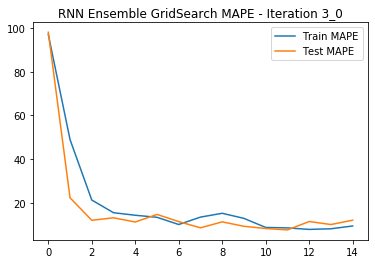

Epoch 1/80
69/69 [==============================] - 3s 48ms/step - loss: 6784566784.0000 - mean_absolute_percentage_error: 66.8120 - val_loss: 364373760.0000 - val_mean_absolute_percentage_error: 15.5566
Epoch 2/80
69/69 [==============================] - 3s 43ms/step - loss: 331783808.0000 - mean_absolute_percentage_error: 15.9213 - val_loss: 444596096.0000 - val_mean_absolute_percentage_error: 18.6421
Epoch 3/80
69/69 [==============================] - 3s 42ms/step - loss: 286382976.0000 - mean_absolute_percentage_error: 14.3993 - val_loss: 325022592.0000 - val_mean_absolute_percentage_error: 18.7483
Epoch 4/80
69/69 [==============================] - 3s 42ms/step - loss: 229702864.0000 - mean_absolute_percentage_error: 13.5697 - val_loss: 132011856.0000 - val_mean_absolute_percentage_error: 9.5899
Epoch 5/80
69/69 [==============================] - 3s 42ms/step - loss: 208877216.0000 - mean_absolute_percentage_error: 12.6800 - val_loss: 279302656.0000 - val_mean_absolute_percentage_

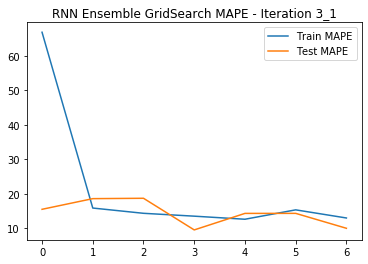

Epoch 1/80
69/69 [==============================] - 4s 52ms/step - loss: 6993918976.0000 - mean_absolute_percentage_error: 86.1231 - val_loss: 2276012288.0000 - val_mean_absolute_percentage_error: 47.5787
Epoch 2/80
69/69 [==============================] - 3s 47ms/step - loss: 1022903616.0000 - mean_absolute_percentage_error: 26.8075 - val_loss: 1734718208.0000 - val_mean_absolute_percentage_error: 41.8292
Epoch 3/80
69/69 [==============================] - 3s 47ms/step - loss: 437069376.0000 - mean_absolute_percentage_error: 18.7233 - val_loss: 122144384.0000 - val_mean_absolute_percentage_error: 9.0015
Epoch 4/80
69/69 [==============================] - 3s 48ms/step - loss: 171215168.0000 - mean_absolute_percentage_error: 11.4185 - val_loss: 94837112.0000 - val_mean_absolute_percentage_error: 8.9203
Epoch 5/80
69/69 [==============================] - 3s 48ms/step - loss: 131411808.0000 - mean_absolute_percentage_error: 10.0198 - val_loss: 126737720.0000 - val_mean_absolute_percentage

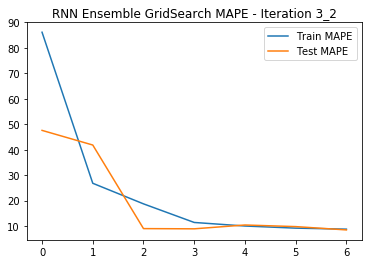

Epoch 1/80
69/69 [==============================] - 3s 47ms/step - loss: 6644788736.0000 - mean_absolute_percentage_error: 82.1999 - val_loss: 3099299840.0000 - val_mean_absolute_percentage_error: 56.5300
Epoch 2/80
69/69 [==============================] - 3s 40ms/step - loss: 1180164608.0000 - mean_absolute_percentage_error: 28.9560 - val_loss: 283963616.0000 - val_mean_absolute_percentage_error: 13.7522
Epoch 3/80
69/69 [==============================] - 3s 39ms/step - loss: 220508368.0000 - mean_absolute_percentage_error: 12.5520 - val_loss: 115539288.0000 - val_mean_absolute_percentage_error: 9.2055
Epoch 4/80
69/69 [==============================] - 3s 40ms/step - loss: 187761184.0000 - mean_absolute_percentage_error: 11.7588 - val_loss: 137473600.0000 - val_mean_absolute_percentage_error: 10.9558
Epoch 5/80
69/69 [==============================] - 3s 40ms/step - loss: 121434728.0000 - mean_absolute_percentage_error: 9.3541 - val_loss: 407019456.0000 - val_mean_absolute_percentage

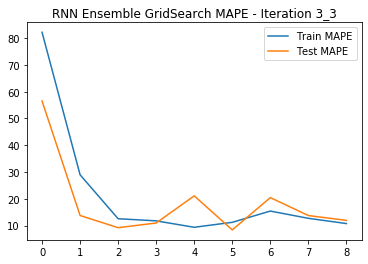

Epoch 1/80
69/69 [==============================] - 3s 47ms/step - loss: 6282720768.0000 - mean_absolute_percentage_error: 74.7828 - val_loss: 1802881024.0000 - val_mean_absolute_percentage_error: 41.2857
Epoch 2/80
69/69 [==============================] - 3s 41ms/step - loss: 7115197440.0000 - mean_absolute_percentage_error: 78.2196 - val_loss: 3319392256.0000 - val_mean_absolute_percentage_error: 60.9754
Epoch 3/80
69/69 [==============================] - 3s 41ms/step - loss: 925638848.0000 - mean_absolute_percentage_error: 26.6699 - val_loss: 387647008.0000 - val_mean_absolute_percentage_error: 17.1609
Epoch 4/80
69/69 [==============================] - 3s 41ms/step - loss: 304944896.0000 - mean_absolute_percentage_error: 15.3323 - val_loss: 218173984.0000 - val_mean_absolute_percentage_error: 13.4438
Epoch 5/80
69/69 [==============================] - 3s 41ms/step - loss: 201953920.0000 - mean_absolute_percentage_error: 12.5251 - val_loss: 209320160.0000 - val_mean_absolute_percent

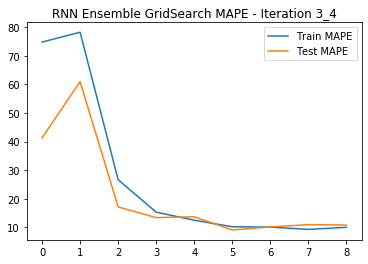

seq_length              12.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            4.000
learning_rate            0.001
epochs                  40.000
Name: 4, dtype: float64
Epoch 1/40
69/69 [==============================] - 3s 45ms/step - loss: 4601036800.0000 - mean_absolute_percentage_error: 64.6384 - val_loss: 1029958784.0000 - val_mean_absolute_percentage_error: 30.4097
Epoch 2/40
69/69 [==============================] - 3s 39ms/step - loss: 553193984.0000 - mean_absolute_percentage_error: 19.8202 - val_loss: 386120096.0000 - val_mean_absolute_percentage_error: 18.6369
Epoch 3/40
69/69 [==============================] - 3s 38ms/step - loss: 221099536.0000 - mean_absolute_percentage_error: 13.2129 - val_loss: 180930336.0000 - val_mean_absolute_percentage_error: 11.1240
Epoch 4/40
69/69 [==============================] - 3s 

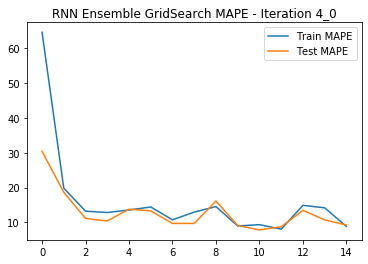

Epoch 1/40
69/69 [==============================] - 3s 45ms/step - loss: 5091983360.0000 - mean_absolute_percentage_error: 67.5601 - val_loss: 384878944.0000 - val_mean_absolute_percentage_error: 18.4561
Epoch 2/40
69/69 [==============================] - 3s 38ms/step - loss: 294058752.0000 - mean_absolute_percentage_error: 14.9688 - val_loss: 186277520.0000 - val_mean_absolute_percentage_error: 12.4191
Epoch 3/40
69/69 [==============================] - 3s 38ms/step - loss: 452754272.0000 - mean_absolute_percentage_error: 18.3941 - val_loss: 274169472.0000 - val_mean_absolute_percentage_error: 14.8960
Epoch 4/40
69/69 [==============================] - 3s 38ms/step - loss: 247863328.0000 - mean_absolute_percentage_error: 13.5722 - val_loss: 128416208.0000 - val_mean_absolute_percentage_error: 9.6055
Epoch 5/40
69/69 [==============================] - 3s 38ms/step - loss: 170182160.0000 - mean_absolute_percentage_error: 11.1996 - val_loss: 285392096.0000 - val_mean_absolute_percentage_

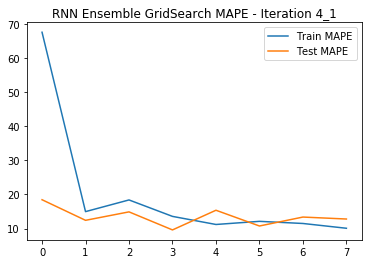

Epoch 1/40
69/69 [==============================] - 4s 55ms/step - loss: 6133401600.0000 - mean_absolute_percentage_error: 79.6484 - val_loss: 793967808.0000 - val_mean_absolute_percentage_error: 25.9257
Epoch 2/40
69/69 [==============================] - 3s 48ms/step - loss: 518749664.0000 - mean_absolute_percentage_error: 20.1751 - val_loss: 407921856.0000 - val_mean_absolute_percentage_error: 19.2021
Epoch 3/40
69/69 [==============================] - 3s 48ms/step - loss: 199061472.0000 - mean_absolute_percentage_error: 12.2512 - val_loss: 157452000.0000 - val_mean_absolute_percentage_error: 10.8758
Epoch 4/40
69/69 [==============================] - 3s 48ms/step - loss: 166110080.0000 - mean_absolute_percentage_error: 11.3390 - val_loss: 179271184.0000 - val_mean_absolute_percentage_error: 12.5718
Epoch 5/40
69/69 [==============================] - 3s 49ms/step - loss: 220856192.0000 - mean_absolute_percentage_error: 13.0679 - val_loss: 135371792.0000 - val_mean_absolute_percentage

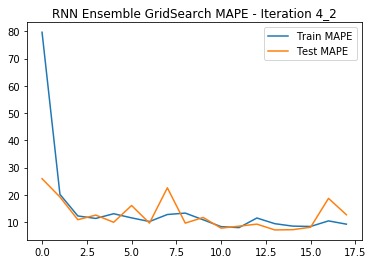

Epoch 1/40
69/69 [==============================] - 4s 52ms/step - loss: 5200955392.0000 - mean_absolute_percentage_error: 70.6337 - val_loss: 547906880.0000 - val_mean_absolute_percentage_error: 20.9910
Epoch 2/40
69/69 [==============================] - 3s 44ms/step - loss: 549004608.0000 - mean_absolute_percentage_error: 20.7890 - val_loss: 180485056.0000 - val_mean_absolute_percentage_error: 11.5738
Epoch 3/40
69/69 [==============================] - 3s 44ms/step - loss: 224641536.0000 - mean_absolute_percentage_error: 13.1503 - val_loss: 235876448.0000 - val_mean_absolute_percentage_error: 12.5833
Epoch 4/40
69/69 [==============================] - 3s 44ms/step - loss: 220505808.0000 - mean_absolute_percentage_error: 12.7606 - val_loss: 144548592.0000 - val_mean_absolute_percentage_error: 10.7029
Epoch 5/40
69/69 [==============================] - 3s 44ms/step - loss: 120754224.0000 - mean_absolute_percentage_error: 9.7815 - val_loss: 157560304.0000 - val_mean_absolute_percentage_

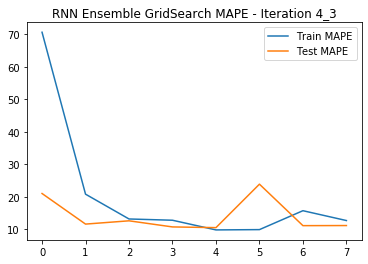

Epoch 1/40
69/69 [==============================] - 4s 52ms/step - loss: 6115152896.0000 - mean_absolute_percentage_error: 80.0977 - val_loss: 1177548288.0000 - val_mean_absolute_percentage_error: 31.1227
Epoch 2/40
69/69 [==============================] - 3s 45ms/step - loss: 634872960.0000 - mean_absolute_percentage_error: 21.2631 - val_loss: 206500960.0000 - val_mean_absolute_percentage_error: 13.0102
Epoch 3/40
69/69 [==============================] - 3s 45ms/step - loss: 189781440.0000 - mean_absolute_percentage_error: 11.9195 - val_loss: 165847904.0000 - val_mean_absolute_percentage_error: 11.6453
Epoch 4/40
69/69 [==============================] - 3s 45ms/step - loss: 282515744.0000 - mean_absolute_percentage_error: 14.8128 - val_loss: 235433264.0000 - val_mean_absolute_percentage_error: 14.0492
Epoch 5/40
69/69 [==============================] - 3s 45ms/step - loss: 214727824.0000 - mean_absolute_percentage_error: 12.4929 - val_loss: 116033824.0000 - val_mean_absolute_percentag

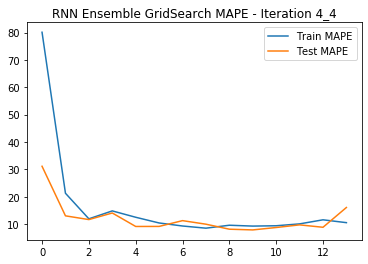

seq_length              12.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            4.000
learning_rate            0.001
epochs                  80.000
Name: 5, dtype: float64
Epoch 1/80
69/69 [==============================] - 3s 50ms/step - loss: 4601036800.0000 - mean_absolute_percentage_error: 64.6384 - val_loss: 1029958784.0000 - val_mean_absolute_percentage_error: 30.4097
Epoch 2/80
69/69 [==============================] - 3s 44ms/step - loss: 553193984.0000 - mean_absolute_percentage_error: 19.8202 - val_loss: 386120096.0000 - val_mean_absolute_percentage_error: 18.6369
Epoch 3/80
69/69 [==============================] - 3s 44ms/step - loss: 221099536.0000 - mean_absolute_percentage_error: 13.2129 - val_loss: 180930336.0000 - val_mean_absolute_percentage_error: 11.1240
Epoch 4/80
69/69 [==============================] - 3s 

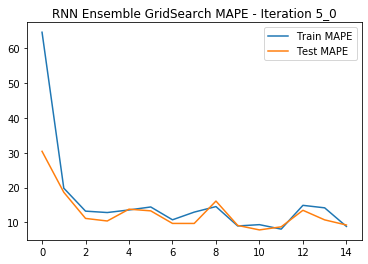

Epoch 1/80
69/69 [==============================] - 4s 51ms/step - loss: 5091983360.0000 - mean_absolute_percentage_error: 67.5601 - val_loss: 384878944.0000 - val_mean_absolute_percentage_error: 18.4561
Epoch 2/80
69/69 [==============================] - 3s 46ms/step - loss: 294058752.0000 - mean_absolute_percentage_error: 14.9688 - val_loss: 186277520.0000 - val_mean_absolute_percentage_error: 12.4191
Epoch 3/80
69/69 [==============================] - 3s 45ms/step - loss: 452754272.0000 - mean_absolute_percentage_error: 18.3941 - val_loss: 274169472.0000 - val_mean_absolute_percentage_error: 14.8960
Epoch 4/80
69/69 [==============================] - 3s 45ms/step - loss: 247863328.0000 - mean_absolute_percentage_error: 13.5722 - val_loss: 128416208.0000 - val_mean_absolute_percentage_error: 9.6055
Epoch 5/80
69/69 [==============================] - 3s 44ms/step - loss: 170182160.0000 - mean_absolute_percentage_error: 11.1996 - val_loss: 285392096.0000 - val_mean_absolute_percentage_

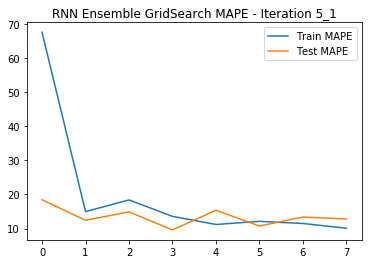

Epoch 1/80
69/69 [==============================] - 4s 52ms/step - loss: 6133401600.0000 - mean_absolute_percentage_error: 79.6484 - val_loss: 793967808.0000 - val_mean_absolute_percentage_error: 25.9257
Epoch 2/80
69/69 [==============================] - 3s 45ms/step - loss: 518749664.0000 - mean_absolute_percentage_error: 20.1751 - val_loss: 407921856.0000 - val_mean_absolute_percentage_error: 19.2021
Epoch 3/80
69/69 [==============================] - 3s 45ms/step - loss: 199061472.0000 - mean_absolute_percentage_error: 12.2512 - val_loss: 157452000.0000 - val_mean_absolute_percentage_error: 10.8758
Epoch 4/80
69/69 [==============================] - 3s 45ms/step - loss: 166110080.0000 - mean_absolute_percentage_error: 11.3390 - val_loss: 179271184.0000 - val_mean_absolute_percentage_error: 12.5718
Epoch 5/80
69/69 [==============================] - 3s 45ms/step - loss: 220856192.0000 - mean_absolute_percentage_error: 13.0679 - val_loss: 135371792.0000 - val_mean_absolute_percentage

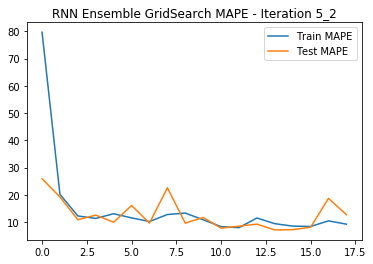

Epoch 1/80
69/69 [==============================] - 4s 54ms/step - loss: 5200955392.0000 - mean_absolute_percentage_error: 70.6337 - val_loss: 547906880.0000 - val_mean_absolute_percentage_error: 20.9910
Epoch 2/80
69/69 [==============================] - 3s 48ms/step - loss: 549004608.0000 - mean_absolute_percentage_error: 20.7890 - val_loss: 180485056.0000 - val_mean_absolute_percentage_error: 11.5738
Epoch 3/80
69/69 [==============================] - 3s 48ms/step - loss: 224641536.0000 - mean_absolute_percentage_error: 13.1503 - val_loss: 235876448.0000 - val_mean_absolute_percentage_error: 12.5833
Epoch 4/80
69/69 [==============================] - 3s 48ms/step - loss: 220505808.0000 - mean_absolute_percentage_error: 12.7606 - val_loss: 144548592.0000 - val_mean_absolute_percentage_error: 10.7029
Epoch 5/80
69/69 [==============================] - 3s 48ms/step - loss: 120754224.0000 - mean_absolute_percentage_error: 9.7815 - val_loss: 157560304.0000 - val_mean_absolute_percentage_

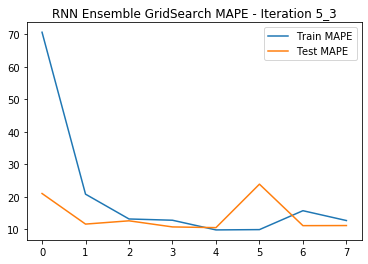

Epoch 1/80
69/69 [==============================] - 4s 52ms/step - loss: 6115152896.0000 - mean_absolute_percentage_error: 80.0977 - val_loss: 1177548288.0000 - val_mean_absolute_percentage_error: 31.1227
Epoch 2/80
69/69 [==============================] - 3s 46ms/step - loss: 634872960.0000 - mean_absolute_percentage_error: 21.2631 - val_loss: 206500960.0000 - val_mean_absolute_percentage_error: 13.0102
Epoch 3/80
69/69 [==============================] - 3s 46ms/step - loss: 189781440.0000 - mean_absolute_percentage_error: 11.9195 - val_loss: 165847904.0000 - val_mean_absolute_percentage_error: 11.6453
Epoch 4/80
69/69 [==============================] - 3s 46ms/step - loss: 282515744.0000 - mean_absolute_percentage_error: 14.8128 - val_loss: 235433264.0000 - val_mean_absolute_percentage_error: 14.0492
Epoch 5/80
69/69 [==============================] - 3s 46ms/step - loss: 214727824.0000 - mean_absolute_percentage_error: 12.4929 - val_loss: 116033824.0000 - val_mean_absolute_percentag

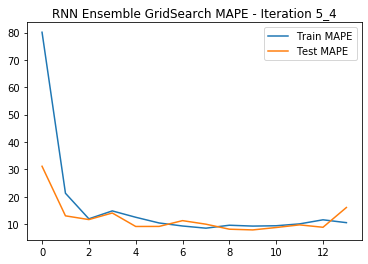

seq_length              12.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.00
stop_patience            4.00
learning_rate            0.01
epochs                  40.00
Name: 6, dtype: float64
Epoch 1/40
69/69 [==============================] - 4s 52ms/step - loss: 8578494976.0000 - mean_absolute_percentage_error: 97.0704 - val_loss: 8049129984.0000 - val_mean_absolute_percentage_error: 98.0720
Epoch 2/40
69/69 [==============================] - 3s 45ms/step - loss: 2736684288.0000 - mean_absolute_percentage_error: 48.9126 - val_loss: 643397824.0000 - val_mean_absolute_percentage_error: 22.2379
Epoch 3/40
69/69 [==============================] - 3s 46ms/step - loss: 574602176.0000 - mean_absolute_percentage_error: 21.2161 - val_loss: 237966128.0000 - val_mean_absolute_percentage_error: 11.9395
Epoch 4/40
69/69 [==============================] - 3s 46ms/step

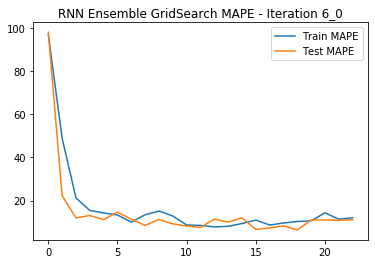

Epoch 1/40
69/69 [==============================] - 4s 56ms/step - loss: 4623290368.0000 - mean_absolute_percentage_error: 64.8832 - val_loss: 836644544.0000 - val_mean_absolute_percentage_error: 24.3046
Epoch 2/40
69/69 [==============================] - 3s 49ms/step - loss: 487363232.0000 - mean_absolute_percentage_error: 18.8170 - val_loss: 145691520.0000 - val_mean_absolute_percentage_error: 9.9555
Epoch 3/40
69/69 [==============================] - 3s 49ms/step - loss: 178281568.0000 - mean_absolute_percentage_error: 11.4180 - val_loss: 109809056.0000 - val_mean_absolute_percentage_error: 9.6719
Epoch 4/40
69/69 [==============================] - 4s 53ms/step - loss: 504592224.0000 - mean_absolute_percentage_error: 20.0130 - val_loss: 1116656512.0000 - val_mean_absolute_percentage_error: 33.6952
Epoch 5/40
69/69 [==============================] - 4s 53ms/step - loss: 499495136.0000 - mean_absolute_percentage_error: 18.5633 - val_loss: 402226880.0000 - val_mean_absolute_percentage_

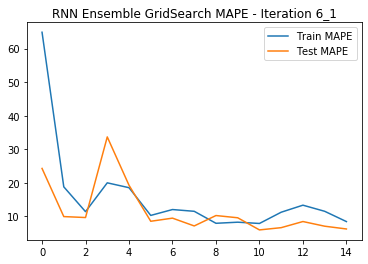

Epoch 1/40
69/69 [==============================] - 4s 56ms/step - loss: 15211596800.0000 - mean_absolute_percentage_error: 87.5772 - val_loss: 1056215616.0000 - val_mean_absolute_percentage_error: 29.0646
Epoch 2/40
69/69 [==============================] - 3s 51ms/step - loss: 3724547328.0000 - mean_absolute_percentage_error: 57.6973 - val_loss: 2536265728.0000 - val_mean_absolute_percentage_error: 51.7182
Epoch 3/40
69/69 [==============================] - 4s 51ms/step - loss: 519001760.0000 - mean_absolute_percentage_error: 18.9860 - val_loss: 227161376.0000 - val_mean_absolute_percentage_error: 13.0711
Epoch 4/40
69/69 [==============================] - 3s 50ms/step - loss: 229528480.0000 - mean_absolute_percentage_error: 13.0158 - val_loss: 139823376.0000 - val_mean_absolute_percentage_error: 10.6101
Epoch 5/40
69/69 [==============================] - 3s 50ms/step - loss: 173519472.0000 - mean_absolute_percentage_error: 11.2818 - val_loss: 133359072.0000 - val_mean_absolute_percen

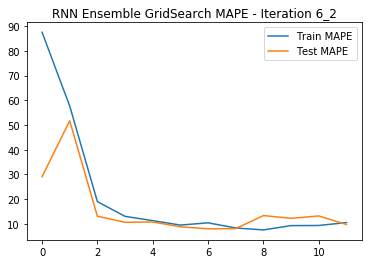

Epoch 1/40
69/69 [==============================] - 4s 64ms/step - loss: 15775435776.0000 - mean_absolute_percentage_error: 91.1051 - val_loss: 1417324928.0000 - val_mean_absolute_percentage_error: 32.7998
Epoch 2/40
69/69 [==============================] - 4s 55ms/step - loss: 1282803072.0000 - mean_absolute_percentage_error: 28.2300 - val_loss: 356961728.0000 - val_mean_absolute_percentage_error: 15.2395
Epoch 3/40
69/69 [==============================] - 4s 55ms/step - loss: 387354080.0000 - mean_absolute_percentage_error: 16.9543 - val_loss: 300735808.0000 - val_mean_absolute_percentage_error: 15.8937
Epoch 4/40
69/69 [==============================] - 4s 53ms/step - loss: 220967392.0000 - mean_absolute_percentage_error: 12.7672 - val_loss: 166058160.0000 - val_mean_absolute_percentage_error: 10.6350
Epoch 5/40
69/69 [==============================] - 4s 52ms/step - loss: 194751104.0000 - mean_absolute_percentage_error: 11.8585 - val_loss: 318567168.0000 - val_mean_absolute_percent

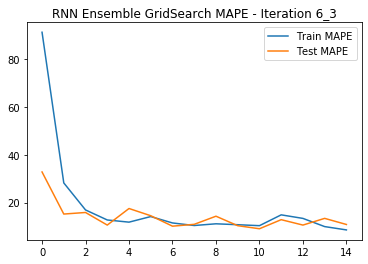

Epoch 1/40
69/69 [==============================] - 4s 55ms/step - loss: 7577960448.0000 - mean_absolute_percentage_error: 91.2376 - val_loss: 7914167296.0000 - val_mean_absolute_percentage_error: 97.3534
Epoch 2/40
69/69 [==============================] - 3s 46ms/step - loss: 6804460032.0000 - mean_absolute_percentage_error: 83.6492 - val_loss: 2500444672.0000 - val_mean_absolute_percentage_error: 48.6107
Epoch 3/40
69/69 [==============================] - 3s 47ms/step - loss: 2683738880.0000 - mean_absolute_percentage_error: 47.2859 - val_loss: 571378944.0000 - val_mean_absolute_percentage_error: 20.3469
Epoch 4/40
69/69 [==============================] - 3s 48ms/step - loss: 1360750208.0000 - mean_absolute_percentage_error: 32.3923 - val_loss: 379080224.0000 - val_mean_absolute_percentage_error: 16.7050
Epoch 5/40
69/69 [==============================] - 3s 48ms/step - loss: 218318448.0000 - mean_absolute_percentage_error: 12.3142 - val_loss: 144182736.0000 - val_mean_absolute_perce

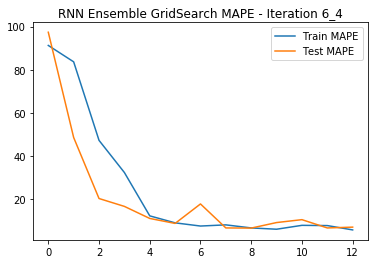

seq_length              12.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.00
stop_patience            4.00
learning_rate            0.01
epochs                  80.00
Name: 7, dtype: float64
Epoch 1/80
69/69 [==============================] - 3s 48ms/step - loss: 8578494976.0000 - mean_absolute_percentage_error: 97.0704 - val_loss: 8049129984.0000 - val_mean_absolute_percentage_error: 98.0720
Epoch 2/80
69/69 [==============================] - 3s 42ms/step - loss: 2736684288.0000 - mean_absolute_percentage_error: 48.9126 - val_loss: 643397824.0000 - val_mean_absolute_percentage_error: 22.2379
Epoch 3/80
69/69 [==============================] - 3s 42ms/step - loss: 574602176.0000 - mean_absolute_percentage_error: 21.2161 - val_loss: 237966128.0000 - val_mean_absolute_percentage_error: 11.9395
Epoch 4/80
69/69 [==============================] - 3s 42ms/step

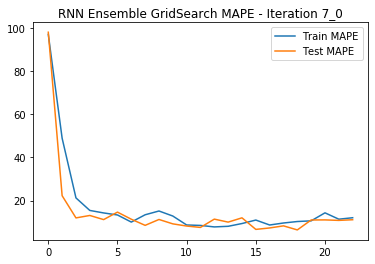

Epoch 1/80
69/69 [==============================] - 4s 52ms/step - loss: 4623290368.0000 - mean_absolute_percentage_error: 64.8832 - val_loss: 836644544.0000 - val_mean_absolute_percentage_error: 24.3046
Epoch 2/80
69/69 [==============================] - 3s 46ms/step - loss: 487363232.0000 - mean_absolute_percentage_error: 18.8170 - val_loss: 145691520.0000 - val_mean_absolute_percentage_error: 9.9555
Epoch 3/80
69/69 [==============================] - 3s 46ms/step - loss: 178281568.0000 - mean_absolute_percentage_error: 11.4180 - val_loss: 109809056.0000 - val_mean_absolute_percentage_error: 9.6719
Epoch 4/80
69/69 [==============================] - 3s 46ms/step - loss: 504592224.0000 - mean_absolute_percentage_error: 20.0130 - val_loss: 1116656512.0000 - val_mean_absolute_percentage_error: 33.6952
Epoch 5/80
69/69 [==============================] - 3s 47ms/step - loss: 499495136.0000 - mean_absolute_percentage_error: 18.5633 - val_loss: 402226880.0000 - val_mean_absolute_percentage_

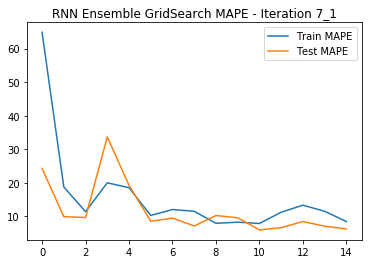

Epoch 1/80
69/69 [==============================] - 3s 49ms/step - loss: 15211596800.0000 - mean_absolute_percentage_error: 87.5772 - val_loss: 1056215616.0000 - val_mean_absolute_percentage_error: 29.0646
Epoch 2/80
69/69 [==============================] - 3s 43ms/step - loss: 3724547328.0000 - mean_absolute_percentage_error: 57.6973 - val_loss: 2536265728.0000 - val_mean_absolute_percentage_error: 51.7182
Epoch 3/80
69/69 [==============================] - 3s 43ms/step - loss: 519001760.0000 - mean_absolute_percentage_error: 18.9860 - val_loss: 227161376.0000 - val_mean_absolute_percentage_error: 13.0711
Epoch 4/80
69/69 [==============================] - 3s 43ms/step - loss: 229528480.0000 - mean_absolute_percentage_error: 13.0158 - val_loss: 139823376.0000 - val_mean_absolute_percentage_error: 10.6101
Epoch 5/80
69/69 [==============================] - 3s 43ms/step - loss: 173519472.0000 - mean_absolute_percentage_error: 11.2818 - val_loss: 133359072.0000 - val_mean_absolute_percen

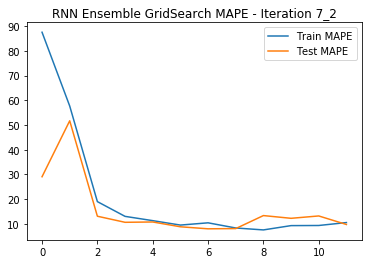

Epoch 1/80
69/69 [==============================] - 3s 49ms/step - loss: 15775435776.0000 - mean_absolute_percentage_error: 91.1051 - val_loss: 1417324928.0000 - val_mean_absolute_percentage_error: 32.7998
Epoch 2/80
69/69 [==============================] - 3s 43ms/step - loss: 1282803072.0000 - mean_absolute_percentage_error: 28.2300 - val_loss: 356961728.0000 - val_mean_absolute_percentage_error: 15.2395
Epoch 3/80
69/69 [==============================] - 3s 42ms/step - loss: 387354080.0000 - mean_absolute_percentage_error: 16.9543 - val_loss: 300735808.0000 - val_mean_absolute_percentage_error: 15.8937
Epoch 4/80
69/69 [==============================] - 3s 43ms/step - loss: 220967392.0000 - mean_absolute_percentage_error: 12.7672 - val_loss: 166058160.0000 - val_mean_absolute_percentage_error: 10.6350
Epoch 5/80
69/69 [==============================] - 3s 42ms/step - loss: 194751104.0000 - mean_absolute_percentage_error: 11.8585 - val_loss: 318567168.0000 - val_mean_absolute_percent

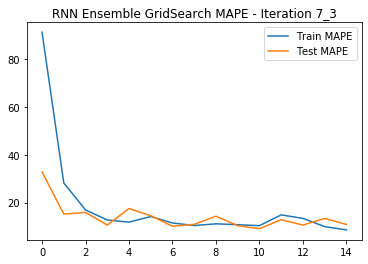

Epoch 1/80
69/69 [==============================] - 4s 51ms/step - loss: 7577960448.0000 - mean_absolute_percentage_error: 91.2376 - val_loss: 7914167296.0000 - val_mean_absolute_percentage_error: 97.3534
Epoch 2/80
69/69 [==============================] - 3s 46ms/step - loss: 6804460032.0000 - mean_absolute_percentage_error: 83.6492 - val_loss: 2500444672.0000 - val_mean_absolute_percentage_error: 48.6107
Epoch 3/80
69/69 [==============================] - 3s 47ms/step - loss: 2683738880.0000 - mean_absolute_percentage_error: 47.2859 - val_loss: 571378944.0000 - val_mean_absolute_percentage_error: 20.3469
Epoch 4/80
69/69 [==============================] - 3s 46ms/step - loss: 1360750208.0000 - mean_absolute_percentage_error: 32.3923 - val_loss: 379080224.0000 - val_mean_absolute_percentage_error: 16.7050
Epoch 5/80
69/69 [==============================] - 3s 47ms/step - loss: 218318448.0000 - mean_absolute_percentage_error: 12.3142 - val_loss: 144182736.0000 - val_mean_absolute_perce

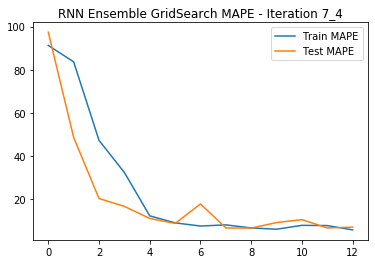

seq_length              12.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            3.000
learning_rate            0.001
epochs                  40.000
Name: 8, dtype: float64
Epoch 1/40
69/69 [==============================] - 4s 53ms/step - loss: 5540664832.0000 - mean_absolute_percentage_error: 75.4747 - val_loss: 1546088064.0000 - val_mean_absolute_percentage_error: 39.8626
Epoch 2/40
69/69 [==============================] - 3s 47ms/step - loss: 1605326464.0000 - mean_absolute_percentage_error: 36.0918 - val_loss: 345682848.0000 - val_mean_absolute_percentage_error: 16.2322
Epoch 3/40
69/69 [==============================] - 3s 47ms/step - loss: 1067681408.0000 - mean_absolute_percentage_error: 29.2716 - val_loss: 743541248.0000 - val_mean_absolute_percentage_error: 26.4147
Epoch 4/40
69/69 [==============================] - 3

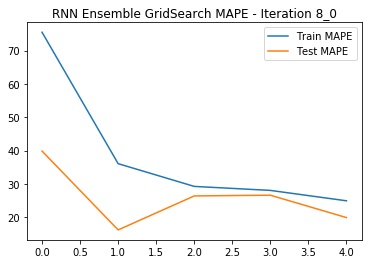

Epoch 1/40
69/69 [==============================] - 4s 52ms/step - loss: 5534319104.0000 - mean_absolute_percentage_error: 74.0358 - val_loss: 667212160.0000 - val_mean_absolute_percentage_error: 23.8536
Epoch 2/40
69/69 [==============================] - 3s 45ms/step - loss: 1458213760.0000 - mean_absolute_percentage_error: 34.1964 - val_loss: 162851552.0000 - val_mean_absolute_percentage_error: 10.6505
Epoch 3/40
69/69 [==============================] - 3s 46ms/step - loss: 1077059968.0000 - mean_absolute_percentage_error: 29.2945 - val_loss: 330604192.0000 - val_mean_absolute_percentage_error: 16.2240
Epoch 4/40
69/69 [==============================] - 3s 46ms/step - loss: 766128256.0000 - mean_absolute_percentage_error: 24.3606 - val_loss: 439437760.0000 - val_mean_absolute_percentage_error: 19.4819
Epoch 5/40
69/69 [==============================] - 3s 45ms/step - loss: 722308544.0000 - mean_absolute_percentage_error: 23.6602 - val_loss: 373600320.0000 - val_mean_absolute_percenta

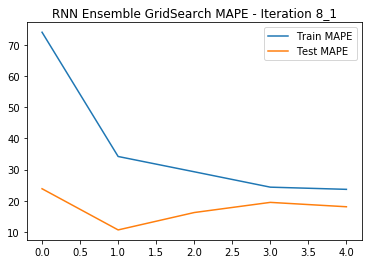

Epoch 1/40
69/69 [==============================] - 4s 55ms/step - loss: 6126415872.0000 - mean_absolute_percentage_error: 79.9859 - val_loss: 2047259392.0000 - val_mean_absolute_percentage_error: 45.1290
Epoch 2/40
69/69 [==============================] - 3s 48ms/step - loss: 1805890560.0000 - mean_absolute_percentage_error: 38.7173 - val_loss: 369794400.0000 - val_mean_absolute_percentage_error: 16.6021
Epoch 3/40
69/69 [==============================] - 3s 47ms/step - loss: 1085980032.0000 - mean_absolute_percentage_error: 29.2002 - val_loss: 489972288.0000 - val_mean_absolute_percentage_error: 20.2909
Epoch 4/40
69/69 [==============================] - 3s 48ms/step - loss: 948460864.0000 - mean_absolute_percentage_error: 27.4078 - val_loss: 161644736.0000 - val_mean_absolute_percentage_error: 11.1977
Epoch 5/40
69/69 [==============================] - 3s 48ms/step - loss: 700811904.0000 - mean_absolute_percentage_error: 23.3507 - val_loss: 411322176.0000 - val_mean_absolute_percent

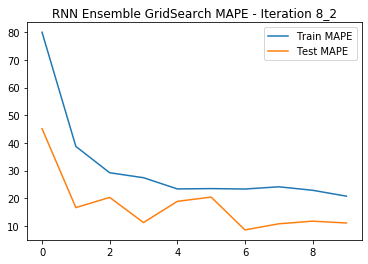

Epoch 1/40
69/69 [==============================] - 4s 53ms/step - loss: 6181743616.0000 - mean_absolute_percentage_error: 79.9752 - val_loss: 2157596416.0000 - val_mean_absolute_percentage_error: 47.5558
Epoch 2/40
69/69 [==============================] - 3s 47ms/step - loss: 1705464192.0000 - mean_absolute_percentage_error: 37.2931 - val_loss: 446658752.0000 - val_mean_absolute_percentage_error: 18.4047
Epoch 3/40
69/69 [==============================] - 3s 46ms/step - loss: 1256581120.0000 - mean_absolute_percentage_error: 31.2607 - val_loss: 806726656.0000 - val_mean_absolute_percentage_error: 28.0931
Epoch 4/40
69/69 [==============================] - 3s 46ms/step - loss: 1073662784.0000 - mean_absolute_percentage_error: 29.0363 - val_loss: 449296960.0000 - val_mean_absolute_percentage_error: 19.5491
Epoch 5/40
69/69 [==============================] - 3s 46ms/step - loss: 947570304.0000 - mean_absolute_percentage_error: 27.1497 - val_loss: 439449344.0000 - val_mean_absolute_percen

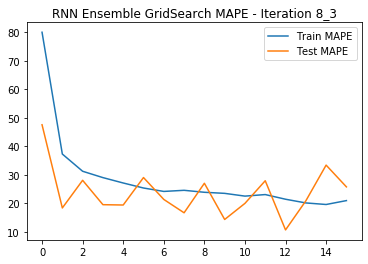

Epoch 1/40
69/69 [==============================] - 3s 50ms/step - loss: 5045646848.0000 - mean_absolute_percentage_error: 68.2976 - val_loss: 1178597376.0000 - val_mean_absolute_percentage_error: 33.0585
Epoch 2/40
69/69 [==============================] - 3s 45ms/step - loss: 1235578112.0000 - mean_absolute_percentage_error: 31.5189 - val_loss: 202644272.0000 - val_mean_absolute_percentage_error: 12.4741
Epoch 3/40
69/69 [==============================] - 3s 45ms/step - loss: 1030690432.0000 - mean_absolute_percentage_error: 28.3083 - val_loss: 194890384.0000 - val_mean_absolute_percentage_error: 12.4478
Epoch 4/40
69/69 [==============================] - 3s 46ms/step - loss: 915138304.0000 - mean_absolute_percentage_error: 26.9461 - val_loss: 455556544.0000 - val_mean_absolute_percentage_error: 20.7257
Epoch 5/40
69/69 [==============================] - 3s 44ms/step - loss: 881386112.0000 - mean_absolute_percentage_error: 26.0217 - val_loss: 117722728.0000 - val_mean_absolute_percent

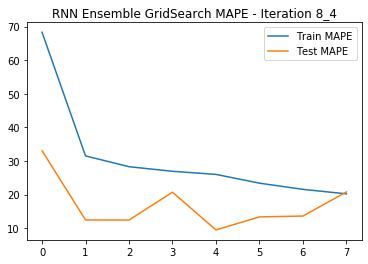

seq_length              12.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            3.000
learning_rate            0.001
epochs                  80.000
Name: 9, dtype: float64
Epoch 1/80
69/69 [==============================] - 3s 50ms/step - loss: 5540664832.0000 - mean_absolute_percentage_error: 75.4747 - val_loss: 1546088064.0000 - val_mean_absolute_percentage_error: 39.8626
Epoch 2/80
69/69 [==============================] - 3s 45ms/step - loss: 1605326464.0000 - mean_absolute_percentage_error: 36.0918 - val_loss: 345682848.0000 - val_mean_absolute_percentage_error: 16.2322
Epoch 3/80
69/69 [==============================] - 3s 45ms/step - loss: 1067681408.0000 - mean_absolute_percentage_error: 29.2716 - val_loss: 743541248.0000 - val_mean_absolute_percentage_error: 26.4147
Epoch 4/80
69/69 [==============================] - 3

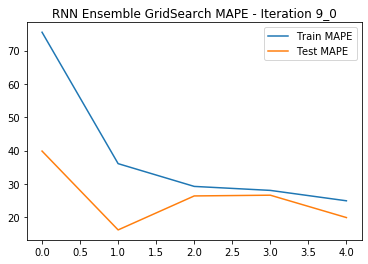

Epoch 1/80
69/69 [==============================] - 3s 49ms/step - loss: 5534319104.0000 - mean_absolute_percentage_error: 74.0358 - val_loss: 667212160.0000 - val_mean_absolute_percentage_error: 23.8536
Epoch 2/80
69/69 [==============================] - 3s 44ms/step - loss: 1458213760.0000 - mean_absolute_percentage_error: 34.1964 - val_loss: 162851552.0000 - val_mean_absolute_percentage_error: 10.6505
Epoch 3/80
69/69 [==============================] - 3s 45ms/step - loss: 1077059968.0000 - mean_absolute_percentage_error: 29.2945 - val_loss: 330604192.0000 - val_mean_absolute_percentage_error: 16.2240
Epoch 4/80
69/69 [==============================] - 3s 44ms/step - loss: 766128256.0000 - mean_absolute_percentage_error: 24.3606 - val_loss: 439437760.0000 - val_mean_absolute_percentage_error: 19.4819
Epoch 5/80
69/69 [==============================] - 3s 45ms/step - loss: 722308544.0000 - mean_absolute_percentage_error: 23.6602 - val_loss: 373600320.0000 - val_mean_absolute_percenta

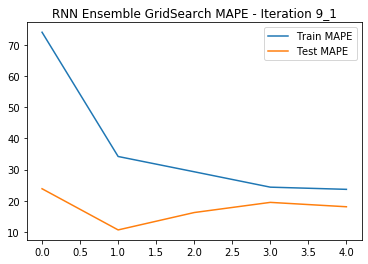

Epoch 1/80
69/69 [==============================] - 4s 56ms/step - loss: 6126415872.0000 - mean_absolute_percentage_error: 79.9859 - val_loss: 2047259392.0000 - val_mean_absolute_percentage_error: 45.1290
Epoch 2/80
69/69 [==============================] - 3s 50ms/step - loss: 1805890560.0000 - mean_absolute_percentage_error: 38.7173 - val_loss: 369794400.0000 - val_mean_absolute_percentage_error: 16.6021
Epoch 3/80
69/69 [==============================] - 3s 49ms/step - loss: 1085980032.0000 - mean_absolute_percentage_error: 29.2002 - val_loss: 489972288.0000 - val_mean_absolute_percentage_error: 20.2909
Epoch 4/80
69/69 [==============================] - 3s 49ms/step - loss: 948460864.0000 - mean_absolute_percentage_error: 27.4078 - val_loss: 161644736.0000 - val_mean_absolute_percentage_error: 11.1977
Epoch 5/80
69/69 [==============================] - 3s 49ms/step - loss: 700811904.0000 - mean_absolute_percentage_error: 23.3507 - val_loss: 411322176.0000 - val_mean_absolute_percent

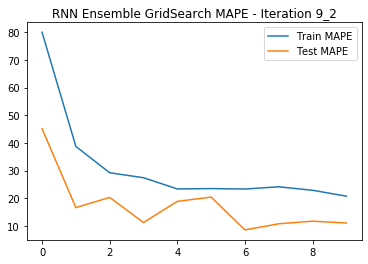

Epoch 1/80
69/69 [==============================] - 4s 53ms/step - loss: 6181743616.0000 - mean_absolute_percentage_error: 79.9752 - val_loss: 2157596416.0000 - val_mean_absolute_percentage_error: 47.5558
Epoch 2/80
69/69 [==============================] - 3s 47ms/step - loss: 1705464192.0000 - mean_absolute_percentage_error: 37.2931 - val_loss: 446658752.0000 - val_mean_absolute_percentage_error: 18.4047
Epoch 3/80
69/69 [==============================] - 3s 47ms/step - loss: 1256581120.0000 - mean_absolute_percentage_error: 31.2607 - val_loss: 806726656.0000 - val_mean_absolute_percentage_error: 28.0931
Epoch 4/80
69/69 [==============================] - 3s 47ms/step - loss: 1073662784.0000 - mean_absolute_percentage_error: 29.0363 - val_loss: 449296960.0000 - val_mean_absolute_percentage_error: 19.5491
Epoch 5/80
69/69 [==============================] - 3s 47ms/step - loss: 947570304.0000 - mean_absolute_percentage_error: 27.1497 - val_loss: 439449344.0000 - val_mean_absolute_percen

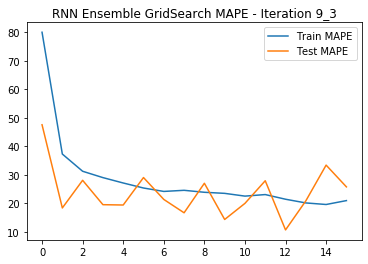

Epoch 1/80
69/69 [==============================] - 4s 52ms/step - loss: 5045646848.0000 - mean_absolute_percentage_error: 68.2976 - val_loss: 1178597376.0000 - val_mean_absolute_percentage_error: 33.0585
Epoch 2/80
69/69 [==============================] - 3s 46ms/step - loss: 1235578112.0000 - mean_absolute_percentage_error: 31.5189 - val_loss: 202644272.0000 - val_mean_absolute_percentage_error: 12.4741
Epoch 3/80
69/69 [==============================] - 3s 46ms/step - loss: 1030690432.0000 - mean_absolute_percentage_error: 28.3083 - val_loss: 194890384.0000 - val_mean_absolute_percentage_error: 12.4478
Epoch 4/80
69/69 [==============================] - 3s 46ms/step - loss: 915138304.0000 - mean_absolute_percentage_error: 26.9461 - val_loss: 455556544.0000 - val_mean_absolute_percentage_error: 20.7257
Epoch 5/80
69/69 [==============================] - 3s 44ms/step - loss: 881386112.0000 - mean_absolute_percentage_error: 26.0217 - val_loss: 117722728.0000 - val_mean_absolute_percent

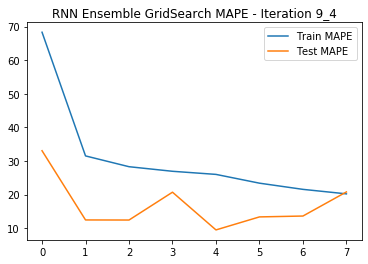

seq_length              12.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.20
stop_patience            3.00
learning_rate            0.01
epochs                  40.00
Name: 10, dtype: float64
Epoch 1/40
69/69 [==============================] - 4s 63ms/step - loss: 5861170688.0000 - mean_absolute_percentage_error: 78.0361 - val_loss: 4447370240.0000 - val_mean_absolute_percentage_error: 70.5136
Epoch 2/40
69/69 [==============================] - 3s 51ms/step - loss: 6502194688.0000 - mean_absolute_percentage_error: 82.5111 - val_loss: 6222489088.0000 - val_mean_absolute_percentage_error: 85.6686
Epoch 3/40
69/69 [==============================] - 3s 51ms/step - loss: 24248684544.0000 - mean_absolute_percentage_error: 97.8956 - val_loss: 7925526016.0000 - val_mean_absolute_percentage_error: 97.2300
Epoch 4/40
69/69 [==============================] - 4s 51ms

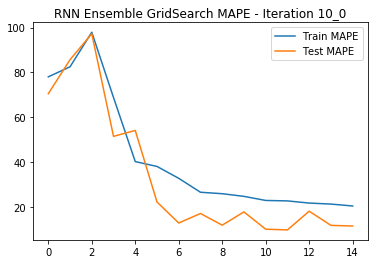

Epoch 1/40
69/69 [==============================] - 4s 53ms/step - loss: 8601622528.0000 - mean_absolute_percentage_error: 92.2384 - val_loss: 8133335552.0000 - val_mean_absolute_percentage_error: 98.6811
Epoch 2/40
69/69 [==============================] - 3s 47ms/step - loss: 7378514432.0000 - mean_absolute_percentage_error: 88.2875 - val_loss: 8011201024.0000 - val_mean_absolute_percentage_error: 97.9137
Epoch 3/40
69/69 [==============================] - 3s 47ms/step - loss: 8092382208.0000 - mean_absolute_percentage_error: 95.7610 - val_loss: 8246221824.0000 - val_mean_absolute_percentage_error: 99.3917
Epoch 4/40
69/69 [==============================] - 3s 48ms/step - loss: 5564536320.0000 - mean_absolute_percentage_error: 74.5461 - val_loss: 1229751552.0000 - val_mean_absolute_percentage_error: 29.7037
Epoch 5/40
69/69 [==============================] - 3s 48ms/step - loss: 2079955584.0000 - mean_absolute_percentage_error: 40.6623 - val_loss: 460412896.0000 - val_mean_absolute_pe

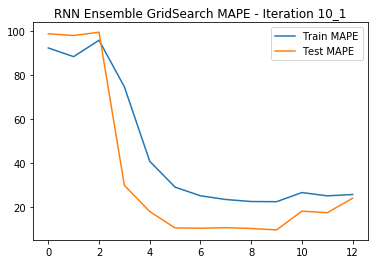

Epoch 1/40
69/69 [==============================] - 4s 52ms/step - loss: 7147617792.0000 - mean_absolute_percentage_error: 85.1952 - val_loss: 1754850432.0000 - val_mean_absolute_percentage_error: 38.7403
Epoch 2/40
69/69 [==============================] - 3s 46ms/step - loss: 1927906816.0000 - mean_absolute_percentage_error: 39.6578 - val_loss: 749350784.0000 - val_mean_absolute_percentage_error: 24.4306
Epoch 3/40
69/69 [==============================] - 3s 46ms/step - loss: 724215232.0000 - mean_absolute_percentage_error: 23.7529 - val_loss: 1001014912.0000 - val_mean_absolute_percentage_error: 31.2526
Epoch 4/40
69/69 [==============================] - 3s 46ms/step - loss: 627350656.0000 - mean_absolute_percentage_error: 21.7715 - val_loss: 125126728.0000 - val_mean_absolute_percentage_error: 9.1298
Epoch 5/40
69/69 [==============================] - 3s 46ms/step - loss: 538712896.0000 - mean_absolute_percentage_error: 20.1357 - val_loss: 172042464.0000 - val_mean_absolute_percenta

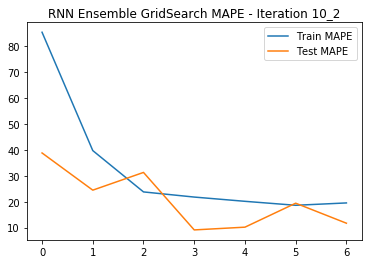

Epoch 1/40
69/69 [==============================] - 4s 52ms/step - loss: 6098444288.0000 - mean_absolute_percentage_error: 76.0256 - val_loss: 2904518144.0000 - val_mean_absolute_percentage_error: 55.7801
Epoch 2/40
69/69 [==============================] - 3s 46ms/step - loss: 6202845184.0000 - mean_absolute_percentage_error: 79.6851 - val_loss: 1519452544.0000 - val_mean_absolute_percentage_error: 37.2425
Epoch 3/40
69/69 [==============================] - 3s 46ms/step - loss: 1566801408.0000 - mean_absolute_percentage_error: 35.0566 - val_loss: 292703552.0000 - val_mean_absolute_percentage_error: 16.3824
Epoch 4/40
69/69 [==============================] - 3s 46ms/step - loss: 613597760.0000 - mean_absolute_percentage_error: 21.6289 - val_loss: 349718976.0000 - val_mean_absolute_percentage_error: 16.9907
Epoch 5/40
69/69 [==============================] - 3s 46ms/step - loss: 565072384.0000 - mean_absolute_percentage_error: 20.7115 - val_loss: 556064064.0000 - val_mean_absolute_percen

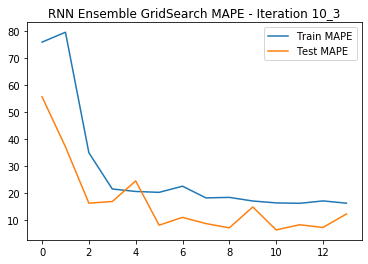

Epoch 1/40
69/69 [==============================] - 4s 60ms/step - loss: 8766991360.0000 - mean_absolute_percentage_error: 96.3684 - val_loss: 6664933888.0000 - val_mean_absolute_percentage_error: 88.3353
Epoch 2/40
69/69 [==============================] - 4s 54ms/step - loss: 2408201472.0000 - mean_absolute_percentage_error: 45.0787 - val_loss: 760081088.0000 - val_mean_absolute_percentage_error: 23.6759
Epoch 3/40
69/69 [==============================] - 4s 53ms/step - loss: 1240302336.0000 - mean_absolute_percentage_error: 30.2940 - val_loss: 880189184.0000 - val_mean_absolute_percentage_error: 27.3113
Epoch 4/40
69/69 [==============================] - 4s 54ms/step - loss: 650568512.0000 - mean_absolute_percentage_error: 22.3229 - val_loss: 182553008.0000 - val_mean_absolute_percentage_error: 11.8937
Epoch 5/40
69/69 [==============================] - 4s 53ms/step - loss: 526738560.0000 - mean_absolute_percentage_error: 19.9668 - val_loss: 232205952.0000 - val_mean_absolute_percent

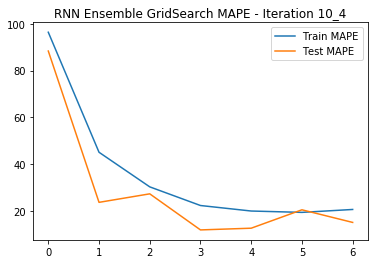

seq_length              12.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.20
stop_patience            3.00
learning_rate            0.01
epochs                  80.00
Name: 11, dtype: float64
Epoch 1/80
69/69 [==============================] - 4s 59ms/step - loss: 5861170688.0000 - mean_absolute_percentage_error: 78.0361 - val_loss: 4447370240.0000 - val_mean_absolute_percentage_error: 70.5136
Epoch 2/80
69/69 [==============================] - 4s 55ms/step - loss: 6502194688.0000 - mean_absolute_percentage_error: 82.5111 - val_loss: 6222489088.0000 - val_mean_absolute_percentage_error: 85.6686
Epoch 3/80
69/69 [==============================] - 4s 56ms/step - loss: 24248684544.0000 - mean_absolute_percentage_error: 97.8956 - val_loss: 7925526016.0000 - val_mean_absolute_percentage_error: 97.2300
Epoch 4/80
69/69 [==============================] - 4s 55ms

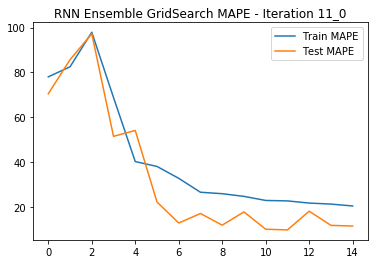

Epoch 1/80
69/69 [==============================] - 4s 58ms/step - loss: 8601622528.0000 - mean_absolute_percentage_error: 92.2384 - val_loss: 8133335552.0000 - val_mean_absolute_percentage_error: 98.6811
Epoch 2/80
69/69 [==============================] - 3s 50ms/step - loss: 7378514432.0000 - mean_absolute_percentage_error: 88.2875 - val_loss: 8011201024.0000 - val_mean_absolute_percentage_error: 97.9137
Epoch 3/80
69/69 [==============================] - 4s 51ms/step - loss: 8092382208.0000 - mean_absolute_percentage_error: 95.7610 - val_loss: 8246221824.0000 - val_mean_absolute_percentage_error: 99.3917
Epoch 4/80
69/69 [==============================] - 4s 52ms/step - loss: 5564536320.0000 - mean_absolute_percentage_error: 74.5461 - val_loss: 1229751552.0000 - val_mean_absolute_percentage_error: 29.7037
Epoch 5/80
69/69 [==============================] - 3s 51ms/step - loss: 2079955584.0000 - mean_absolute_percentage_error: 40.6623 - val_loss: 460412896.0000 - val_mean_absolute_pe

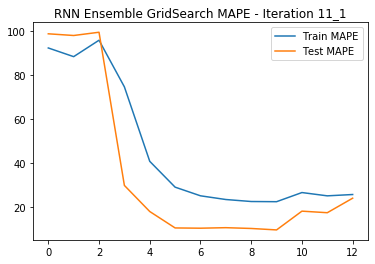

Epoch 1/80
69/69 [==============================] - 4s 59ms/step - loss: 7147617792.0000 - mean_absolute_percentage_error: 85.1952 - val_loss: 1754850432.0000 - val_mean_absolute_percentage_error: 38.7403
Epoch 2/80
69/69 [==============================] - 4s 53ms/step - loss: 1927906816.0000 - mean_absolute_percentage_error: 39.6578 - val_loss: 749350784.0000 - val_mean_absolute_percentage_error: 24.4306
Epoch 3/80
69/69 [==============================] - 4s 53ms/step - loss: 724215232.0000 - mean_absolute_percentage_error: 23.7529 - val_loss: 1001014912.0000 - val_mean_absolute_percentage_error: 31.2526
Epoch 4/80
69/69 [==============================] - 4s 53ms/step - loss: 627350656.0000 - mean_absolute_percentage_error: 21.7715 - val_loss: 125126728.0000 - val_mean_absolute_percentage_error: 9.1298
Epoch 5/80
69/69 [==============================] - 4s 53ms/step - loss: 538712896.0000 - mean_absolute_percentage_error: 20.1357 - val_loss: 172042464.0000 - val_mean_absolute_percenta

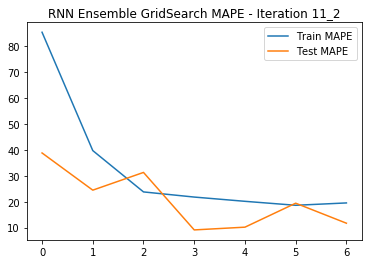

Epoch 1/80
69/69 [==============================] - 4s 56ms/step - loss: 6098444288.0000 - mean_absolute_percentage_error: 76.0256 - val_loss: 2904518144.0000 - val_mean_absolute_percentage_error: 55.7801
Epoch 2/80
69/69 [==============================] - 3s 50ms/step - loss: 6202845184.0000 - mean_absolute_percentage_error: 79.6851 - val_loss: 1519452544.0000 - val_mean_absolute_percentage_error: 37.2425
Epoch 3/80
69/69 [==============================] - 3s 50ms/step - loss: 1566801408.0000 - mean_absolute_percentage_error: 35.0566 - val_loss: 292703552.0000 - val_mean_absolute_percentage_error: 16.3824
Epoch 4/80
69/69 [==============================] - 3s 50ms/step - loss: 613597760.0000 - mean_absolute_percentage_error: 21.6289 - val_loss: 349718976.0000 - val_mean_absolute_percentage_error: 16.9907
Epoch 5/80
69/69 [==============================] - 3s 49ms/step - loss: 565072384.0000 - mean_absolute_percentage_error: 20.7115 - val_loss: 556064064.0000 - val_mean_absolute_percen

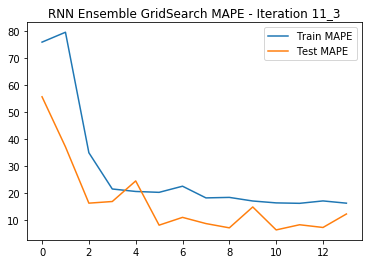

Epoch 1/80
69/69 [==============================] - 4s 52ms/step - loss: 8766991360.0000 - mean_absolute_percentage_error: 96.3684 - val_loss: 6664933888.0000 - val_mean_absolute_percentage_error: 88.3353
Epoch 2/80
69/69 [==============================] - 3s 47ms/step - loss: 2408201472.0000 - mean_absolute_percentage_error: 45.0787 - val_loss: 760081088.0000 - val_mean_absolute_percentage_error: 23.6759
Epoch 3/80
69/69 [==============================] - 3s 46ms/step - loss: 1240302336.0000 - mean_absolute_percentage_error: 30.2940 - val_loss: 880189184.0000 - val_mean_absolute_percentage_error: 27.3113
Epoch 4/80
69/69 [==============================] - 3s 46ms/step - loss: 650568512.0000 - mean_absolute_percentage_error: 22.3229 - val_loss: 182553008.0000 - val_mean_absolute_percentage_error: 11.8937
Epoch 5/80
69/69 [==============================] - 3s 46ms/step - loss: 526738560.0000 - mean_absolute_percentage_error: 19.9668 - val_loss: 232205952.0000 - val_mean_absolute_percent

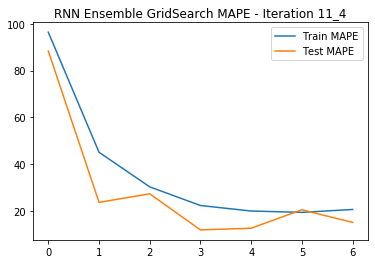

seq_length              12.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            4.000
learning_rate            0.001
epochs                  40.000
Name: 12, dtype: float64
Epoch 1/40
69/69 [==============================] - 4s 58ms/step - loss: 5540664832.0000 - mean_absolute_percentage_error: 75.4747 - val_loss: 1546088064.0000 - val_mean_absolute_percentage_error: 39.8626
Epoch 2/40
69/69 [==============================] - 4s 52ms/step - loss: 1605326464.0000 - mean_absolute_percentage_error: 36.0918 - val_loss: 345682848.0000 - val_mean_absolute_percentage_error: 16.2322
Epoch 3/40
69/69 [==============================] - 4s 52ms/step - loss: 1067681408.0000 - mean_absolute_percentage_error: 29.2716 - val_loss: 743541248.0000 - val_mean_absolute_percentage_error: 26.4147
Epoch 4/40
69/69 [==============================] - 

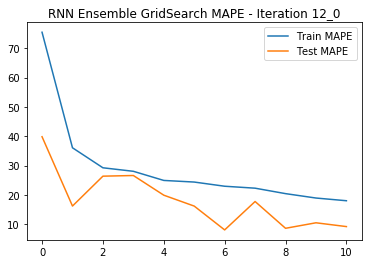

Epoch 1/40
69/69 [==============================] - 4s 56ms/step - loss: 5668544000.0000 - mean_absolute_percentage_error: 75.9913 - val_loss: 441060768.0000 - val_mean_absolute_percentage_error: 18.5158
Epoch 2/40
69/69 [==============================] - 3s 50ms/step - loss: 1335178752.0000 - mean_absolute_percentage_error: 32.8669 - val_loss: 846616448.0000 - val_mean_absolute_percentage_error: 28.4489
Epoch 3/40
69/69 [==============================] - 3s 49ms/step - loss: 1066532480.0000 - mean_absolute_percentage_error: 29.0130 - val_loss: 500837440.0000 - val_mean_absolute_percentage_error: 20.5996
Epoch 4/40
69/69 [==============================] - 3s 49ms/step - loss: 966518912.0000 - mean_absolute_percentage_error: 27.7221 - val_loss: 824378176.0000 - val_mean_absolute_percentage_error: 28.1678
Epoch 5/40
69/69 [==============================] - 3s 49ms/step - loss: 897830784.0000 - mean_absolute_percentage_error: 26.6552 - val_loss: 711369984.0000 - val_mean_absolute_percenta

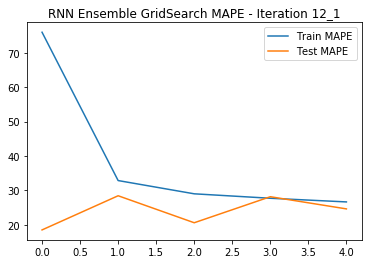

Epoch 1/40
69/69 [==============================] - 4s 54ms/step - loss: 5524087808.0000 - mean_absolute_percentage_error: 74.2042 - val_loss: 515646848.0000 - val_mean_absolute_percentage_error: 19.6993
Epoch 2/40
69/69 [==============================] - 3s 47ms/step - loss: 1483359104.0000 - mean_absolute_percentage_error: 34.5953 - val_loss: 383198720.0000 - val_mean_absolute_percentage_error: 16.6448
Epoch 3/40
69/69 [==============================] - 3s 48ms/step - loss: 923800512.0000 - mean_absolute_percentage_error: 26.8934 - val_loss: 430928800.0000 - val_mean_absolute_percentage_error: 18.7590
Epoch 4/40
69/69 [==============================] - 3s 47ms/step - loss: 857399040.0000 - mean_absolute_percentage_error: 25.9227 - val_loss: 425504768.0000 - val_mean_absolute_percentage_error: 19.1036
Epoch 5/40
69/69 [==============================] - 3s 47ms/step - loss: 931220800.0000 - mean_absolute_percentage_error: 27.2111 - val_loss: 529434880.0000 - val_mean_absolute_percentag

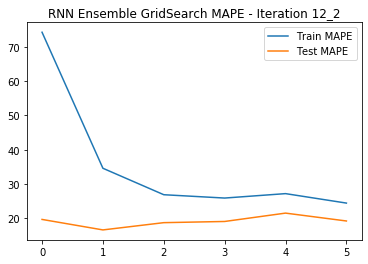

Epoch 1/40
69/69 [==============================] - 4s 65ms/step - loss: 5997582336.0000 - mean_absolute_percentage_error: 78.2122 - val_loss: 2269443072.0000 - val_mean_absolute_percentage_error: 49.9827
Epoch 2/40
69/69 [==============================] - 4s 52ms/step - loss: 1700124288.0000 - mean_absolute_percentage_error: 36.0223 - val_loss: 511473056.0000 - val_mean_absolute_percentage_error: 21.0042
Epoch 3/40
69/69 [==============================] - 4s 52ms/step - loss: 1318932608.0000 - mean_absolute_percentage_error: 32.2037 - val_loss: 1214981632.0000 - val_mean_absolute_percentage_error: 36.0449
Epoch 4/40
69/69 [==============================] - 4s 52ms/step - loss: 1135496320.0000 - mean_absolute_percentage_error: 29.8208 - val_loss: 929947712.0000 - val_mean_absolute_percentage_error: 31.0103
Epoch 5/40
69/69 [==============================] - 4s 52ms/step - loss: 982036544.0000 - mean_absolute_percentage_error: 27.5999 - val_loss: 428753344.0000 - val_mean_absolute_perce

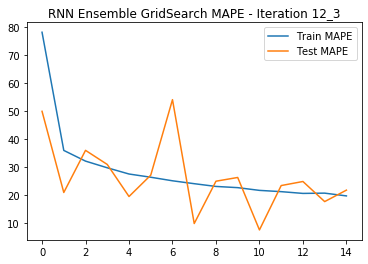

Epoch 1/40
69/69 [==============================] - 4s 57ms/step - loss: 5461957632.0000 - mean_absolute_percentage_error: 72.4626 - val_loss: 544954368.0000 - val_mean_absolute_percentage_error: 20.8805
Epoch 2/40
69/69 [==============================] - 4s 51ms/step - loss: 1160690560.0000 - mean_absolute_percentage_error: 30.4172 - val_loss: 209224800.0000 - val_mean_absolute_percentage_error: 12.0041
Epoch 3/40
69/69 [==============================] - 3s 50ms/step - loss: 954294272.0000 - mean_absolute_percentage_error: 27.6201 - val_loss: 161423888.0000 - val_mean_absolute_percentage_error: 11.1476
Epoch 4/40
69/69 [==============================] - 4s 51ms/step - loss: 885251136.0000 - mean_absolute_percentage_error: 26.2660 - val_loss: 149293376.0000 - val_mean_absolute_percentage_error: 10.1825
Epoch 5/40
69/69 [==============================] - 4s 51ms/step - loss: 738940096.0000 - mean_absolute_percentage_error: 24.0779 - val_loss: 232688688.0000 - val_mean_absolute_percentag

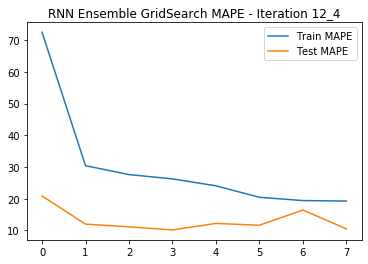

seq_length              12.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            4.000
learning_rate            0.001
epochs                  80.000
Name: 13, dtype: float64
Epoch 1/80
69/69 [==============================] - 4s 57ms/step - loss: 5540664832.0000 - mean_absolute_percentage_error: 75.4747 - val_loss: 1546088064.0000 - val_mean_absolute_percentage_error: 39.8626
Epoch 2/80
69/69 [==============================] - 4s 51ms/step - loss: 1605326464.0000 - mean_absolute_percentage_error: 36.0918 - val_loss: 345682848.0000 - val_mean_absolute_percentage_error: 16.2322
Epoch 3/80
69/69 [==============================] - 4s 51ms/step - loss: 1067681408.0000 - mean_absolute_percentage_error: 29.2716 - val_loss: 743541248.0000 - val_mean_absolute_percentage_error: 26.4147
Epoch 4/80
69/69 [==============================] - 

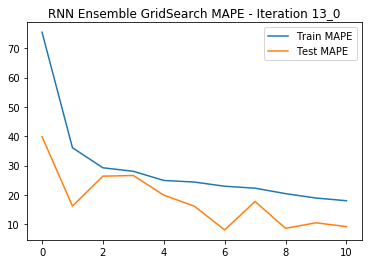

Epoch 1/80
69/69 [==============================] - 4s 56ms/step - loss: 5668544000.0000 - mean_absolute_percentage_error: 75.9913 - val_loss: 441060768.0000 - val_mean_absolute_percentage_error: 18.5158
Epoch 2/80
69/69 [==============================] - 3s 49ms/step - loss: 1335178752.0000 - mean_absolute_percentage_error: 32.8669 - val_loss: 846616448.0000 - val_mean_absolute_percentage_error: 28.4489
Epoch 3/80
69/69 [==============================] - 3s 49ms/step - loss: 1066532480.0000 - mean_absolute_percentage_error: 29.0130 - val_loss: 500837440.0000 - val_mean_absolute_percentage_error: 20.5996
Epoch 4/80
69/69 [==============================] - 3s 48ms/step - loss: 966518912.0000 - mean_absolute_percentage_error: 27.7221 - val_loss: 824378176.0000 - val_mean_absolute_percentage_error: 28.1678
Epoch 5/80
69/69 [==============================] - 3s 49ms/step - loss: 897830784.0000 - mean_absolute_percentage_error: 26.6552 - val_loss: 711369984.0000 - val_mean_absolute_percenta

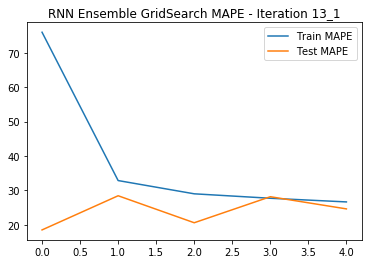

Epoch 1/80
69/69 [==============================] - 4s 60ms/step - loss: 5524087808.0000 - mean_absolute_percentage_error: 74.2042 - val_loss: 515646848.0000 - val_mean_absolute_percentage_error: 19.6993
Epoch 2/80
69/69 [==============================] - 4s 54ms/step - loss: 1483359104.0000 - mean_absolute_percentage_error: 34.5953 - val_loss: 383198720.0000 - val_mean_absolute_percentage_error: 16.6448
Epoch 3/80
69/69 [==============================] - 4s 54ms/step - loss: 923800512.0000 - mean_absolute_percentage_error: 26.8934 - val_loss: 430928800.0000 - val_mean_absolute_percentage_error: 18.7590
Epoch 4/80
69/69 [==============================] - 4s 53ms/step - loss: 857399040.0000 - mean_absolute_percentage_error: 25.9227 - val_loss: 425504768.0000 - val_mean_absolute_percentage_error: 19.1036
Epoch 5/80
69/69 [==============================] - 4s 54ms/step - loss: 931220800.0000 - mean_absolute_percentage_error: 27.2111 - val_loss: 529434880.0000 - val_mean_absolute_percentag

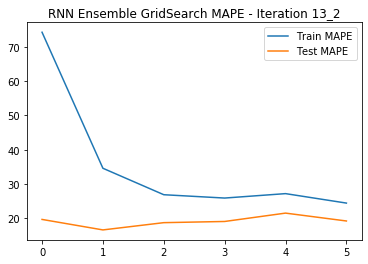

Epoch 1/80
69/69 [==============================] - 4s 59ms/step - loss: 5997582336.0000 - mean_absolute_percentage_error: 78.2122 - val_loss: 2269443072.0000 - val_mean_absolute_percentage_error: 49.9827
Epoch 2/80
69/69 [==============================] - 4s 51ms/step - loss: 1700124288.0000 - mean_absolute_percentage_error: 36.0223 - val_loss: 511473056.0000 - val_mean_absolute_percentage_error: 21.0042
Epoch 3/80
69/69 [==============================] - 4s 52ms/step - loss: 1318932608.0000 - mean_absolute_percentage_error: 32.2037 - val_loss: 1214981632.0000 - val_mean_absolute_percentage_error: 36.0449
Epoch 4/80
69/69 [==============================] - 4s 52ms/step - loss: 1135496320.0000 - mean_absolute_percentage_error: 29.8208 - val_loss: 929947712.0000 - val_mean_absolute_percentage_error: 31.0103
Epoch 5/80
69/69 [==============================] - 4s 52ms/step - loss: 982036544.0000 - mean_absolute_percentage_error: 27.5999 - val_loss: 428753344.0000 - val_mean_absolute_perce

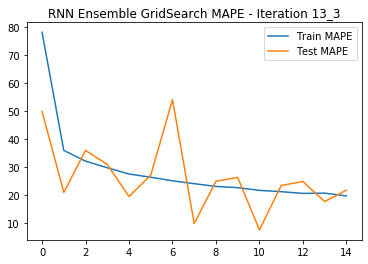

Epoch 1/80
69/69 [==============================] - 4s 56ms/step - loss: 5461957632.0000 - mean_absolute_percentage_error: 72.4626 - val_loss: 544954368.0000 - val_mean_absolute_percentage_error: 20.8805
Epoch 2/80
69/69 [==============================] - 3s 49ms/step - loss: 1160690560.0000 - mean_absolute_percentage_error: 30.4172 - val_loss: 209224800.0000 - val_mean_absolute_percentage_error: 12.0041
Epoch 3/80
69/69 [==============================] - 3s 48ms/step - loss: 954294272.0000 - mean_absolute_percentage_error: 27.6201 - val_loss: 161423888.0000 - val_mean_absolute_percentage_error: 11.1476
Epoch 4/80
69/69 [==============================] - 3s 49ms/step - loss: 885251136.0000 - mean_absolute_percentage_error: 26.2660 - val_loss: 149293376.0000 - val_mean_absolute_percentage_error: 10.1825
Epoch 5/80
69/69 [==============================] - 3s 49ms/step - loss: 738940096.0000 - mean_absolute_percentage_error: 24.0779 - val_loss: 232688688.0000 - val_mean_absolute_percentag

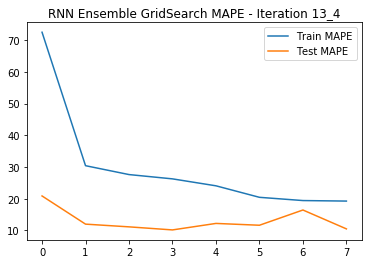

seq_length              12.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.20
stop_patience            4.00
learning_rate            0.01
epochs                  40.00
Name: 14, dtype: float64
Epoch 1/40
69/69 [==============================] - 4s 57ms/step - loss: 5861170688.0000 - mean_absolute_percentage_error: 78.0361 - val_loss: 4447370240.0000 - val_mean_absolute_percentage_error: 70.5136
Epoch 2/40
69/69 [==============================] - 3s 50ms/step - loss: 6502194688.0000 - mean_absolute_percentage_error: 82.5111 - val_loss: 6222489088.0000 - val_mean_absolute_percentage_error: 85.6686
Epoch 3/40
69/69 [==============================] - 4s 51ms/step - loss: 24248684544.0000 - mean_absolute_percentage_error: 97.8956 - val_loss: 7925526016.0000 - val_mean_absolute_percentage_error: 97.2300
Epoch 4/40
69/69 [==============================] - 3s 50ms

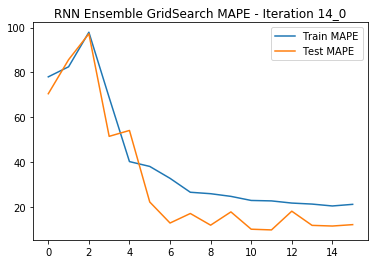

Epoch 1/40
69/69 [==============================] - 4s 61ms/step - loss: 5234322432.0000 - mean_absolute_percentage_error: 71.3498 - val_loss: 2458662400.0000 - val_mean_absolute_percentage_error: 51.7459
Epoch 2/40
69/69 [==============================] - 4s 54ms/step - loss: 1656565504.0000 - mean_absolute_percentage_error: 36.4500 - val_loss: 172203120.0000 - val_mean_absolute_percentage_error: 11.6564
Epoch 3/40
69/69 [==============================] - 4s 54ms/step - loss: 585580480.0000 - mean_absolute_percentage_error: 21.0761 - val_loss: 486838528.0000 - val_mean_absolute_percentage_error: 20.3693
Epoch 4/40
69/69 [==============================] - 4s 54ms/step - loss: 534265536.0000 - mean_absolute_percentage_error: 20.0746 - val_loss: 762075392.0000 - val_mean_absolute_percentage_error: 27.4725
Epoch 5/40
69/69 [==============================] - 4s 54ms/step - loss: 672785088.0000 - mean_absolute_percentage_error: 22.6232 - val_loss: 224340800.0000 - val_mean_absolute_percenta

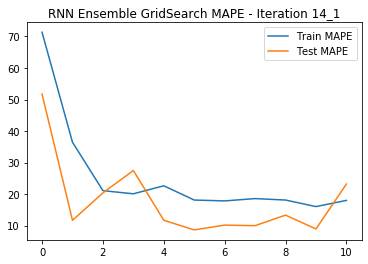

Epoch 1/40
69/69 [==============================] - 4s 60ms/step - loss: 9445192704.0000 - mean_absolute_percentage_error: 94.0884 - val_loss: 1943350784.0000 - val_mean_absolute_percentage_error: 39.6703
Epoch 2/40
69/69 [==============================] - 4s 54ms/step - loss: 80608575488.0000 - mean_absolute_percentage_error: 95.9251 - val_loss: 7637553152.0000 - val_mean_absolute_percentage_error: 95.4117
Epoch 3/40
69/69 [==============================] - 4s 53ms/step - loss: 4080520192.0000 - mean_absolute_percentage_error: 61.5719 - val_loss: 7072372224.0000 - val_mean_absolute_percentage_error: 91.6805
Epoch 4/40
69/69 [==============================] - 4s 53ms/step - loss: 6506209280.0000 - mean_absolute_percentage_error: 79.6469 - val_loss: 8043233792.0000 - val_mean_absolute_percentage_error: 98.0499
Epoch 5/40
69/69 [==============================] - 4s 53ms/step - loss: 8416294912.0000 - mean_absolute_percentage_error: 98.9001 - val_loss: 8200396800.0000 - val_mean_absolute_

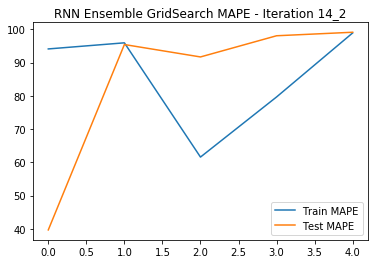

Epoch 1/40
69/69 [==============================] - 4s 56ms/step - loss: 7134644224.0000 - mean_absolute_percentage_error: 82.2530 - val_loss: 5131253760.0000 - val_mean_absolute_percentage_error: 63.4675
Epoch 2/40
69/69 [==============================] - 3s 50ms/step - loss: 4223197952.0000 - mean_absolute_percentage_error: 60.5031 - val_loss: 6447828992.0000 - val_mean_absolute_percentage_error: 87.7153
Epoch 3/40
69/69 [==============================] - 3s 49ms/step - loss: 7784688640.0000 - mean_absolute_percentage_error: 90.2584 - val_loss: 8162322944.0000 - val_mean_absolute_percentage_error: 98.8604
Epoch 4/40
69/69 [==============================] - 3s 48ms/step - loss: 2165905664.0000 - mean_absolute_percentage_error: 39.9171 - val_loss: 208295248.0000 - val_mean_absolute_percentage_error: 13.2316
Epoch 5/40
69/69 [==============================] - 3s 49ms/step - loss: 708050496.0000 - mean_absolute_percentage_error: 23.3263 - val_loss: 148743696.0000 - val_mean_absolute_perc

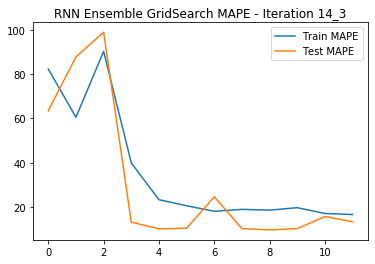

Epoch 1/40
69/69 [==============================] - 4s 60ms/step - loss: 8030396416.0000 - mean_absolute_percentage_error: 94.3964 - val_loss: 8286032896.0000 - val_mean_absolute_percentage_error: 99.6502
Epoch 2/40
69/69 [==============================] - 4s 54ms/step - loss: 6950566400.0000 - mean_absolute_percentage_error: 85.4734 - val_loss: 2458128640.0000 - val_mean_absolute_percentage_error: 47.5664
Epoch 3/40
69/69 [==============================] - 4s 54ms/step - loss: 2726045184.0000 - mean_absolute_percentage_error: 49.2397 - val_loss: 1260721920.0000 - val_mean_absolute_percentage_error: 33.1857
Epoch 4/40
69/69 [==============================] - 4s 53ms/step - loss: 1403998336.0000 - mean_absolute_percentage_error: 34.4182 - val_loss: 883365824.0000 - val_mean_absolute_percentage_error: 29.1164
Epoch 5/40
69/69 [==============================] - 4s 52ms/step - loss: 713141696.0000 - mean_absolute_percentage_error: 23.6101 - val_loss: 1084171904.0000 - val_mean_absolute_per

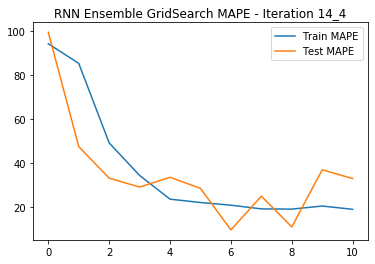

seq_length              12.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.20
stop_patience            4.00
learning_rate            0.01
epochs                  80.00
Name: 15, dtype: float64
Epoch 1/80
69/69 [==============================] - 4s 60ms/step - loss: 5861170688.0000 - mean_absolute_percentage_error: 78.0361 - val_loss: 4447370240.0000 - val_mean_absolute_percentage_error: 70.5136
Epoch 2/80
69/69 [==============================] - 4s 53ms/step - loss: 6502194688.0000 - mean_absolute_percentage_error: 82.5111 - val_loss: 6222489088.0000 - val_mean_absolute_percentage_error: 85.6686
Epoch 3/80
69/69 [==============================] - 4s 53ms/step - loss: 24248684544.0000 - mean_absolute_percentage_error: 97.8956 - val_loss: 7925526016.0000 - val_mean_absolute_percentage_error: 97.2300
Epoch 4/80
69/69 [==============================] - 4s 54ms

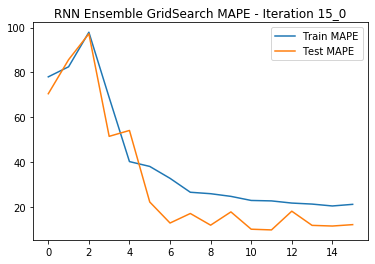

Epoch 1/80
69/69 [==============================] - 4s 58ms/step - loss: 5234322432.0000 - mean_absolute_percentage_error: 71.3498 - val_loss: 2458662400.0000 - val_mean_absolute_percentage_error: 51.7459
Epoch 2/80
69/69 [==============================] - 4s 52ms/step - loss: 1656565504.0000 - mean_absolute_percentage_error: 36.4500 - val_loss: 172203120.0000 - val_mean_absolute_percentage_error: 11.6564
Epoch 3/80
69/69 [==============================] - 4s 52ms/step - loss: 585580480.0000 - mean_absolute_percentage_error: 21.0761 - val_loss: 486838528.0000 - val_mean_absolute_percentage_error: 20.3693
Epoch 4/80
69/69 [==============================] - 4s 52ms/step - loss: 534265536.0000 - mean_absolute_percentage_error: 20.0746 - val_loss: 762075392.0000 - val_mean_absolute_percentage_error: 27.4725
Epoch 5/80
69/69 [==============================] - 4s 52ms/step - loss: 672785088.0000 - mean_absolute_percentage_error: 22.6232 - val_loss: 224340800.0000 - val_mean_absolute_percenta

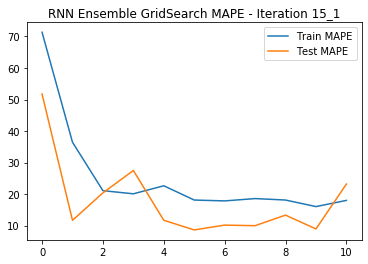

Epoch 1/80
69/69 [==============================] - 4s 60ms/step - loss: 9445192704.0000 - mean_absolute_percentage_error: 94.0884 - val_loss: 1943350784.0000 - val_mean_absolute_percentage_error: 39.6703
Epoch 2/80
69/69 [==============================] - 4s 52ms/step - loss: 80608575488.0000 - mean_absolute_percentage_error: 95.9251 - val_loss: 7637553152.0000 - val_mean_absolute_percentage_error: 95.4117
Epoch 3/80
69/69 [==============================] - 4s 52ms/step - loss: 4080520192.0000 - mean_absolute_percentage_error: 61.5719 - val_loss: 7072372224.0000 - val_mean_absolute_percentage_error: 91.6805
Epoch 4/80
69/69 [==============================] - 4s 52ms/step - loss: 6506209280.0000 - mean_absolute_percentage_error: 79.6469 - val_loss: 8043233792.0000 - val_mean_absolute_percentage_error: 98.0499
Epoch 5/80
69/69 [==============================] - 4s 52ms/step - loss: 8416294912.0000 - mean_absolute_percentage_error: 98.9001 - val_loss: 8200396800.0000 - val_mean_absolute_

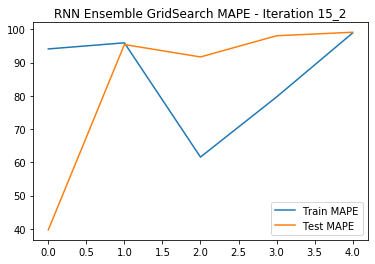

Epoch 1/80
69/69 [==============================] - 4s 65ms/step - loss: 7134644224.0000 - mean_absolute_percentage_error: 82.2530 - val_loss: 5131253760.0000 - val_mean_absolute_percentage_error: 63.4675
Epoch 2/80
69/69 [==============================] - 4s 58ms/step - loss: 4223197952.0000 - mean_absolute_percentage_error: 60.5031 - val_loss: 6447828992.0000 - val_mean_absolute_percentage_error: 87.7153
Epoch 3/80
69/69 [==============================] - 4s 57ms/step - loss: 7784688640.0000 - mean_absolute_percentage_error: 90.2584 - val_loss: 8162322944.0000 - val_mean_absolute_percentage_error: 98.8604
Epoch 4/80
69/69 [==============================] - 4s 58ms/step - loss: 2165905664.0000 - mean_absolute_percentage_error: 39.9171 - val_loss: 208295248.0000 - val_mean_absolute_percentage_error: 13.2316
Epoch 5/80
69/69 [==============================] - 4s 58ms/step - loss: 708050496.0000 - mean_absolute_percentage_error: 23.3263 - val_loss: 148743696.0000 - val_mean_absolute_perc

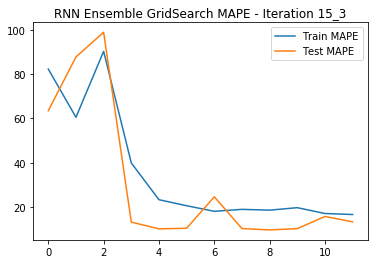

Epoch 1/80
69/69 [==============================] - 4s 61ms/step - loss: 8030396416.0000 - mean_absolute_percentage_error: 94.3964 - val_loss: 8286032896.0000 - val_mean_absolute_percentage_error: 99.6502
Epoch 2/80
69/69 [==============================] - 4s 55ms/step - loss: 6950566400.0000 - mean_absolute_percentage_error: 85.4734 - val_loss: 2458128640.0000 - val_mean_absolute_percentage_error: 47.5664
Epoch 3/80
69/69 [==============================] - 4s 55ms/step - loss: 2726045184.0000 - mean_absolute_percentage_error: 49.2397 - val_loss: 1260721920.0000 - val_mean_absolute_percentage_error: 33.1857
Epoch 4/80
69/69 [==============================] - 4s 55ms/step - loss: 1403998336.0000 - mean_absolute_percentage_error: 34.4182 - val_loss: 883365824.0000 - val_mean_absolute_percentage_error: 29.1164
Epoch 5/80
69/69 [==============================] - 4s 55ms/step - loss: 713141696.0000 - mean_absolute_percentage_error: 23.6101 - val_loss: 1084171904.0000 - val_mean_absolute_per

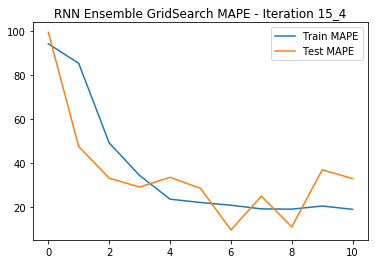

seq_length              12.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.400
stop_patience            3.000
learning_rate            0.001
epochs                  40.000
Name: 16, dtype: float64
Epoch 1/40
69/69 [==============================] - 4s 62ms/step - loss: 5866330624.0000 - mean_absolute_percentage_error: 77.7097 - val_loss: 2533862144.0000 - val_mean_absolute_percentage_error: 53.1548
Epoch 2/40
69/69 [==============================] - 4s 55ms/step - loss: 2530597888.0000 - mean_absolute_percentage_error: 46.8101 - val_loss: 1188940928.0000 - val_mean_absolute_percentage_error: 35.0135
Epoch 3/40
69/69 [==============================] - 4s 55ms/step - loss: 1917333760.0000 - mean_absolute_percentage_error: 40.0825 - val_loss: 306271424.0000 - val_mean_absolute_percentage_error: 14.5912
Epoch 4/40
69/69 [==============================] -

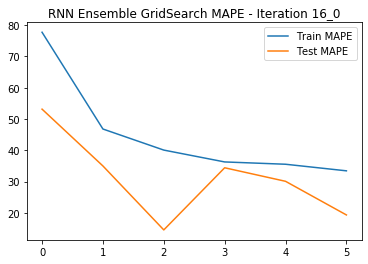

Epoch 1/40
69/69 [==============================] - 4s 58ms/step - loss: 6118375936.0000 - mean_absolute_percentage_error: 79.6469 - val_loss: 388060320.0000 - val_mean_absolute_percentage_error: 17.4772
Epoch 2/40
69/69 [==============================] - 4s 54ms/step - loss: 2656490752.0000 - mean_absolute_percentage_error: 47.9622 - val_loss: 1635727360.0000 - val_mean_absolute_percentage_error: 42.3633
Epoch 3/40
69/69 [==============================] - 4s 53ms/step - loss: 2161687808.0000 - mean_absolute_percentage_error: 42.6966 - val_loss: 1747712256.0000 - val_mean_absolute_percentage_error: 43.8633
Epoch 4/40
69/69 [==============================] - 4s 54ms/step - loss: 1747661056.0000 - mean_absolute_percentage_error: 37.9699 - val_loss: 2379556608.0000 - val_mean_absolute_percentage_error: 47.3375
Epoch 00004: early stopping


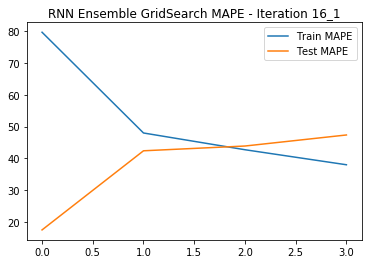

Epoch 1/40
69/69 [==============================] - 4s 63ms/step - loss: 6686604800.0000 - mean_absolute_percentage_error: 85.0499 - val_loss: 744544128.0000 - val_mean_absolute_percentage_error: 25.4794
Epoch 2/40
69/69 [==============================] - 4s 56ms/step - loss: 2911104256.0000 - mean_absolute_percentage_error: 50.2171 - val_loss: 476535168.0000 - val_mean_absolute_percentage_error: 19.5892
Epoch 3/40
69/69 [==============================] - 4s 57ms/step - loss: 2092407680.0000 - mean_absolute_percentage_error: 41.7044 - val_loss: 1310319232.0000 - val_mean_absolute_percentage_error: 37.4599
Epoch 4/40
69/69 [==============================] - 4s 57ms/step - loss: 1835823488.0000 - mean_absolute_percentage_error: 39.0398 - val_loss: 2633534464.0000 - val_mean_absolute_percentage_error: 55.1542
Epoch 5/40
69/69 [==============================] - 4s 57ms/step - loss: 1565667072.0000 - mean_absolute_percentage_error: 35.6293 - val_loss: 157654784.0000 - val_mean_absolute_perc

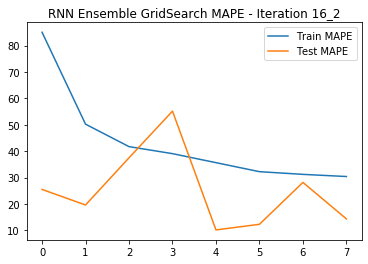

Epoch 1/40
69/69 [==============================] - 4s 61ms/step - loss: 6331015168.0000 - mean_absolute_percentage_error: 81.6368 - val_loss: 1647423360.0000 - val_mean_absolute_percentage_error: 40.0931
Epoch 2/40
69/69 [==============================] - 4s 54ms/step - loss: 2636240896.0000 - mean_absolute_percentage_error: 47.6769 - val_loss: 2240470528.0000 - val_mean_absolute_percentage_error: 49.7538
Epoch 3/40
69/69 [==============================] - 4s 54ms/step - loss: 2264676096.0000 - mean_absolute_percentage_error: 44.0034 - val_loss: 1628226432.0000 - val_mean_absolute_percentage_error: 42.5436
Epoch 4/40
69/69 [==============================] - 4s 55ms/step - loss: 1847221632.0000 - mean_absolute_percentage_error: 39.0029 - val_loss: 2406998784.0000 - val_mean_absolute_percentage_error: 52.3155
Epoch 5/40
69/69 [==============================] - 4s 55ms/step - loss: 1641641472.0000 - mean_absolute_percentage_error: 36.5925 - val_loss: 623647296.0000 - val_mean_absolute_pe

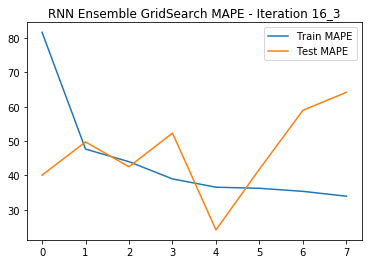

Epoch 1/40
69/69 [==============================] - 4s 60ms/step - loss: 6129262592.0000 - mean_absolute_percentage_error: 78.9997 - val_loss: 820448704.0000 - val_mean_absolute_percentage_error: 25.9611
Epoch 2/40
69/69 [==============================] - 4s 53ms/step - loss: 2174161920.0000 - mean_absolute_percentage_error: 42.9681 - val_loss: 318009472.0000 - val_mean_absolute_percentage_error: 15.0043
Epoch 3/40
69/69 [==============================] - 4s 53ms/step - loss: 1542472320.0000 - mean_absolute_percentage_error: 35.3674 - val_loss: 694554176.0000 - val_mean_absolute_percentage_error: 25.6862
Epoch 4/40
69/69 [==============================] - 4s 53ms/step - loss: 1263864832.0000 - mean_absolute_percentage_error: 31.7970 - val_loss: 194310160.0000 - val_mean_absolute_percentage_error: 11.8877
Epoch 5/40
69/69 [==============================] - 4s 51ms/step - loss: 1142084608.0000 - mean_absolute_percentage_error: 30.0984 - val_loss: 308986144.0000 - val_mean_absolute_percen

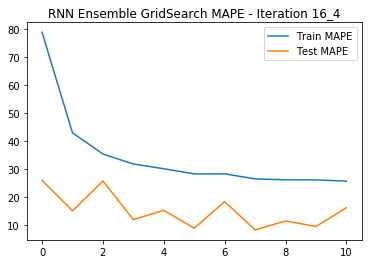

seq_length              12.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.400
stop_patience            3.000
learning_rate            0.001
epochs                  80.000
Name: 17, dtype: float64
Epoch 1/80
69/69 [==============================] - 4s 60ms/step - loss: 5866330624.0000 - mean_absolute_percentage_error: 77.7097 - val_loss: 2533862144.0000 - val_mean_absolute_percentage_error: 53.1548
Epoch 2/80
69/69 [==============================] - 4s 53ms/step - loss: 2530597888.0000 - mean_absolute_percentage_error: 46.8101 - val_loss: 1188940928.0000 - val_mean_absolute_percentage_error: 35.0135
Epoch 3/80
69/69 [==============================] - 4s 54ms/step - loss: 1917333760.0000 - mean_absolute_percentage_error: 40.0825 - val_loss: 306271424.0000 - val_mean_absolute_percentage_error: 14.5912
Epoch 4/80
69/69 [==============================] -

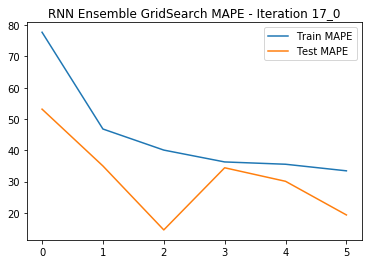

Epoch 1/80
69/69 [==============================] - 4s 61ms/step - loss: 6118375936.0000 - mean_absolute_percentage_error: 79.6469 - val_loss: 388060320.0000 - val_mean_absolute_percentage_error: 17.4772
Epoch 2/80
69/69 [==============================] - 4s 57ms/step - loss: 2656490752.0000 - mean_absolute_percentage_error: 47.9622 - val_loss: 1635727360.0000 - val_mean_absolute_percentage_error: 42.3633
Epoch 3/80
69/69 [==============================] - 4s 56ms/step - loss: 2161687808.0000 - mean_absolute_percentage_error: 42.6966 - val_loss: 1747712256.0000 - val_mean_absolute_percentage_error: 43.8633
Epoch 4/80
69/69 [==============================] - 4s 57ms/step - loss: 1747661056.0000 - mean_absolute_percentage_error: 37.9699 - val_loss: 2379556608.0000 - val_mean_absolute_percentage_error: 47.3375
Epoch 00004: early stopping


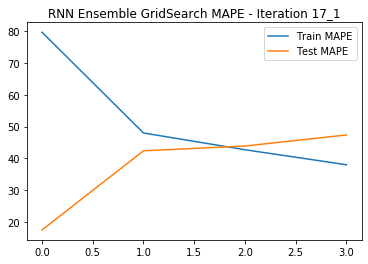

Epoch 1/80
69/69 [==============================] - 4s 60ms/step - loss: 6686604800.0000 - mean_absolute_percentage_error: 85.0499 - val_loss: 744544128.0000 - val_mean_absolute_percentage_error: 25.4794
Epoch 2/80
69/69 [==============================] - 4s 54ms/step - loss: 2911104256.0000 - mean_absolute_percentage_error: 50.2171 - val_loss: 476535168.0000 - val_mean_absolute_percentage_error: 19.5892
Epoch 3/80
69/69 [==============================] - 4s 54ms/step - loss: 2092407680.0000 - mean_absolute_percentage_error: 41.7044 - val_loss: 1310319232.0000 - val_mean_absolute_percentage_error: 37.4599
Epoch 4/80
69/69 [==============================] - 4s 54ms/step - loss: 1835823488.0000 - mean_absolute_percentage_error: 39.0398 - val_loss: 2633534464.0000 - val_mean_absolute_percentage_error: 55.1542
Epoch 5/80
69/69 [==============================] - 4s 54ms/step - loss: 1565667072.0000 - mean_absolute_percentage_error: 35.6293 - val_loss: 157654784.0000 - val_mean_absolute_perc

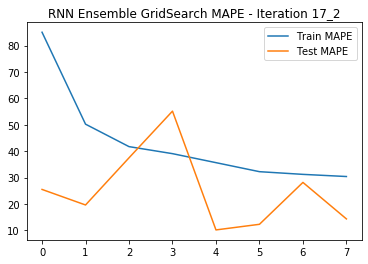

Epoch 1/80
69/69 [==============================] - 4s 56ms/step - loss: 6331015168.0000 - mean_absolute_percentage_error: 81.6368 - val_loss: 1647423360.0000 - val_mean_absolute_percentage_error: 40.0931
Epoch 2/80
69/69 [==============================] - 4s 54ms/step - loss: 2636240896.0000 - mean_absolute_percentage_error: 47.6769 - val_loss: 2240470528.0000 - val_mean_absolute_percentage_error: 49.7538
Epoch 3/80
69/69 [==============================] - 4s 53ms/step - loss: 2264676096.0000 - mean_absolute_percentage_error: 44.0034 - val_loss: 1628226432.0000 - val_mean_absolute_percentage_error: 42.5436
Epoch 4/80
69/69 [==============================] - 4s 53ms/step - loss: 1847221632.0000 - mean_absolute_percentage_error: 39.0029 - val_loss: 2406998784.0000 - val_mean_absolute_percentage_error: 52.3155
Epoch 5/80
69/69 [==============================] - 4s 54ms/step - loss: 1641641472.0000 - mean_absolute_percentage_error: 36.5925 - val_loss: 623647296.0000 - val_mean_absolute_pe

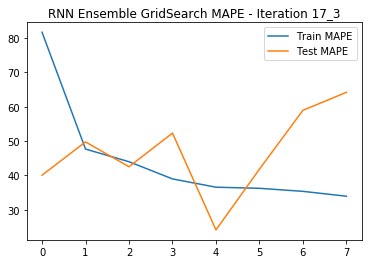

Epoch 1/80
69/69 [==============================] - 4s 56ms/step - loss: 6129262592.0000 - mean_absolute_percentage_error: 78.9997 - val_loss: 820448704.0000 - val_mean_absolute_percentage_error: 25.9611
Epoch 2/80
69/69 [==============================] - 4s 51ms/step - loss: 2174161920.0000 - mean_absolute_percentage_error: 42.9681 - val_loss: 318009472.0000 - val_mean_absolute_percentage_error: 15.0043
Epoch 3/80
69/69 [==============================] - 3s 51ms/step - loss: 1542472320.0000 - mean_absolute_percentage_error: 35.3674 - val_loss: 694554176.0000 - val_mean_absolute_percentage_error: 25.6862
Epoch 4/80
69/69 [==============================] - 4s 52ms/step - loss: 1263864832.0000 - mean_absolute_percentage_error: 31.7970 - val_loss: 194310160.0000 - val_mean_absolute_percentage_error: 11.8877
Epoch 5/80
69/69 [==============================] - 4s 51ms/step - loss: 1142084608.0000 - mean_absolute_percentage_error: 30.0984 - val_loss: 308986144.0000 - val_mean_absolute_percen

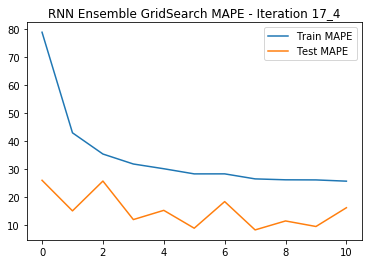

seq_length              12.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.40
stop_patience            3.00
learning_rate            0.01
epochs                  40.00
Name: 18, dtype: float64
Epoch 1/40
69/69 [==============================] - 5s 72ms/step - loss: 6432345600.0000 - mean_absolute_percentage_error: 79.2463 - val_loss: 4128833024.0000 - val_mean_absolute_percentage_error: 68.0313
Epoch 2/40
69/69 [==============================] - 4s 58ms/step - loss: 5344257024.0000 - mean_absolute_percentage_error: 73.2179 - val_loss: 801237184.0000 - val_mean_absolute_percentage_error: 24.0634
Epoch 3/40
69/69 [==============================] - 4s 60ms/step - loss: 1894421888.0000 - mean_absolute_percentage_error: 38.4341 - val_loss: 1180789248.0000 - val_mean_absolute_percentage_error: 33.8353
Epoch 4/40
69/69 [==============================] - 4s 59ms/s

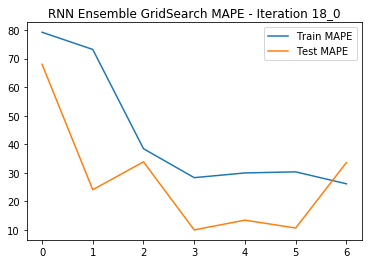

Epoch 1/40
69/69 [==============================] - 4s 62ms/step - loss: 8345044480.0000 - mean_absolute_percentage_error: 90.7669 - val_loss: 4496158208.0000 - val_mean_absolute_percentage_error: 70.4202
Epoch 2/40
69/69 [==============================] - 4s 55ms/step - loss: 6317570560.0000 - mean_absolute_percentage_error: 72.9503 - val_loss: 2068353024.0000 - val_mean_absolute_percentage_error: 44.4275
Epoch 3/40
69/69 [==============================] - 4s 55ms/step - loss: 3104021760.0000 - mean_absolute_percentage_error: 52.7985 - val_loss: 2873592832.0000 - val_mean_absolute_percentage_error: 56.4033
Epoch 4/40
69/69 [==============================] - 4s 56ms/step - loss: 1751388544.0000 - mean_absolute_percentage_error: 37.2684 - val_loss: 701443648.0000 - val_mean_absolute_percentage_error: 24.9119
Epoch 5/40
69/69 [==============================] - 4s 56ms/step - loss: 1254506624.0000 - mean_absolute_percentage_error: 31.8340 - val_loss: 175055280.0000 - val_mean_absolute_per

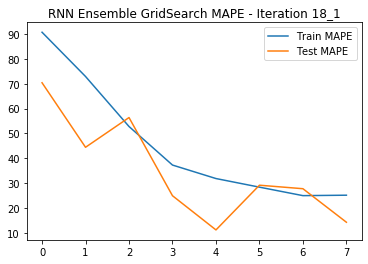

Epoch 1/40
69/69 [==============================] - 4s 58ms/step - loss: 8167815168.0000 - mean_absolute_percentage_error: 88.1712 - val_loss: 3711207424.0000 - val_mean_absolute_percentage_error: 63.8933
Epoch 2/40
69/69 [==============================] - 4s 52ms/step - loss: 2350793472.0000 - mean_absolute_percentage_error: 44.5860 - val_loss: 1054188288.0000 - val_mean_absolute_percentage_error: 31.3896
Epoch 3/40
69/69 [==============================] - 4s 51ms/step - loss: 1625490432.0000 - mean_absolute_percentage_error: 35.5174 - val_loss: 613377536.0000 - val_mean_absolute_percentage_error: 22.7914
Epoch 4/40
69/69 [==============================] - 4s 51ms/step - loss: 1121782912.0000 - mean_absolute_percentage_error: 29.5185 - val_loss: 766584896.0000 - val_mean_absolute_percentage_error: 27.0973
Epoch 5/40
69/69 [==============================] - 4s 52ms/step - loss: 1066149632.0000 - mean_absolute_percentage_error: 28.7712 - val_loss: 847749824.0000 - val_mean_absolute_perc

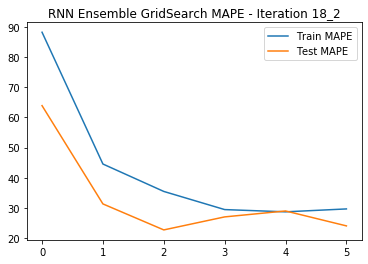

Epoch 1/40
69/69 [==============================] - 4s 54ms/step - loss: 18023784448.0000 - mean_absolute_percentage_error: 101.2730 - val_loss: 6533665280.0000 - val_mean_absolute_percentage_error: 87.3767
Epoch 2/40
69/69 [==============================] - 3s 49ms/step - loss: 4814660608.0000 - mean_absolute_percentage_error: 67.4384 - val_loss: 2850543104.0000 - val_mean_absolute_percentage_error: 54.6736
Epoch 3/40
69/69 [==============================] - 3s 49ms/step - loss: 1990567552.0000 - mean_absolute_percentage_error: 40.0648 - val_loss: 231308688.0000 - val_mean_absolute_percentage_error: 11.9658
Epoch 4/40
69/69 [==============================] - 3s 49ms/step - loss: 1482630144.0000 - mean_absolute_percentage_error: 34.5130 - val_loss: 252408304.0000 - val_mean_absolute_percentage_error: 12.2885
Epoch 5/40
69/69 [==============================] - 3s 48ms/step - loss: 1221201536.0000 - mean_absolute_percentage_error: 30.9753 - val_loss: 195592240.0000 - val_mean_absolute_pe

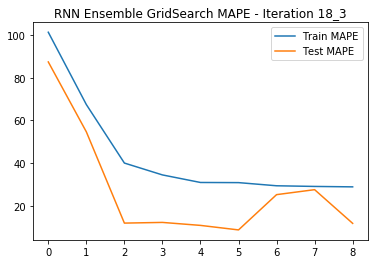

Epoch 1/40
69/69 [==============================] - 4s 54ms/step - loss: 8714744832.0000 - mean_absolute_percentage_error: 90.1641 - val_loss: 3191919360.0000 - val_mean_absolute_percentage_error: 57.2077
Epoch 2/40
69/69 [==============================] - 3s 47ms/step - loss: 1512749440.0000 - mean_absolute_percentage_error: 33.9066 - val_loss: 589631936.0000 - val_mean_absolute_percentage_error: 20.8963
Epoch 3/40
69/69 [==============================] - 3s 47ms/step - loss: 904345408.0000 - mean_absolute_percentage_error: 26.3479 - val_loss: 690346496.0000 - val_mean_absolute_percentage_error: 24.3981
Epoch 4/40
69/69 [==============================] - 3s 47ms/step - loss: 741453056.0000 - mean_absolute_percentage_error: 23.7592 - val_loss: 220392816.0000 - val_mean_absolute_percentage_error: 11.2209
Epoch 5/40
69/69 [==============================] - 3s 47ms/step - loss: 804919616.0000 - mean_absolute_percentage_error: 24.6994 - val_loss: 337744352.0000 - val_mean_absolute_percenta

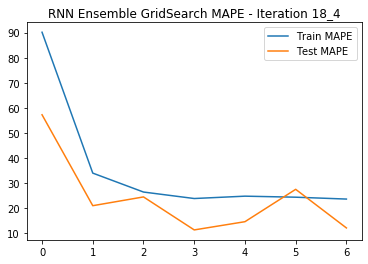

seq_length              12.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.40
stop_patience            3.00
learning_rate            0.01
epochs                  80.00
Name: 19, dtype: float64
Epoch 1/80
69/69 [==============================] - 4s 64ms/step - loss: 6432345600.0000 - mean_absolute_percentage_error: 79.2463 - val_loss: 4128833024.0000 - val_mean_absolute_percentage_error: 68.0313
Epoch 2/80
69/69 [==============================] - 4s 57ms/step - loss: 5344257024.0000 - mean_absolute_percentage_error: 73.2179 - val_loss: 801237184.0000 - val_mean_absolute_percentage_error: 24.0634
Epoch 3/80
69/69 [==============================] - 4s 56ms/step - loss: 1894421888.0000 - mean_absolute_percentage_error: 38.4341 - val_loss: 1180789248.0000 - val_mean_absolute_percentage_error: 33.8353
Epoch 4/80
69/69 [==============================] - 4s 57ms/s

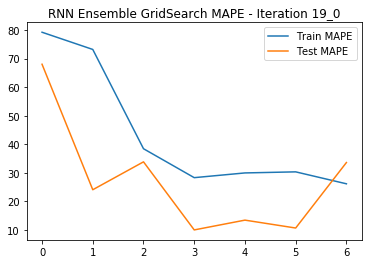

Epoch 1/80
69/69 [==============================] - 4s 62ms/step - loss: 8345044480.0000 - mean_absolute_percentage_error: 90.7669 - val_loss: 4496158208.0000 - val_mean_absolute_percentage_error: 70.4202
Epoch 2/80
69/69 [==============================] - 4s 55ms/step - loss: 6317570560.0000 - mean_absolute_percentage_error: 72.9503 - val_loss: 2068353024.0000 - val_mean_absolute_percentage_error: 44.4275
Epoch 3/80
69/69 [==============================] - 4s 55ms/step - loss: 3104021760.0000 - mean_absolute_percentage_error: 52.7985 - val_loss: 2873592832.0000 - val_mean_absolute_percentage_error: 56.4033
Epoch 4/80
69/69 [==============================] - 4s 55ms/step - loss: 1751388544.0000 - mean_absolute_percentage_error: 37.2684 - val_loss: 701443648.0000 - val_mean_absolute_percentage_error: 24.9119
Epoch 5/80
69/69 [==============================] - 4s 55ms/step - loss: 1254506624.0000 - mean_absolute_percentage_error: 31.8340 - val_loss: 175055280.0000 - val_mean_absolute_per

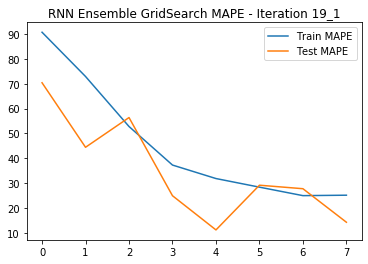

Epoch 1/80
69/69 [==============================] - 4s 58ms/step - loss: 8167815168.0000 - mean_absolute_percentage_error: 88.1712 - val_loss: 3711207424.0000 - val_mean_absolute_percentage_error: 63.8933
Epoch 2/80
69/69 [==============================] - 4s 54ms/step - loss: 2350793472.0000 - mean_absolute_percentage_error: 44.5860 - val_loss: 1054188288.0000 - val_mean_absolute_percentage_error: 31.3896
Epoch 3/80
69/69 [==============================] - 4s 53ms/step - loss: 1625490432.0000 - mean_absolute_percentage_error: 35.5174 - val_loss: 613377536.0000 - val_mean_absolute_percentage_error: 22.7914
Epoch 4/80
69/69 [==============================] - 4s 53ms/step - loss: 1121782912.0000 - mean_absolute_percentage_error: 29.5185 - val_loss: 766584896.0000 - val_mean_absolute_percentage_error: 27.0973
Epoch 5/80
69/69 [==============================] - 4s 54ms/step - loss: 1066149632.0000 - mean_absolute_percentage_error: 28.7712 - val_loss: 847749824.0000 - val_mean_absolute_perc

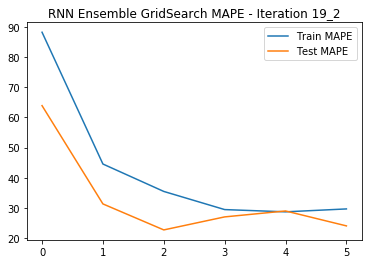

Epoch 1/80
69/69 [==============================] - 4s 56ms/step - loss: 18023784448.0000 - mean_absolute_percentage_error: 101.2730 - val_loss: 6533665280.0000 - val_mean_absolute_percentage_error: 87.3767
Epoch 2/80
69/69 [==============================] - 4s 52ms/step - loss: 4814660608.0000 - mean_absolute_percentage_error: 67.4384 - val_loss: 2850543104.0000 - val_mean_absolute_percentage_error: 54.6736
Epoch 3/80
69/69 [==============================] - 4s 51ms/step - loss: 1990567552.0000 - mean_absolute_percentage_error: 40.0648 - val_loss: 231308688.0000 - val_mean_absolute_percentage_error: 11.9658
Epoch 4/80
69/69 [==============================] - 4s 52ms/step - loss: 1482630144.0000 - mean_absolute_percentage_error: 34.5130 - val_loss: 252408304.0000 - val_mean_absolute_percentage_error: 12.2885
Epoch 5/80
69/69 [==============================] - 4s 52ms/step - loss: 1221201536.0000 - mean_absolute_percentage_error: 30.9753 - val_loss: 195592240.0000 - val_mean_absolute_pe

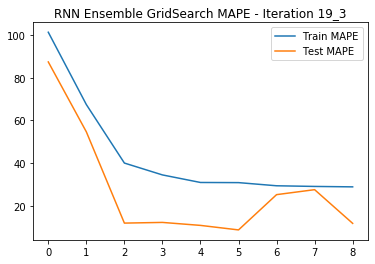

Epoch 1/80
69/69 [==============================] - 4s 59ms/step - loss: 8714744832.0000 - mean_absolute_percentage_error: 90.1641 - val_loss: 3191919360.0000 - val_mean_absolute_percentage_error: 57.2077
Epoch 2/80
69/69 [==============================] - 4s 54ms/step - loss: 1512749440.0000 - mean_absolute_percentage_error: 33.9066 - val_loss: 589631936.0000 - val_mean_absolute_percentage_error: 20.8963
Epoch 3/80
69/69 [==============================] - 4s 55ms/step - loss: 904345408.0000 - mean_absolute_percentage_error: 26.3479 - val_loss: 690346496.0000 - val_mean_absolute_percentage_error: 24.3981
Epoch 4/80
69/69 [==============================] - 4s 55ms/step - loss: 741453056.0000 - mean_absolute_percentage_error: 23.7592 - val_loss: 220392816.0000 - val_mean_absolute_percentage_error: 11.2209
Epoch 5/80
69/69 [==============================] - 4s 56ms/step - loss: 804919616.0000 - mean_absolute_percentage_error: 24.6994 - val_loss: 337744352.0000 - val_mean_absolute_percenta

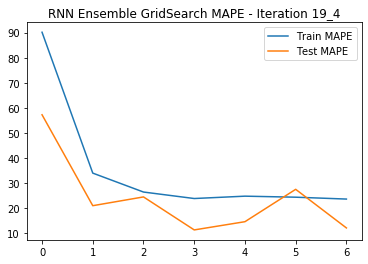

seq_length              12.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.400
stop_patience            4.000
learning_rate            0.001
epochs                  40.000
Name: 20, dtype: float64
Epoch 1/40
69/69 [==============================] - 4s 62ms/step - loss: 5866330624.0000 - mean_absolute_percentage_error: 77.7097 - val_loss: 2533862144.0000 - val_mean_absolute_percentage_error: 53.1548
Epoch 2/40
69/69 [==============================] - 4s 55ms/step - loss: 2530597888.0000 - mean_absolute_percentage_error: 46.8101 - val_loss: 1188940928.0000 - val_mean_absolute_percentage_error: 35.0135
Epoch 3/40
69/69 [==============================] - 4s 55ms/step - loss: 1917333760.0000 - mean_absolute_percentage_error: 40.0825 - val_loss: 306271424.0000 - val_mean_absolute_percentage_error: 14.5912
Epoch 4/40
69/69 [==============================] -

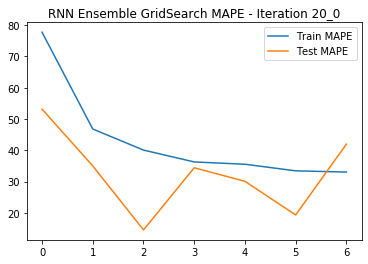

Epoch 1/40
69/69 [==============================] - 4s 60ms/step - loss: 5998437888.0000 - mean_absolute_percentage_error: 79.0521 - val_loss: 802088832.0000 - val_mean_absolute_percentage_error: 25.6909
Epoch 2/40
69/69 [==============================] - 4s 53ms/step - loss: 2516296704.0000 - mean_absolute_percentage_error: 46.5479 - val_loss: 234145744.0000 - val_mean_absolute_percentage_error: 12.9004
Epoch 3/40
69/69 [==============================] - 4s 54ms/step - loss: 1852895360.0000 - mean_absolute_percentage_error: 39.2456 - val_loss: 156201024.0000 - val_mean_absolute_percentage_error: 11.4299
Epoch 4/40
69/69 [==============================] - 4s 54ms/step - loss: 1416946176.0000 - mean_absolute_percentage_error: 33.8071 - val_loss: 342722528.0000 - val_mean_absolute_percentage_error: 17.6971
Epoch 5/40
69/69 [==============================] - 4s 54ms/step - loss: 1441686656.0000 - mean_absolute_percentage_error: 34.3482 - val_loss: 1340923008.0000 - val_mean_absolute_perce

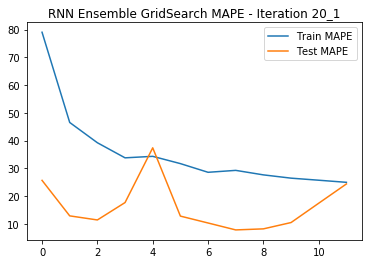

Epoch 1/40
69/69 [==============================] - 4s 57ms/step - loss: 6420780032.0000 - mean_absolute_percentage_error: 82.8303 - val_loss: 1889311744.0000 - val_mean_absolute_percentage_error: 44.9300
Epoch 2/40
69/69 [==============================] - 4s 54ms/step - loss: 2872736768.0000 - mean_absolute_percentage_error: 49.7262 - val_loss: 1409713408.0000 - val_mean_absolute_percentage_error: 38.3381
Epoch 3/40
69/69 [==============================] - 4s 52ms/step - loss: 2291671552.0000 - mean_absolute_percentage_error: 43.9873 - val_loss: 2222422528.0000 - val_mean_absolute_percentage_error: 49.5031
Epoch 4/40
69/69 [==============================] - 4s 52ms/step - loss: 1758726016.0000 - mean_absolute_percentage_error: 37.9808 - val_loss: 3110208512.0000 - val_mean_absolute_percentage_error: 59.8222
Epoch 5/40
69/69 [==============================] - 4s 53ms/step - loss: 1696630656.0000 - mean_absolute_percentage_error: 37.0384 - val_loss: 344162624.0000 - val_mean_absolute_pe

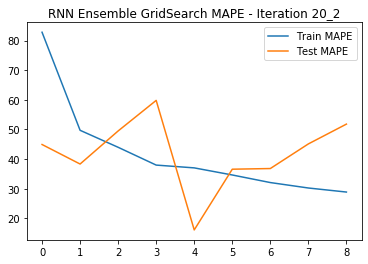

Epoch 1/40
69/69 [==============================] - 4s 59ms/step - loss: 6540987904.0000 - mean_absolute_percentage_error: 83.0795 - val_loss: 2157049088.0000 - val_mean_absolute_percentage_error: 48.4992
Epoch 2/40
69/69 [==============================] - 4s 53ms/step - loss: 2769937664.0000 - mean_absolute_percentage_error: 49.0117 - val_loss: 1855335424.0000 - val_mean_absolute_percentage_error: 45.4809
Epoch 3/40
69/69 [==============================] - 4s 52ms/step - loss: 2507666688.0000 - mean_absolute_percentage_error: 46.5016 - val_loss: 1635399680.0000 - val_mean_absolute_percentage_error: 42.1231
Epoch 4/40
69/69 [==============================] - 4s 51ms/step - loss: 2146637568.0000 - mean_absolute_percentage_error: 42.6787 - val_loss: 2262176000.0000 - val_mean_absolute_percentage_error: 50.5404
Epoch 5/40
69/69 [==============================] - 4s 52ms/step - loss: 1998445696.0000 - mean_absolute_percentage_error: 40.8059 - val_loss: 2298702848.0000 - val_mean_absolute_p

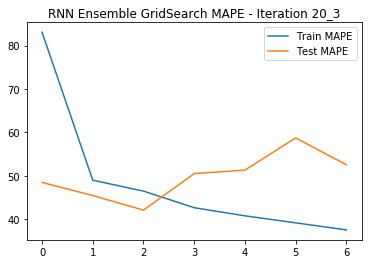

Epoch 1/40
69/69 [==============================] - 4s 64ms/step - loss: 5971709440.0000 - mean_absolute_percentage_error: 77.7895 - val_loss: 851926784.0000 - val_mean_absolute_percentage_error: 26.4372
Epoch 2/40
69/69 [==============================] - 4s 58ms/step - loss: 2305980928.0000 - mean_absolute_percentage_error: 44.3174 - val_loss: 2397141248.0000 - val_mean_absolute_percentage_error: 51.7758
Epoch 3/40
69/69 [==============================] - 4s 58ms/step - loss: 1949249664.0000 - mean_absolute_percentage_error: 40.2125 - val_loss: 769501632.0000 - val_mean_absolute_percentage_error: 26.8212
Epoch 4/40
69/69 [==============================] - 4s 58ms/step - loss: 1492965632.0000 - mean_absolute_percentage_error: 34.6791 - val_loss: 784220544.0000 - val_mean_absolute_percentage_error: 27.6984
Epoch 5/40
69/69 [==============================] - 4s 58ms/step - loss: 1340403968.0000 - mean_absolute_percentage_error: 32.7227 - val_loss: 285547264.0000 - val_mean_absolute_perce

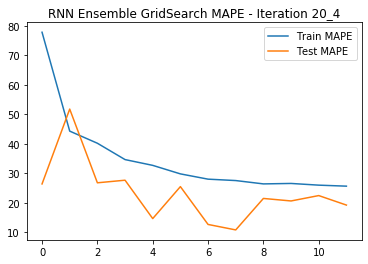

seq_length              12.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.400
stop_patience            4.000
learning_rate            0.001
epochs                  80.000
Name: 21, dtype: float64
Epoch 1/80
69/69 [==============================] - 4s 65ms/step - loss: 5866330624.0000 - mean_absolute_percentage_error: 77.7097 - val_loss: 2533862144.0000 - val_mean_absolute_percentage_error: 53.1548
Epoch 2/80
69/69 [==============================] - 4s 57ms/step - loss: 2530597888.0000 - mean_absolute_percentage_error: 46.8101 - val_loss: 1188940928.0000 - val_mean_absolute_percentage_error: 35.0135
Epoch 3/80
69/69 [==============================] - 4s 56ms/step - loss: 1917333760.0000 - mean_absolute_percentage_error: 40.0825 - val_loss: 306271424.0000 - val_mean_absolute_percentage_error: 14.5912
Epoch 4/80
69/69 [==============================] -

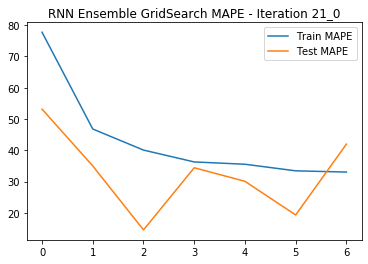

Epoch 1/80
69/69 [==============================] - 4s 63ms/step - loss: 5998437888.0000 - mean_absolute_percentage_error: 79.0521 - val_loss: 802088832.0000 - val_mean_absolute_percentage_error: 25.6909
Epoch 2/80
69/69 [==============================] - 4s 56ms/step - loss: 2516296704.0000 - mean_absolute_percentage_error: 46.5479 - val_loss: 234145744.0000 - val_mean_absolute_percentage_error: 12.9004
Epoch 3/80
69/69 [==============================] - 4s 55ms/step - loss: 1852895360.0000 - mean_absolute_percentage_error: 39.2456 - val_loss: 156201024.0000 - val_mean_absolute_percentage_error: 11.4299
Epoch 4/80
69/69 [==============================] - 4s 56ms/step - loss: 1416946176.0000 - mean_absolute_percentage_error: 33.8071 - val_loss: 342722528.0000 - val_mean_absolute_percentage_error: 17.6971
Epoch 5/80
69/69 [==============================] - 4s 55ms/step - loss: 1441686656.0000 - mean_absolute_percentage_error: 34.3482 - val_loss: 1340923008.0000 - val_mean_absolute_perce

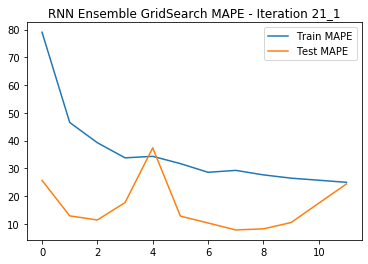

Epoch 1/80
69/69 [==============================] - 4s 60ms/step - loss: 6420780032.0000 - mean_absolute_percentage_error: 82.8303 - val_loss: 1889311744.0000 - val_mean_absolute_percentage_error: 44.9300
Epoch 2/80
69/69 [==============================] - 4s 54ms/step - loss: 2872736768.0000 - mean_absolute_percentage_error: 49.7262 - val_loss: 1409713408.0000 - val_mean_absolute_percentage_error: 38.3381
Epoch 3/80
69/69 [==============================] - 4s 54ms/step - loss: 2291671552.0000 - mean_absolute_percentage_error: 43.9873 - val_loss: 2222422528.0000 - val_mean_absolute_percentage_error: 49.5031
Epoch 4/80
69/69 [==============================] - 4s 54ms/step - loss: 1758726016.0000 - mean_absolute_percentage_error: 37.9808 - val_loss: 3110208512.0000 - val_mean_absolute_percentage_error: 59.8222
Epoch 5/80
69/69 [==============================] - 4s 53ms/step - loss: 1696630656.0000 - mean_absolute_percentage_error: 37.0384 - val_loss: 344162624.0000 - val_mean_absolute_pe

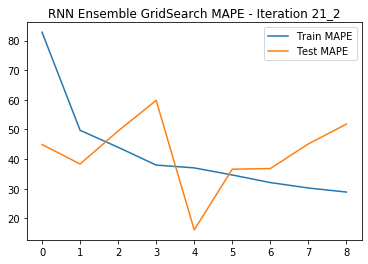

Epoch 1/80
69/69 [==============================] - 4s 65ms/step - loss: 6540987904.0000 - mean_absolute_percentage_error: 83.0795 - val_loss: 2157049088.0000 - val_mean_absolute_percentage_error: 48.4992
Epoch 2/80
69/69 [==============================] - 4s 58ms/step - loss: 2769937664.0000 - mean_absolute_percentage_error: 49.0117 - val_loss: 1855335424.0000 - val_mean_absolute_percentage_error: 45.4809
Epoch 3/80
69/69 [==============================] - 4s 59ms/step - loss: 2507666688.0000 - mean_absolute_percentage_error: 46.5016 - val_loss: 1635399680.0000 - val_mean_absolute_percentage_error: 42.1231
Epoch 4/80
69/69 [==============================] - 4s 59ms/step - loss: 2146637568.0000 - mean_absolute_percentage_error: 42.6787 - val_loss: 2262176000.0000 - val_mean_absolute_percentage_error: 50.5404
Epoch 5/80
69/69 [==============================] - 4s 59ms/step - loss: 1998445696.0000 - mean_absolute_percentage_error: 40.8059 - val_loss: 2298702848.0000 - val_mean_absolute_p

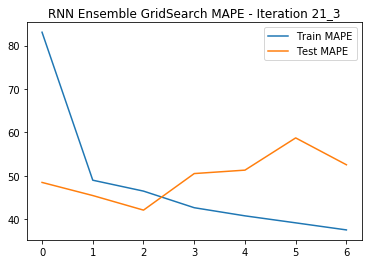

Epoch 1/80
69/69 [==============================] - 4s 63ms/step - loss: 5971709440.0000 - mean_absolute_percentage_error: 77.7895 - val_loss: 851926784.0000 - val_mean_absolute_percentage_error: 26.4372
Epoch 2/80
69/69 [==============================] - 4s 56ms/step - loss: 2305980928.0000 - mean_absolute_percentage_error: 44.3174 - val_loss: 2397141248.0000 - val_mean_absolute_percentage_error: 51.7758
Epoch 3/80
69/69 [==============================] - 4s 57ms/step - loss: 1949249664.0000 - mean_absolute_percentage_error: 40.2125 - val_loss: 769501632.0000 - val_mean_absolute_percentage_error: 26.8212
Epoch 4/80
69/69 [==============================] - 4s 56ms/step - loss: 1492965632.0000 - mean_absolute_percentage_error: 34.6791 - val_loss: 784220544.0000 - val_mean_absolute_percentage_error: 27.6984
Epoch 5/80
69/69 [==============================] - 4s 56ms/step - loss: 1340403968.0000 - mean_absolute_percentage_error: 32.7227 - val_loss: 285547264.0000 - val_mean_absolute_perce

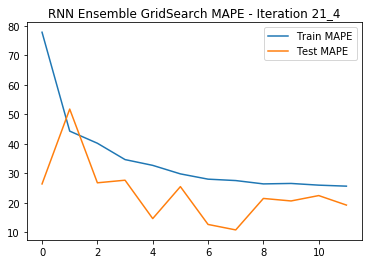

seq_length              12.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.40
stop_patience            4.00
learning_rate            0.01
epochs                  40.00
Name: 22, dtype: float64
Epoch 1/40
69/69 [==============================] - 4s 63ms/step - loss: 6432345600.0000 - mean_absolute_percentage_error: 79.2463 - val_loss: 4128833024.0000 - val_mean_absolute_percentage_error: 68.0313
Epoch 2/40
69/69 [==============================] - 4s 57ms/step - loss: 5344257024.0000 - mean_absolute_percentage_error: 73.2179 - val_loss: 801237184.0000 - val_mean_absolute_percentage_error: 24.0634
Epoch 3/40
69/69 [==============================] - 4s 57ms/step - loss: 1894421888.0000 - mean_absolute_percentage_error: 38.4341 - val_loss: 1180789248.0000 - val_mean_absolute_percentage_error: 33.8353
Epoch 4/40
69/69 [==============================] - 4s 57ms/s

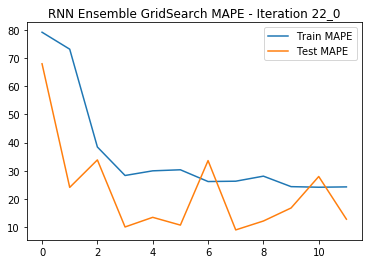

Epoch 1/40
69/69 [==============================] - 4s 60ms/step - loss: 7322811904.0000 - mean_absolute_percentage_error: 89.4689 - val_loss: 4297964544.0000 - val_mean_absolute_percentage_error: 69.2890
Epoch 2/40
69/69 [==============================] - 4s 55ms/step - loss: 3247908096.0000 - mean_absolute_percentage_error: 54.8946 - val_loss: 1077015680.0000 - val_mean_absolute_percentage_error: 29.8770
Epoch 3/40
69/69 [==============================] - 4s 55ms/step - loss: 2050523008.0000 - mean_absolute_percentage_error: 39.4586 - val_loss: 163634880.0000 - val_mean_absolute_percentage_error: 11.5990
Epoch 4/40
69/69 [==============================] - 4s 55ms/step - loss: 1020494784.0000 - mean_absolute_percentage_error: 28.1489 - val_loss: 586510848.0000 - val_mean_absolute_percentage_error: 22.7605
Epoch 5/40
69/69 [==============================] - 4s 54ms/step - loss: 1015715008.0000 - mean_absolute_percentage_error: 28.1391 - val_loss: 675017984.0000 - val_mean_absolute_perc

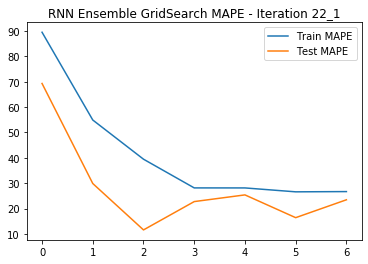

Epoch 1/40
69/69 [==============================] - 4s 61ms/step - loss: 10608135168.0000 - mean_absolute_percentage_error: 100.4043 - val_loss: 8007657472.0000 - val_mean_absolute_percentage_error: 97.8496
Epoch 2/40
69/69 [==============================] - 4s 55ms/step - loss: 3802644224.0000 - mean_absolute_percentage_error: 57.6278 - val_loss: 1095750400.0000 - val_mean_absolute_percentage_error: 30.9955
Epoch 3/40
69/69 [==============================] - 4s 54ms/step - loss: 2150533376.0000 - mean_absolute_percentage_error: 42.3135 - val_loss: 606482560.0000 - val_mean_absolute_percentage_error: 22.5541
Epoch 4/40
69/69 [==============================] - 4s 54ms/step - loss: 1331263744.0000 - mean_absolute_percentage_error: 32.2331 - val_loss: 366183328.0000 - val_mean_absolute_percentage_error: 16.1858
Epoch 5/40
69/69 [==============================] - 4s 54ms/step - loss: 1157103744.0000 - mean_absolute_percentage_error: 29.7691 - val_loss: 204160928.0000 - val_mean_absolute_pe

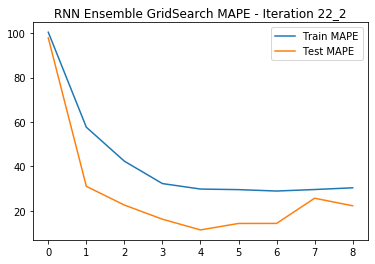

Epoch 1/40
69/69 [==============================] - 5s 66ms/step - loss: 12930654208.0000 - mean_absolute_percentage_error: 99.4004 - val_loss: 7844608000.0000 - val_mean_absolute_percentage_error: 96.7135
Epoch 2/40
69/69 [==============================] - 4s 59ms/step - loss: 8182744064.0000 - mean_absolute_percentage_error: 85.4497 - val_loss: 4433238016.0000 - val_mean_absolute_percentage_error: 68.1880
Epoch 3/40
69/69 [==============================] - 4s 60ms/step - loss: 5015365632.0000 - mean_absolute_percentage_error: 66.1143 - val_loss: 2738368256.0000 - val_mean_absolute_percentage_error: 51.8404
Epoch 4/40
69/69 [==============================] - 4s 60ms/step - loss: 3468443904.0000 - mean_absolute_percentage_error: 55.8483 - val_loss: 1837698944.0000 - val_mean_absolute_percentage_error: 41.7170
Epoch 5/40
69/69 [==============================] - 4s 60ms/step - loss: 2137968640.0000 - mean_absolute_percentage_error: 42.2517 - val_loss: 1398386432.0000 - val_mean_absolute_

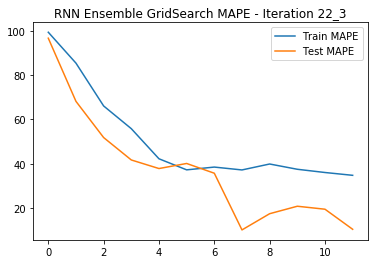

Epoch 1/40
69/69 [==============================] - 4s 64ms/step - loss: 10706082816.0000 - mean_absolute_percentage_error: 97.5663 - val_loss: 7204525568.0000 - val_mean_absolute_percentage_error: 92.4056
Epoch 2/40
69/69 [==============================] - 4s 58ms/step - loss: 7929596928.0000 - mean_absolute_percentage_error: 86.1021 - val_loss: 8266633216.0000 - val_mean_absolute_percentage_error: 99.5262
Epoch 3/40
69/69 [==============================] - 4s 58ms/step - loss: 6428776960.0000 - mean_absolute_percentage_error: 80.8311 - val_loss: 1980632960.0000 - val_mean_absolute_percentage_error: 41.1183
Epoch 4/40
69/69 [==============================] - 4s 58ms/step - loss: 7853267968.0000 - mean_absolute_percentage_error: 84.0338 - val_loss: 8340699136.0000 - val_mean_absolute_percentage_error: 99.9990
Epoch 5/40
69/69 [==============================] - 4s 58ms/step - loss: 8393492992.0000 - mean_absolute_percentage_error: 99.9813 - val_loss: 8340263936.0000 - val_mean_absolute_

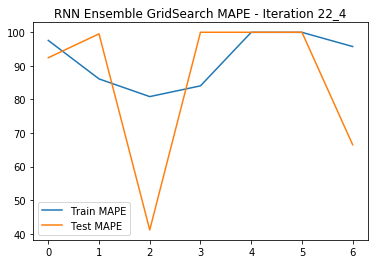

seq_length              12.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.40
stop_patience            4.00
learning_rate            0.01
epochs                  80.00
Name: 23, dtype: float64
Epoch 1/80
69/69 [==============================] - 4s 65ms/step - loss: 6432345600.0000 - mean_absolute_percentage_error: 79.2463 - val_loss: 4128833024.0000 - val_mean_absolute_percentage_error: 68.0313
Epoch 2/80
69/69 [==============================] - 4s 60ms/step - loss: 5344257024.0000 - mean_absolute_percentage_error: 73.2179 - val_loss: 801237184.0000 - val_mean_absolute_percentage_error: 24.0634
Epoch 3/80
69/69 [==============================] - 4s 59ms/step - loss: 1894421888.0000 - mean_absolute_percentage_error: 38.4341 - val_loss: 1180789248.0000 - val_mean_absolute_percentage_error: 33.8353
Epoch 4/80
69/69 [==============================] - 4s 57ms/s

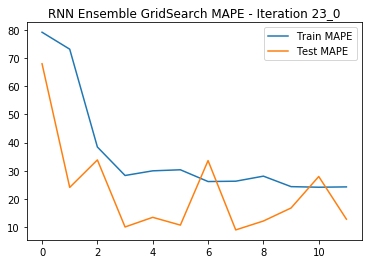

Epoch 1/80
69/69 [==============================] - 4s 64ms/step - loss: 7322811904.0000 - mean_absolute_percentage_error: 89.4689 - val_loss: 4297964544.0000 - val_mean_absolute_percentage_error: 69.2890
Epoch 2/80
69/69 [==============================] - 4s 57ms/step - loss: 3247908096.0000 - mean_absolute_percentage_error: 54.8946 - val_loss: 1077015680.0000 - val_mean_absolute_percentage_error: 29.8770
Epoch 3/80
69/69 [==============================] - 4s 58ms/step - loss: 2050523008.0000 - mean_absolute_percentage_error: 39.4586 - val_loss: 163634880.0000 - val_mean_absolute_percentage_error: 11.5990
Epoch 4/80
69/69 [==============================] - 4s 58ms/step - loss: 1020494784.0000 - mean_absolute_percentage_error: 28.1489 - val_loss: 586510848.0000 - val_mean_absolute_percentage_error: 22.7605
Epoch 5/80
69/69 [==============================] - 4s 58ms/step - loss: 1015715008.0000 - mean_absolute_percentage_error: 28.1391 - val_loss: 675017984.0000 - val_mean_absolute_perc

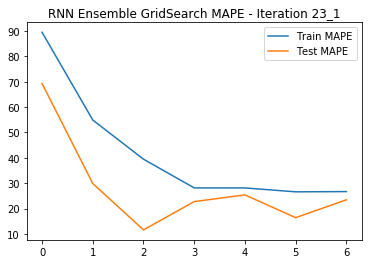

Epoch 1/80
69/69 [==============================] - 4s 62ms/step - loss: 10608135168.0000 - mean_absolute_percentage_error: 100.4043 - val_loss: 8007657472.0000 - val_mean_absolute_percentage_error: 97.8496
Epoch 2/80
69/69 [==============================] - 4s 56ms/step - loss: 3802644224.0000 - mean_absolute_percentage_error: 57.6278 - val_loss: 1095750400.0000 - val_mean_absolute_percentage_error: 30.9955
Epoch 3/80
69/69 [==============================] - 4s 55ms/step - loss: 2150533376.0000 - mean_absolute_percentage_error: 42.3135 - val_loss: 606482560.0000 - val_mean_absolute_percentage_error: 22.5541
Epoch 4/80
69/69 [==============================] - 4s 56ms/step - loss: 1331263744.0000 - mean_absolute_percentage_error: 32.2331 - val_loss: 366183328.0000 - val_mean_absolute_percentage_error: 16.1858
Epoch 5/80
69/69 [==============================] - 4s 55ms/step - loss: 1157103744.0000 - mean_absolute_percentage_error: 29.7691 - val_loss: 204160928.0000 - val_mean_absolute_pe

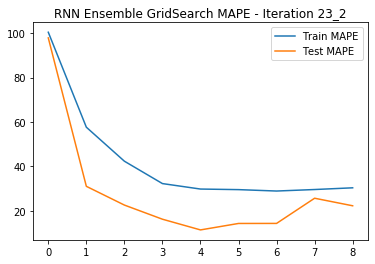

Epoch 1/80
69/69 [==============================] - 5s 66ms/step - loss: 12930654208.0000 - mean_absolute_percentage_error: 99.4004 - val_loss: 7844608000.0000 - val_mean_absolute_percentage_error: 96.7135
Epoch 2/80
69/69 [==============================] - 4s 59ms/step - loss: 8182744064.0000 - mean_absolute_percentage_error: 85.4497 - val_loss: 4433238016.0000 - val_mean_absolute_percentage_error: 68.1880
Epoch 3/80
69/69 [==============================] - 4s 59ms/step - loss: 5015365632.0000 - mean_absolute_percentage_error: 66.1143 - val_loss: 2738368256.0000 - val_mean_absolute_percentage_error: 51.8404
Epoch 4/80
69/69 [==============================] - 4s 61ms/step - loss: 3468443904.0000 - mean_absolute_percentage_error: 55.8483 - val_loss: 1837698944.0000 - val_mean_absolute_percentage_error: 41.7170
Epoch 5/80
69/69 [==============================] - 4s 60ms/step - loss: 2137968640.0000 - mean_absolute_percentage_error: 42.2517 - val_loss: 1398386432.0000 - val_mean_absolute_

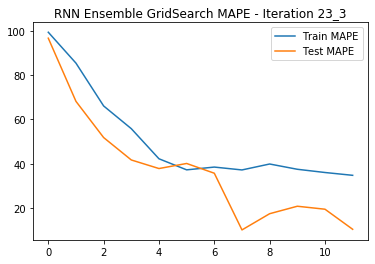

Epoch 1/80
69/69 [==============================] - 4s 64ms/step - loss: 10706082816.0000 - mean_absolute_percentage_error: 97.5663 - val_loss: 7204525568.0000 - val_mean_absolute_percentage_error: 92.4056
Epoch 2/80
69/69 [==============================] - 4s 58ms/step - loss: 7929596928.0000 - mean_absolute_percentage_error: 86.1021 - val_loss: 8266633216.0000 - val_mean_absolute_percentage_error: 99.5262
Epoch 3/80
69/69 [==============================] - 4s 58ms/step - loss: 6428776960.0000 - mean_absolute_percentage_error: 80.8311 - val_loss: 1980632960.0000 - val_mean_absolute_percentage_error: 41.1183
Epoch 4/80
69/69 [==============================] - 4s 58ms/step - loss: 7853267968.0000 - mean_absolute_percentage_error: 84.0338 - val_loss: 8340699136.0000 - val_mean_absolute_percentage_error: 99.9990
Epoch 5/80
69/69 [==============================] - 4s 57ms/step - loss: 8393492992.0000 - mean_absolute_percentage_error: 99.9813 - val_loss: 8340263936.0000 - val_mean_absolute_

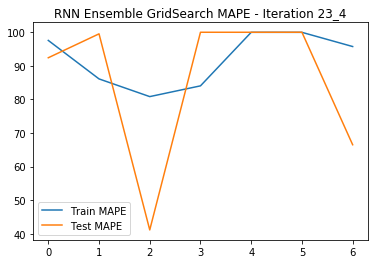

seq_length              24.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            3.000
learning_rate            0.001
epochs                  40.000
Name: 24, dtype: float64
Epoch 1/40
69/69 [==============================] - 8s 117ms/step - loss: 4353000960.0000 - mean_absolute_percentage_error: 61.3301 - val_loss: 550575296.0000 - val_mean_absolute_percentage_error: 20.5985
Epoch 2/40
69/69 [==============================] - 8s 111ms/step - loss: 340085536.0000 - mean_absolute_percentage_error: 15.6126 - val_loss: 185297856.0000 - val_mean_absolute_percentage_error: 11.2440
Epoch 3/40
69/69 [==============================] - 8s 110ms/step - loss: 190344480.0000 - mean_absolute_percentage_error: 11.8482 - val_loss: 154917008.0000 - val_mean_absolute_percentage_error: 10.1604
Epoch 4/40
69/69 [==============================] - 

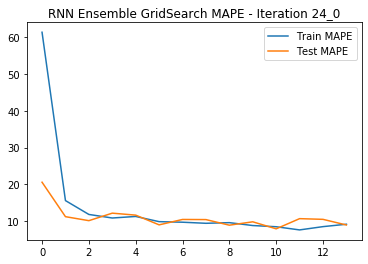

Epoch 1/40
69/69 [==============================] - 8s 116ms/step - loss: 5355088896.0000 - mean_absolute_percentage_error: 72.3756 - val_loss: 799143296.0000 - val_mean_absolute_percentage_error: 25.2721
Epoch 2/40
69/69 [==============================] - 7s 108ms/step - loss: 1509649536.0000 - mean_absolute_percentage_error: 35.0827 - val_loss: 495217760.0000 - val_mean_absolute_percentage_error: 18.9041
Epoch 3/40
69/69 [==============================] - 8s 110ms/step - loss: 308726304.0000 - mean_absolute_percentage_error: 14.7646 - val_loss: 213748448.0000 - val_mean_absolute_percentage_error: 14.2797
Epoch 4/40
69/69 [==============================] - 7s 108ms/step - loss: 169402240.0000 - mean_absolute_percentage_error: 11.0836 - val_loss: 175148256.0000 - val_mean_absolute_percentage_error: 10.7965
Epoch 5/40
69/69 [==============================] - 7s 108ms/step - loss: 155379040.0000 - mean_absolute_percentage_error: 10.8302 - val_loss: 128732528.0000 - val_mean_absolute_perc

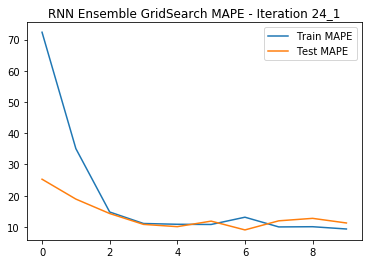

Epoch 1/40
69/69 [==============================] - 8s 115ms/step - loss: 6396017664.0000 - mean_absolute_percentage_error: 84.6964 - val_loss: 1914198912.0000 - val_mean_absolute_percentage_error: 40.3998
Epoch 2/40
69/69 [==============================] - 8s 109ms/step - loss: 1397996800.0000 - mean_absolute_percentage_error: 33.6149 - val_loss: 1083873408.0000 - val_mean_absolute_percentage_error: 29.5942
Epoch 3/40
69/69 [==============================] - 8s 109ms/step - loss: 686570560.0000 - mean_absolute_percentage_error: 22.0415 - val_loss: 545874048.0000 - val_mean_absolute_percentage_error: 17.8930
Epoch 4/40
69/69 [==============================] - 8s 110ms/step - loss: 417818080.0000 - mean_absolute_percentage_error: 16.5279 - val_loss: 315868896.0000 - val_mean_absolute_percentage_error: 14.8854
Epoch 5/40
69/69 [==============================] - 8s 110ms/step - loss: 259105136.0000 - mean_absolute_percentage_error: 13.4566 - val_loss: 212334096.0000 - val_mean_absolute_pe

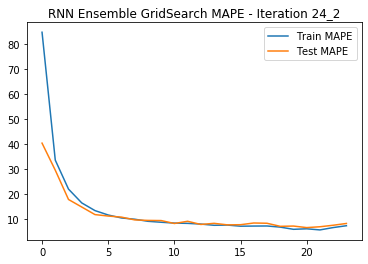

Epoch 1/40
69/69 [==============================] - 9s 128ms/step - loss: 8297838080.0000 - mean_absolute_percentage_error: 99.3746 - val_loss: 8118806016.0000 - val_mean_absolute_percentage_error: 98.5492
Epoch 2/40
69/69 [==============================] - 8s 116ms/step - loss: 3540281856.0000 - mean_absolute_percentage_error: 56.5489 - val_loss: 2458813952.0000 - val_mean_absolute_percentage_error: 51.2053
Epoch 3/40
69/69 [==============================] - 8s 115ms/step - loss: 4773604352.0000 - mean_absolute_percentage_error: 70.3058 - val_loss: 1766429056.0000 - val_mean_absolute_percentage_error: 42.7044
Epoch 4/40
69/69 [==============================] - 8s 116ms/step - loss: 409903936.0000 - mean_absolute_percentage_error: 17.3564 - val_loss: 629571456.0000 - val_mean_absolute_percentage_error: 25.6273
Epoch 5/40
69/69 [==============================] - 8s 116ms/step - loss: 365851392.0000 - mean_absolute_percentage_error: 17.1124 - val_loss: 286550624.0000 - val_mean_absolute_

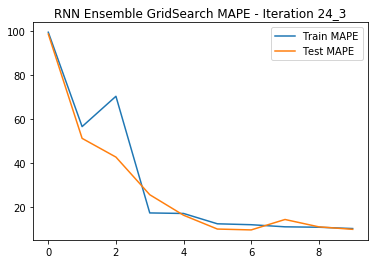

Epoch 1/40
69/69 [==============================] - 8s 120ms/step - loss: 4641695232.0000 - mean_absolute_percentage_error: 64.9753 - val_loss: 1332546944.0000 - val_mean_absolute_percentage_error: 33.9922
Epoch 2/40
69/69 [==============================] - 8s 111ms/step - loss: 544617280.0000 - mean_absolute_percentage_error: 20.7519 - val_loss: 392205824.0000 - val_mean_absolute_percentage_error: 16.4668
Epoch 3/40
69/69 [==============================] - 8s 113ms/step - loss: 311446912.0000 - mean_absolute_percentage_error: 15.3362 - val_loss: 145860304.0000 - val_mean_absolute_percentage_error: 10.1363
Epoch 4/40
69/69 [==============================] - 8s 113ms/step - loss: 173363280.0000 - mean_absolute_percentage_error: 11.1810 - val_loss: 299531776.0000 - val_mean_absolute_percentage_error: 15.4099
Epoch 5/40
69/69 [==============================] - 8s 113ms/step - loss: 184276416.0000 - mean_absolute_percentage_error: 11.6142 - val_loss: 347866080.0000 - val_mean_absolute_perc

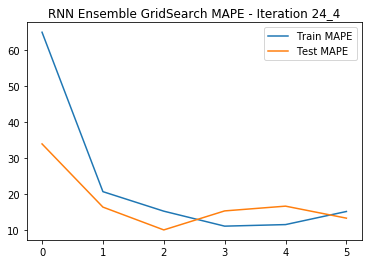

seq_length              24.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            3.000
learning_rate            0.001
epochs                  80.000
Name: 25, dtype: float64
Epoch 1/80
69/69 [==============================] - 8s 121ms/step - loss: 4353000960.0000 - mean_absolute_percentage_error: 61.3301 - val_loss: 550575296.0000 - val_mean_absolute_percentage_error: 20.5985
Epoch 2/80
69/69 [==============================] - 8s 114ms/step - loss: 340085536.0000 - mean_absolute_percentage_error: 15.6126 - val_loss: 185297856.0000 - val_mean_absolute_percentage_error: 11.2440
Epoch 3/80
69/69 [==============================] - 8s 114ms/step - loss: 190344480.0000 - mean_absolute_percentage_error: 11.8482 - val_loss: 154917008.0000 - val_mean_absolute_percentage_error: 10.1604
Epoch 4/80
69/69 [==============================] - 

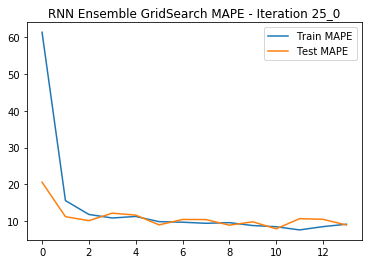

Epoch 1/80
69/69 [==============================] - 8s 119ms/step - loss: 5355088896.0000 - mean_absolute_percentage_error: 72.3756 - val_loss: 799143296.0000 - val_mean_absolute_percentage_error: 25.2721
Epoch 2/80
69/69 [==============================] - 8s 112ms/step - loss: 1509649536.0000 - mean_absolute_percentage_error: 35.0827 - val_loss: 495217760.0000 - val_mean_absolute_percentage_error: 18.9041
Epoch 3/80
69/69 [==============================] - 8s 112ms/step - loss: 308726304.0000 - mean_absolute_percentage_error: 14.7646 - val_loss: 213748448.0000 - val_mean_absolute_percentage_error: 14.2797
Epoch 4/80
69/69 [==============================] - 8s 113ms/step - loss: 169402240.0000 - mean_absolute_percentage_error: 11.0836 - val_loss: 175148256.0000 - val_mean_absolute_percentage_error: 10.7965
Epoch 5/80
69/69 [==============================] - 8s 113ms/step - loss: 155379040.0000 - mean_absolute_percentage_error: 10.8302 - val_loss: 128732528.0000 - val_mean_absolute_perc

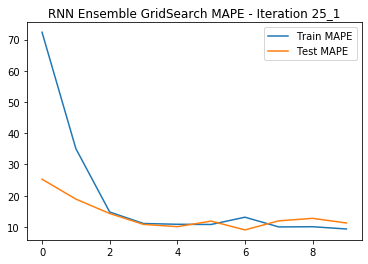

Epoch 1/80
69/69 [==============================] - 8s 116ms/step - loss: 6396017664.0000 - mean_absolute_percentage_error: 84.6964 - val_loss: 1914198912.0000 - val_mean_absolute_percentage_error: 40.3998
Epoch 2/80
69/69 [==============================] - 8s 109ms/step - loss: 1397996800.0000 - mean_absolute_percentage_error: 33.6149 - val_loss: 1083873408.0000 - val_mean_absolute_percentage_error: 29.5942
Epoch 3/80
69/69 [==============================] - 8s 110ms/step - loss: 686570560.0000 - mean_absolute_percentage_error: 22.0415 - val_loss: 545874048.0000 - val_mean_absolute_percentage_error: 17.8930
Epoch 4/80
69/69 [==============================] - 7s 107ms/step - loss: 417818080.0000 - mean_absolute_percentage_error: 16.5279 - val_loss: 315868896.0000 - val_mean_absolute_percentage_error: 14.8854
Epoch 5/80
69/69 [==============================] - 7s 104ms/step - loss: 259105136.0000 - mean_absolute_percentage_error: 13.4566 - val_loss: 212334096.0000 - val_mean_absolute_pe

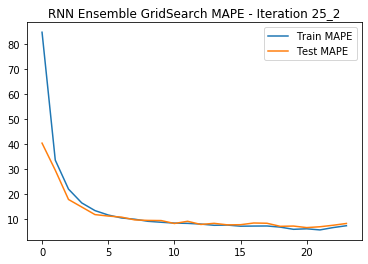

Epoch 1/80
69/69 [==============================] - 7s 107ms/step - loss: 8297838080.0000 - mean_absolute_percentage_error: 99.3746 - val_loss: 8118806016.0000 - val_mean_absolute_percentage_error: 98.5492
Epoch 2/80
69/69 [==============================] - 7s 102ms/step - loss: 3540281856.0000 - mean_absolute_percentage_error: 56.5489 - val_loss: 2458813952.0000 - val_mean_absolute_percentage_error: 51.2053
Epoch 3/80
69/69 [==============================] - 7s 102ms/step - loss: 4773604352.0000 - mean_absolute_percentage_error: 70.3058 - val_loss: 1766429056.0000 - val_mean_absolute_percentage_error: 42.7044
Epoch 4/80
69/69 [==============================] - 7s 100ms/step - loss: 409903936.0000 - mean_absolute_percentage_error: 17.3564 - val_loss: 629571456.0000 - val_mean_absolute_percentage_error: 25.6273
Epoch 5/80
69/69 [==============================] - 7s 100ms/step - loss: 365851392.0000 - mean_absolute_percentage_error: 17.1124 - val_loss: 286550624.0000 - val_mean_absolute_

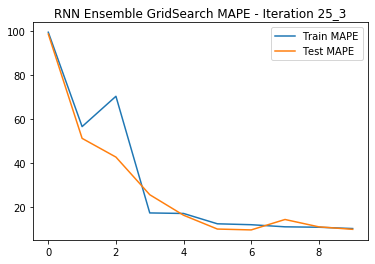

Epoch 1/80
69/69 [==============================] - 8s 114ms/step - loss: 4641695232.0000 - mean_absolute_percentage_error: 64.9753 - val_loss: 1332546944.0000 - val_mean_absolute_percentage_error: 33.9922
Epoch 2/80
69/69 [==============================] - 8s 109ms/step - loss: 544617280.0000 - mean_absolute_percentage_error: 20.7519 - val_loss: 392205824.0000 - val_mean_absolute_percentage_error: 16.4668
Epoch 3/80
69/69 [==============================] - 8s 110ms/step - loss: 311446912.0000 - mean_absolute_percentage_error: 15.3362 - val_loss: 145860304.0000 - val_mean_absolute_percentage_error: 10.1363
Epoch 4/80
69/69 [==============================] - 8s 110ms/step - loss: 173363280.0000 - mean_absolute_percentage_error: 11.1810 - val_loss: 299531776.0000 - val_mean_absolute_percentage_error: 15.4099
Epoch 5/80
69/69 [==============================] - 8s 110ms/step - loss: 184276416.0000 - mean_absolute_percentage_error: 11.6142 - val_loss: 347866080.0000 - val_mean_absolute_perc

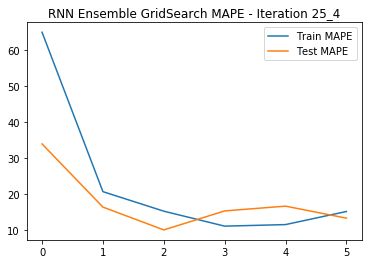

seq_length              24.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.00
stop_patience            3.00
learning_rate            0.01
epochs                  40.00
Name: 26, dtype: float64
Epoch 1/40
69/69 [==============================] - 8s 114ms/step - loss: 871513718784.0000 - mean_absolute_percentage_error: 183.9250 - val_loss: 7794142208.0000 - val_mean_absolute_percentage_error: 96.5231
Epoch 2/40
69/69 [==============================] - 8s 109ms/step - loss: 103261192192.0000 - mean_absolute_percentage_error: 105.0582 - val_loss: 8326065664.0000 - val_mean_absolute_percentage_error: 99.9008
Epoch 3/40
69/69 [==============================] - 8s 109ms/step - loss: 1518442624.0000 - mean_absolute_percentage_error: 32.4886 - val_loss: 274684864.0000 - val_mean_absolute_percentage_error: 13.6580
Epoch 4/40
69/69 [==============================] - 

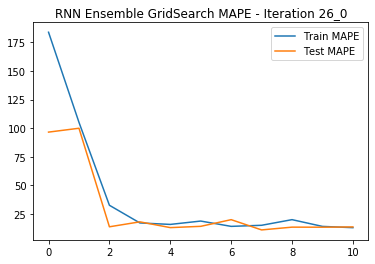

Epoch 1/40
69/69 [==============================] - 8s 112ms/step - loss: 1692381347840.0000 - mean_absolute_percentage_error: 232.0947 - val_loss: 1369678080.0000 - val_mean_absolute_percentage_error: 38.5178
Epoch 2/40
69/69 [==============================] - 7s 106ms/step - loss: 690212288.0000 - mean_absolute_percentage_error: 23.3181 - val_loss: 437569120.0000 - val_mean_absolute_percentage_error: 15.9930
Epoch 3/40
69/69 [==============================] - 7s 107ms/step - loss: 334622848.0000 - mean_absolute_percentage_error: 15.3748 - val_loss: 475873024.0000 - val_mean_absolute_percentage_error: 23.6170
Epoch 4/40
69/69 [==============================] - 7s 107ms/step - loss: 382065664.0000 - mean_absolute_percentage_error: 17.3628 - val_loss: 227784688.0000 - val_mean_absolute_percentage_error: 11.8000
Epoch 5/40
69/69 [==============================] - 7s 106ms/step - loss: 410517504.0000 - mean_absolute_percentage_error: 17.6045 - val_loss: 310218368.0000 - val_mean_absolute_

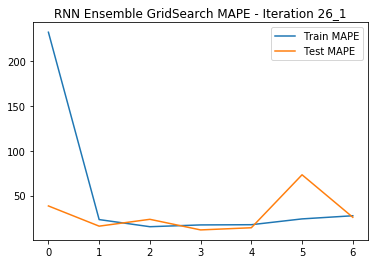

Epoch 1/40
69/69 [==============================] - 7s 109ms/step - loss: 5690921472.0000 - mean_absolute_percentage_error: 76.0501 - val_loss: 1910877568.0000 - val_mean_absolute_percentage_error: 40.2205
Epoch 2/40
69/69 [==============================] - 7s 104ms/step - loss: 19295320932352.0000 - mean_absolute_percentage_error: 691.3736 - val_loss: 8336017920.0000 - val_mean_absolute_percentage_error: 99.9672
Epoch 3/40
69/69 [==============================] - 7s 104ms/step - loss: 5277484032.0000 - mean_absolute_percentage_error: 72.0127 - val_loss: 649185600.0000 - val_mean_absolute_percentage_error: 22.4382
Epoch 4/40
69/69 [==============================] - 7s 104ms/step - loss: 1641954944.0000 - mean_absolute_percentage_error: 35.8393 - val_loss: 834271936.0000 - val_mean_absolute_percentage_error: 26.0793
Epoch 5/40
69/69 [==============================] - 7s 104ms/step - loss: 855914432.0000 - mean_absolute_percentage_error: 26.2404 - val_loss: 385521440.0000 - val_mean_abso

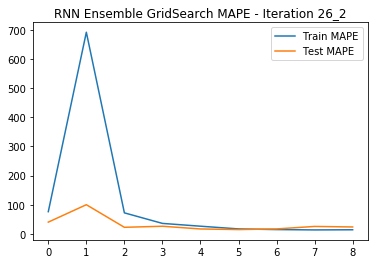

Epoch 1/40
69/69 [==============================] - 7s 107ms/step - loss: 29672951808.0000 - mean_absolute_percentage_error: 114.2202 - val_loss: 5420158976.0000 - val_mean_absolute_percentage_error: 59.4503
Epoch 2/40
69/69 [==============================] - 7s 101ms/step - loss: 84827848704.0000 - mean_absolute_percentage_error: 122.8192 - val_loss: 8335746048.0000 - val_mean_absolute_percentage_error: 99.9646
Epoch 3/40
69/69 [==============================] - 7s 101ms/step - loss: 4841552896.0000 - mean_absolute_percentage_error: 67.6377 - val_loss: 505307136.0000 - val_mean_absolute_percentage_error: 18.9598
Epoch 4/40
69/69 [==============================] - 7s 101ms/step - loss: 389043104.0000 - mean_absolute_percentage_error: 16.8965 - val_loss: 318834208.0000 - val_mean_absolute_percentage_error: 14.2896
Epoch 5/40
69/69 [==============================] - 7s 101ms/step - loss: 371413184.0000 - mean_absolute_percentage_error: 16.4024 - val_loss: 297042336.0000 - val_mean_absolu

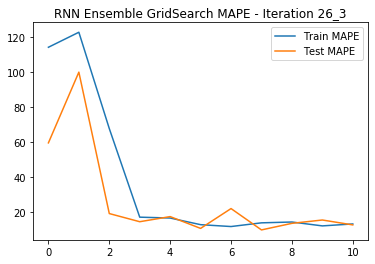

Epoch 1/40
69/69 [==============================] - 8s 117ms/step - loss: 37422166016.0000 - mean_absolute_percentage_error: 104.9605 - val_loss: 6882492416.0000 - val_mean_absolute_percentage_error: 90.2802
Epoch 2/40
69/69 [==============================] - 8s 112ms/step - loss: 5827225088.0000 - mean_absolute_percentage_error: 75.4585 - val_loss: 3282654208.0000 - val_mean_absolute_percentage_error: 55.5534
Epoch 3/40
69/69 [==============================] - 8s 112ms/step - loss: 8954408960.0000 - mean_absolute_percentage_error: 92.4607 - val_loss: 8110807040.0000 - val_mean_absolute_percentage_error: 98.5232
Epoch 4/40
69/69 [==============================] - 8s 112ms/step - loss: 7886538240.0000 - mean_absolute_percentage_error: 95.9550 - val_loss: 8080728064.0000 - val_mean_absolute_percentage_error: 98.3315
Epoch 5/40
69/69 [==============================] - 8s 113ms/step - loss: 4967159296.0000 - mean_absolute_percentage_error: 70.4804 - val_loss: 1464900352.0000 - val_mean_abs

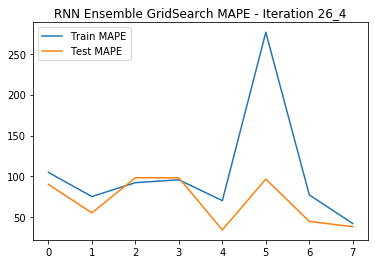

seq_length              24.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.00
stop_patience            3.00
learning_rate            0.01
epochs                  80.00
Name: 27, dtype: float64
Epoch 1/80
69/69 [==============================] - 8s 118ms/step - loss: 871513718784.0000 - mean_absolute_percentage_error: 183.9250 - val_loss: 7794142208.0000 - val_mean_absolute_percentage_error: 96.5231
Epoch 2/80
69/69 [==============================] - 8s 112ms/step - loss: 103261192192.0000 - mean_absolute_percentage_error: 105.0582 - val_loss: 8326065664.0000 - val_mean_absolute_percentage_error: 99.9008
Epoch 3/80
69/69 [==============================] - 8s 112ms/step - loss: 1518442624.0000 - mean_absolute_percentage_error: 32.4886 - val_loss: 274684864.0000 - val_mean_absolute_percentage_error: 13.6580
Epoch 4/80
69/69 [==============================] - 

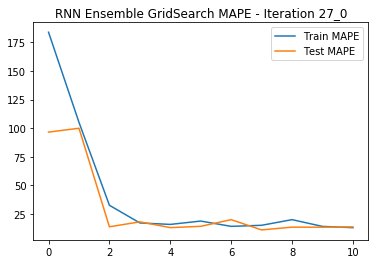

Epoch 1/80
69/69 [==============================] - 8s 115ms/step - loss: 1692381347840.0000 - mean_absolute_percentage_error: 232.0947 - val_loss: 1369678080.0000 - val_mean_absolute_percentage_error: 38.5178
Epoch 2/80
69/69 [==============================] - 8s 110ms/step - loss: 690212288.0000 - mean_absolute_percentage_error: 23.3181 - val_loss: 437569120.0000 - val_mean_absolute_percentage_error: 15.9930
Epoch 3/80
69/69 [==============================] - 8s 109ms/step - loss: 334622848.0000 - mean_absolute_percentage_error: 15.3748 - val_loss: 475873024.0000 - val_mean_absolute_percentage_error: 23.6170
Epoch 4/80
69/69 [==============================] - 8s 109ms/step - loss: 382065664.0000 - mean_absolute_percentage_error: 17.3628 - val_loss: 227784688.0000 - val_mean_absolute_percentage_error: 11.8000
Epoch 5/80
69/69 [==============================] - 8s 109ms/step - loss: 410517504.0000 - mean_absolute_percentage_error: 17.6045 - val_loss: 310218368.0000 - val_mean_absolute_

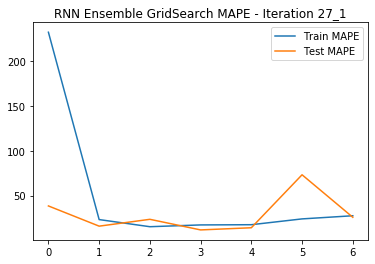

Epoch 1/80
69/69 [==============================] - 8s 112ms/step - loss: 5690921472.0000 - mean_absolute_percentage_error: 76.0501 - val_loss: 1910877568.0000 - val_mean_absolute_percentage_error: 40.2205
Epoch 2/80
69/69 [==============================] - 7s 107ms/step - loss: 19295320932352.0000 - mean_absolute_percentage_error: 691.3736 - val_loss: 8336017920.0000 - val_mean_absolute_percentage_error: 99.9672
Epoch 3/80
69/69 [==============================] - 7s 107ms/step - loss: 5277484032.0000 - mean_absolute_percentage_error: 72.0127 - val_loss: 649185600.0000 - val_mean_absolute_percentage_error: 22.4382
Epoch 4/80
69/69 [==============================] - 7s 107ms/step - loss: 1641954944.0000 - mean_absolute_percentage_error: 35.8393 - val_loss: 834271936.0000 - val_mean_absolute_percentage_error: 26.0793
Epoch 5/80
69/69 [==============================] - 7s 107ms/step - loss: 855914432.0000 - mean_absolute_percentage_error: 26.2404 - val_loss: 385521440.0000 - val_mean_abso

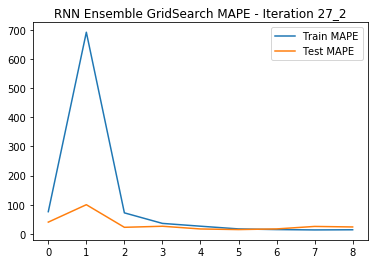

Epoch 1/80
69/69 [==============================] - 8s 110ms/step - loss: 29672951808.0000 - mean_absolute_percentage_error: 114.2202 - val_loss: 5420158976.0000 - val_mean_absolute_percentage_error: 59.4503
Epoch 2/80
69/69 [==============================] - 7s 104ms/step - loss: 84827848704.0000 - mean_absolute_percentage_error: 122.8192 - val_loss: 8335746048.0000 - val_mean_absolute_percentage_error: 99.9646
Epoch 3/80
69/69 [==============================] - 7s 104ms/step - loss: 4841552896.0000 - mean_absolute_percentage_error: 67.6377 - val_loss: 505307136.0000 - val_mean_absolute_percentage_error: 18.9598
Epoch 4/80
69/69 [==============================] - 7s 104ms/step - loss: 389043104.0000 - mean_absolute_percentage_error: 16.8965 - val_loss: 318834208.0000 - val_mean_absolute_percentage_error: 14.2896
Epoch 5/80
69/69 [==============================] - 7s 104ms/step - loss: 371413184.0000 - mean_absolute_percentage_error: 16.4024 - val_loss: 297042336.0000 - val_mean_absolu

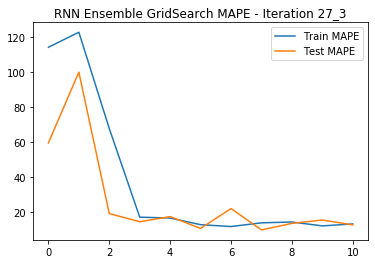

Epoch 1/80
69/69 [==============================] - 8s 112ms/step - loss: 37422166016.0000 - mean_absolute_percentage_error: 104.9605 - val_loss: 6882492416.0000 - val_mean_absolute_percentage_error: 90.2802
Epoch 2/80
69/69 [==============================] - 7s 107ms/step - loss: 5827225088.0000 - mean_absolute_percentage_error: 75.4585 - val_loss: 3282654208.0000 - val_mean_absolute_percentage_error: 55.5534
Epoch 3/80
69/69 [==============================] - 7s 107ms/step - loss: 8954408960.0000 - mean_absolute_percentage_error: 92.4607 - val_loss: 8110807040.0000 - val_mean_absolute_percentage_error: 98.5232
Epoch 4/80
69/69 [==============================] - 7s 107ms/step - loss: 7886538240.0000 - mean_absolute_percentage_error: 95.9550 - val_loss: 8080728064.0000 - val_mean_absolute_percentage_error: 98.3315
Epoch 5/80
69/69 [==============================] - 7s 107ms/step - loss: 4967159296.0000 - mean_absolute_percentage_error: 70.4804 - val_loss: 1464900352.0000 - val_mean_abs

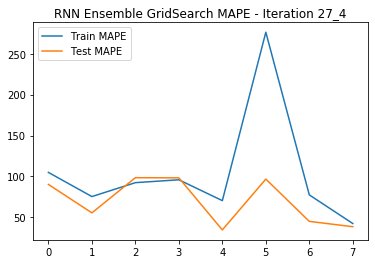

seq_length              24.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            4.000
learning_rate            0.001
epochs                  40.000
Name: 28, dtype: float64
Epoch 1/40
69/69 [==============================] - 9s 126ms/step - loss: 4353000960.0000 - mean_absolute_percentage_error: 61.3301 - val_loss: 550575296.0000 - val_mean_absolute_percentage_error: 20.5985
Epoch 2/40
69/69 [==============================] - 8s 121ms/step - loss: 340085536.0000 - mean_absolute_percentage_error: 15.6126 - val_loss: 185297856.0000 - val_mean_absolute_percentage_error: 11.2440
Epoch 3/40
69/69 [==============================] - 8s 120ms/step - loss: 190344480.0000 - mean_absolute_percentage_error: 11.8482 - val_loss: 154917008.0000 - val_mean_absolute_percentage_error: 10.1604
Epoch 4/40
69/69 [==============================] - 

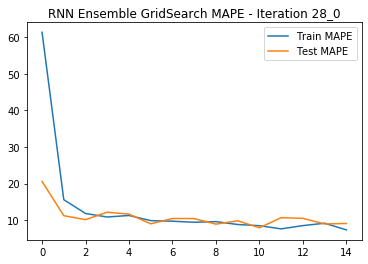

Epoch 1/40
69/69 [==============================] - 8s 123ms/step - loss: 7802990080.0000 - mean_absolute_percentage_error: 94.8526 - val_loss: 5851903488.0000 - val_mean_absolute_percentage_error: 82.7320
Epoch 2/40
69/69 [==============================] - 8s 117ms/step - loss: 1754738816.0000 - mean_absolute_percentage_error: 36.9039 - val_loss: 622667584.0000 - val_mean_absolute_percentage_error: 23.9669
Epoch 3/40
69/69 [==============================] - 8s 117ms/step - loss: 528184096.0000 - mean_absolute_percentage_error: 20.7432 - val_loss: 778840320.0000 - val_mean_absolute_percentage_error: 26.5596
Epoch 4/40
69/69 [==============================] - 8s 117ms/step - loss: 303758528.0000 - mean_absolute_percentage_error: 14.9210 - val_loss: 154682064.0000 - val_mean_absolute_percentage_error: 10.2172
Epoch 5/40
69/69 [==============================] - 8s 117ms/step - loss: 185873152.0000 - mean_absolute_percentage_error: 11.6628 - val_loss: 255155808.0000 - val_mean_absolute_per

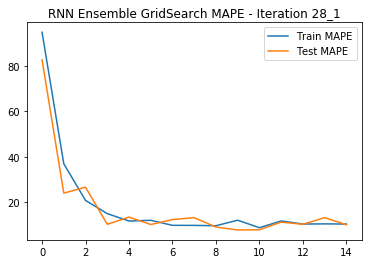

Epoch 1/40
69/69 [==============================] - 8s 119ms/step - loss: 5712598528.0000 - mean_absolute_percentage_error: 74.8780 - val_loss: 555818432.0000 - val_mean_absolute_percentage_error: 21.0965
Epoch 2/40
69/69 [==============================] - 8s 114ms/step - loss: 364623808.0000 - mean_absolute_percentage_error: 16.6377 - val_loss: 340041216.0000 - val_mean_absolute_percentage_error: 17.8985
Epoch 3/40
69/69 [==============================] - 8s 114ms/step - loss: 192006368.0000 - mean_absolute_percentage_error: 11.9216 - val_loss: 145067216.0000 - val_mean_absolute_percentage_error: 10.7245
Epoch 4/40
69/69 [==============================] - 8s 114ms/step - loss: 130674136.0000 - mean_absolute_percentage_error: 9.8305 - val_loss: 185327584.0000 - val_mean_absolute_percentage_error: 12.7782
Epoch 5/40
69/69 [==============================] - 8s 114ms/step - loss: 141526000.0000 - mean_absolute_percentage_error: 10.4535 - val_loss: 121282816.0000 - val_mean_absolute_percen

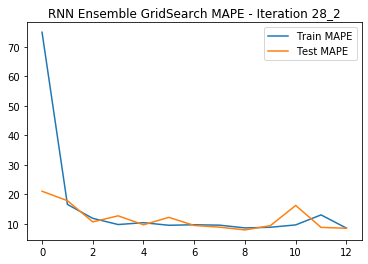

Epoch 1/40
69/69 [==============================] - 8s 117ms/step - loss: 5637507072.0000 - mean_absolute_percentage_error: 74.8534 - val_loss: 763825472.0000 - val_mean_absolute_percentage_error: 25.6527
Epoch 2/40
69/69 [==============================] - 8s 111ms/step - loss: 489921632.0000 - mean_absolute_percentage_error: 19.8395 - val_loss: 355305504.0000 - val_mean_absolute_percentage_error: 15.8221
Epoch 3/40
69/69 [==============================] - 8s 111ms/step - loss: 190300592.0000 - mean_absolute_percentage_error: 12.0236 - val_loss: 116800840.0000 - val_mean_absolute_percentage_error: 8.7249
Epoch 4/40
69/69 [==============================] - 8s 111ms/step - loss: 180173888.0000 - mean_absolute_percentage_error: 11.6509 - val_loss: 938139712.0000 - val_mean_absolute_percentage_error: 31.4882
Epoch 5/40
69/69 [==============================] - 8s 111ms/step - loss: 281864000.0000 - mean_absolute_percentage_error: 14.8275 - val_loss: 162289776.0000 - val_mean_absolute_percen

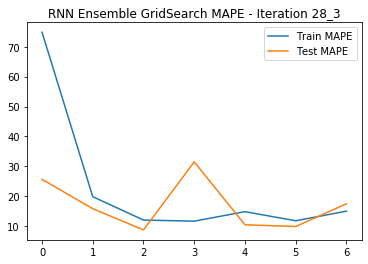

Epoch 1/40
69/69 [==============================] - 8s 113ms/step - loss: 8457179136.0000 - mean_absolute_percentage_error: 97.1696 - val_loss: 8071162368.0000 - val_mean_absolute_percentage_error: 98.3065
Epoch 2/40
69/69 [==============================] - 7s 108ms/step - loss: 2910376960.0000 - mean_absolute_percentage_error: 46.6068 - val_loss: 264178448.0000 - val_mean_absolute_percentage_error: 13.9731
Epoch 3/40
69/69 [==============================] - 7s 108ms/step - loss: 289631008.0000 - mean_absolute_percentage_error: 14.7439 - val_loss: 437229152.0000 - val_mean_absolute_percentage_error: 20.2372
Epoch 4/40
69/69 [==============================] - 7s 108ms/step - loss: 234192528.0000 - mean_absolute_percentage_error: 13.1787 - val_loss: 167439472.0000 - val_mean_absolute_percentage_error: 10.4831
Epoch 5/40
69/69 [==============================] - 7s 108ms/step - loss: 207982544.0000 - mean_absolute_percentage_error: 12.4852 - val_loss: 164102736.0000 - val_mean_absolute_per

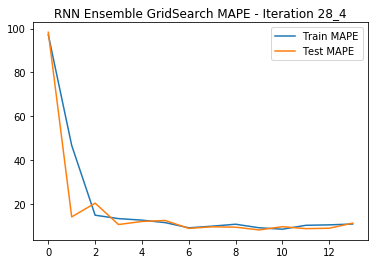

seq_length              24.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            4.000
learning_rate            0.001
epochs                  80.000
Name: 29, dtype: float64
Epoch 1/80
69/69 [==============================] - 8s 117ms/step - loss: 4353000960.0000 - mean_absolute_percentage_error: 61.3301 - val_loss: 550575296.0000 - val_mean_absolute_percentage_error: 20.5985
Epoch 2/80
69/69 [==============================] - 8s 112ms/step - loss: 340085536.0000 - mean_absolute_percentage_error: 15.6126 - val_loss: 185297856.0000 - val_mean_absolute_percentage_error: 11.2440
Epoch 3/80
69/69 [==============================] - 8s 112ms/step - loss: 190344480.0000 - mean_absolute_percentage_error: 11.8482 - val_loss: 154917008.0000 - val_mean_absolute_percentage_error: 10.1604
Epoch 4/80
69/69 [==============================] - 

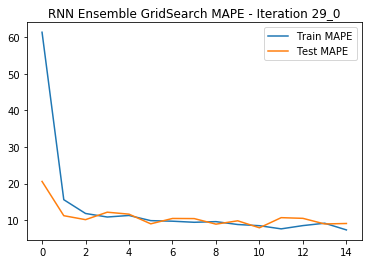

Epoch 1/80
69/69 [==============================] - 9s 123ms/step - loss: 7802990080.0000 - mean_absolute_percentage_error: 94.8526 - val_loss: 5851903488.0000 - val_mean_absolute_percentage_error: 82.7320
Epoch 2/80
69/69 [==============================] - 8s 118ms/step - loss: 1754738816.0000 - mean_absolute_percentage_error: 36.9039 - val_loss: 622667584.0000 - val_mean_absolute_percentage_error: 23.9669
Epoch 3/80
69/69 [==============================] - 8s 118ms/step - loss: 528184096.0000 - mean_absolute_percentage_error: 20.7432 - val_loss: 778840320.0000 - val_mean_absolute_percentage_error: 26.5596
Epoch 4/80
69/69 [==============================] - 8s 118ms/step - loss: 303758528.0000 - mean_absolute_percentage_error: 14.9210 - val_loss: 154682064.0000 - val_mean_absolute_percentage_error: 10.2172
Epoch 5/80
69/69 [==============================] - 8s 118ms/step - loss: 185873152.0000 - mean_absolute_percentage_error: 11.6628 - val_loss: 255155808.0000 - val_mean_absolute_per

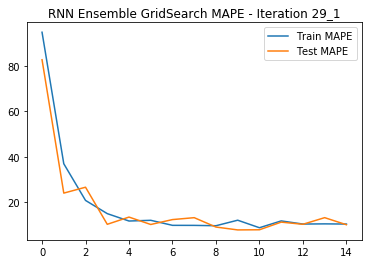

Epoch 1/80
69/69 [==============================] - 8s 120ms/step - loss: 5712598528.0000 - mean_absolute_percentage_error: 74.8780 - val_loss: 555818432.0000 - val_mean_absolute_percentage_error: 21.0965
Epoch 2/80
69/69 [==============================] - 8s 115ms/step - loss: 364623808.0000 - mean_absolute_percentage_error: 16.6377 - val_loss: 340041216.0000 - val_mean_absolute_percentage_error: 17.8985
Epoch 3/80
69/69 [==============================] - 8s 115ms/step - loss: 192006368.0000 - mean_absolute_percentage_error: 11.9216 - val_loss: 145067216.0000 - val_mean_absolute_percentage_error: 10.7245
Epoch 4/80
69/69 [==============================] - 8s 115ms/step - loss: 130674136.0000 - mean_absolute_percentage_error: 9.8305 - val_loss: 185327584.0000 - val_mean_absolute_percentage_error: 12.7782
Epoch 5/80
69/69 [==============================] - 8s 115ms/step - loss: 141526000.0000 - mean_absolute_percentage_error: 10.4535 - val_loss: 121282816.0000 - val_mean_absolute_percen

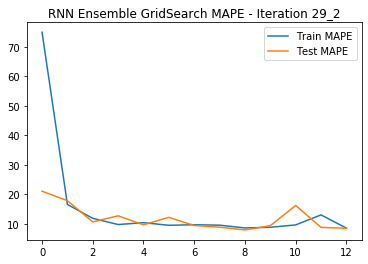

Epoch 1/80
69/69 [==============================] - 8s 117ms/step - loss: 5637507072.0000 - mean_absolute_percentage_error: 74.8534 - val_loss: 763825472.0000 - val_mean_absolute_percentage_error: 25.6527
Epoch 2/80
69/69 [==============================] - 8s 112ms/step - loss: 489921632.0000 - mean_absolute_percentage_error: 19.8395 - val_loss: 355305504.0000 - val_mean_absolute_percentage_error: 15.8221
Epoch 3/80
69/69 [==============================] - 8s 112ms/step - loss: 190300592.0000 - mean_absolute_percentage_error: 12.0236 - val_loss: 116800840.0000 - val_mean_absolute_percentage_error: 8.7249
Epoch 4/80
69/69 [==============================] - 8s 111ms/step - loss: 180173888.0000 - mean_absolute_percentage_error: 11.6509 - val_loss: 938139712.0000 - val_mean_absolute_percentage_error: 31.4882
Epoch 5/80
69/69 [==============================] - 8s 111ms/step - loss: 281864000.0000 - mean_absolute_percentage_error: 14.8275 - val_loss: 162289776.0000 - val_mean_absolute_percen

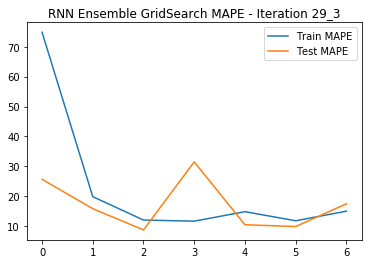

Epoch 1/80
69/69 [==============================] - 8s 114ms/step - loss: 8457179136.0000 - mean_absolute_percentage_error: 97.1696 - val_loss: 8071162368.0000 - val_mean_absolute_percentage_error: 98.3065
Epoch 2/80
69/69 [==============================] - 8s 109ms/step - loss: 2910376960.0000 - mean_absolute_percentage_error: 46.6068 - val_loss: 264178448.0000 - val_mean_absolute_percentage_error: 13.9731
Epoch 3/80
69/69 [==============================] - 8s 109ms/step - loss: 289631008.0000 - mean_absolute_percentage_error: 14.7439 - val_loss: 437229152.0000 - val_mean_absolute_percentage_error: 20.2372
Epoch 4/80
69/69 [==============================] - 7s 108ms/step - loss: 234192528.0000 - mean_absolute_percentage_error: 13.1787 - val_loss: 167439472.0000 - val_mean_absolute_percentage_error: 10.4831
Epoch 5/80
69/69 [==============================] - 7s 108ms/step - loss: 207982544.0000 - mean_absolute_percentage_error: 12.4852 - val_loss: 164102736.0000 - val_mean_absolute_per

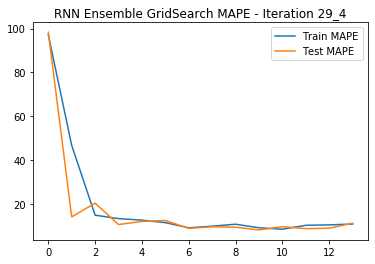

seq_length              24.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.00
stop_patience            4.00
learning_rate            0.01
epochs                  40.00
Name: 30, dtype: float64
Epoch 1/40
69/69 [==============================] - 8s 119ms/step - loss: 871513718784.0000 - mean_absolute_percentage_error: 183.9250 - val_loss: 7794142208.0000 - val_mean_absolute_percentage_error: 96.5231
Epoch 2/40
69/69 [==============================] - 8s 114ms/step - loss: 103261192192.0000 - mean_absolute_percentage_error: 105.0582 - val_loss: 8326065664.0000 - val_mean_absolute_percentage_error: 99.9008
Epoch 3/40
69/69 [==============================] - 8s 113ms/step - loss: 1518442624.0000 - mean_absolute_percentage_error: 32.4886 - val_loss: 274684864.0000 - val_mean_absolute_percentage_error: 13.6580
Epoch 4/40
69/69 [==============================] - 

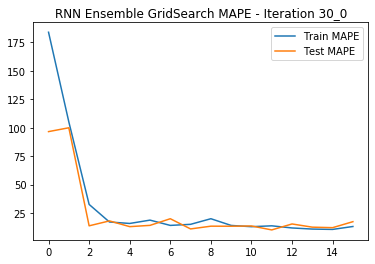

Epoch 1/40
69/69 [==============================] - 9s 123ms/step - loss: 7912416256.0000 - mean_absolute_percentage_error: 93.9749 - val_loss: 7441015296.0000 - val_mean_absolute_percentage_error: 93.9949
Epoch 2/40
69/69 [==============================] - 8s 118ms/step - loss: 7524371456.0000 - mean_absolute_percentage_error: 87.0819 - val_loss: 7701256192.0000 - val_mean_absolute_percentage_error: 95.7472
Epoch 3/40
69/69 [==============================] - 8s 118ms/step - loss: 10525235200.0000 - mean_absolute_percentage_error: 104.1542 - val_loss: 8340435968.0000 - val_mean_absolute_percentage_error: 99.9947
Epoch 4/40
69/69 [==============================] - 8s 118ms/step - loss: 8348956672.0000 - mean_absolute_percentage_error: 99.6373 - val_loss: 2906471680.0000 - val_mean_absolute_percentage_error: 55.4305
Epoch 5/40
69/69 [==============================] - 8s 118ms/step - loss: 4245487616.0000 - mean_absolute_percentage_error: 60.9615 - val_loss: 1529991168.0000 - val_mean_abs

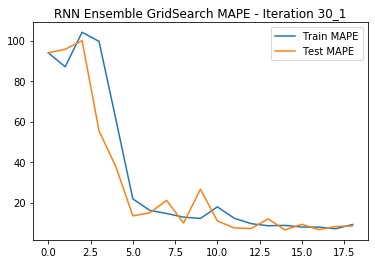

Epoch 1/40
69/69 [==============================] - 8s 120ms/step - loss: 62633963520.0000 - mean_absolute_percentage_error: 128.7911 - val_loss: 8309752832.0000 - val_mean_absolute_percentage_error: 99.8018
Epoch 2/40
69/69 [==============================] - 8s 114ms/step - loss: 22676774912.0000 - mean_absolute_percentage_error: 109.1963 - val_loss: 4025959168.0000 - val_mean_absolute_percentage_error: 66.5526
Epoch 3/40
69/69 [==============================] - 8s 114ms/step - loss: 6222176256.0000 - mean_absolute_percentage_error: 72.2804 - val_loss: 8025584128.0000 - val_mean_absolute_percentage_error: 97.9843
Epoch 4/40
69/69 [==============================] - 8s 114ms/step - loss: 7979976192.0000 - mean_absolute_percentage_error: 91.6814 - val_loss: 2698267904.0000 - val_mean_absolute_percentage_error: 47.6180
Epoch 5/40
69/69 [==============================] - 8s 114ms/step - loss: 8145028608.0000 - mean_absolute_percentage_error: 97.9697 - val_loss: 8325307904.0000 - val_mean_a

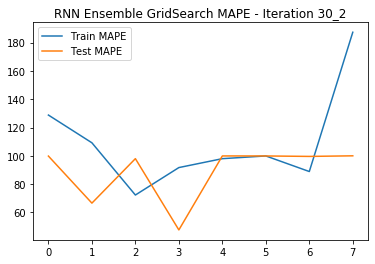

Epoch 1/40
69/69 [==============================] - 8s 117ms/step - loss: 8265148416.0000 - mean_absolute_percentage_error: 68.9077 - val_loss: 266514800.0000 - val_mean_absolute_percentage_error: 16.0096
Epoch 2/40
69/69 [==============================] - 8s 111ms/step - loss: 1305321472.0000 - mean_absolute_percentage_error: 31.8520 - val_loss: 2922270208.0000 - val_mean_absolute_percentage_error: 61.0007
Epoch 3/40
69/69 [==============================] - 8s 111ms/step - loss: 413949216.0000 - mean_absolute_percentage_error: 17.6465 - val_loss: 173277392.0000 - val_mean_absolute_percentage_error: 10.1495
Epoch 4/40
69/69 [==============================] - 8s 111ms/step - loss: 337154624.0000 - mean_absolute_percentage_error: 15.1704 - val_loss: 439720928.0000 - val_mean_absolute_percentage_error: 20.6506
Epoch 5/40
69/69 [==============================] - 8s 111ms/step - loss: 282191008.0000 - mean_absolute_percentage_error: 14.6882 - val_loss: 247140848.0000 - val_mean_absolute_per

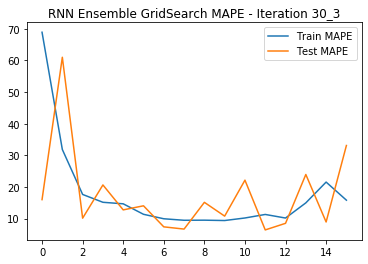

Epoch 1/40
69/69 [==============================] - 8s 114ms/step - loss: 4912755712.0000 - mean_absolute_percentage_error: 68.6362 - val_loss: 5815069184.0000 - val_mean_absolute_percentage_error: 82.3287
Epoch 2/40
69/69 [==============================] - 8s 109ms/step - loss: 6951355904.0000 - mean_absolute_percentage_error: 85.0763 - val_loss: 2235055872.0000 - val_mean_absolute_percentage_error: 45.4836
Epoch 3/40
69/69 [==============================] - 8s 110ms/step - loss: 5154829312.0000 - mean_absolute_percentage_error: 67.8115 - val_loss: 8317747712.0000 - val_mean_absolute_percentage_error: 99.8508
Epoch 4/40
69/69 [==============================] - 8s 109ms/step - loss: 8865167360.0000 - mean_absolute_percentage_error: 98.9045 - val_loss: 8344242688.0000 - val_mean_absolute_percentage_error: 100.0191
Epoch 5/40
69/69 [==============================] - 8s 110ms/step - loss: 8423269888.0000 - mean_absolute_percentage_error: 99.4320 - val_loss: 8298638336.0000 - val_mean_abso

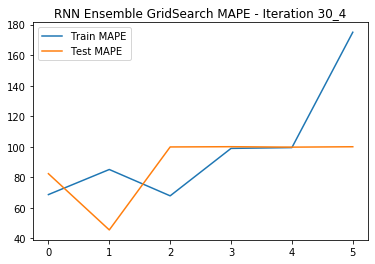

seq_length              24.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.00
stop_patience            4.00
learning_rate            0.01
epochs                  80.00
Name: 31, dtype: float64
Epoch 1/80
69/69 [==============================] - 8s 120ms/step - loss: 871513718784.0000 - mean_absolute_percentage_error: 183.9250 - val_loss: 7794142208.0000 - val_mean_absolute_percentage_error: 96.5231
Epoch 2/80
69/69 [==============================] - 8s 115ms/step - loss: 103261192192.0000 - mean_absolute_percentage_error: 105.0582 - val_loss: 8326065664.0000 - val_mean_absolute_percentage_error: 99.9008
Epoch 3/80
69/69 [==============================] - 8s 114ms/step - loss: 1518442624.0000 - mean_absolute_percentage_error: 32.4886 - val_loss: 274684864.0000 - val_mean_absolute_percentage_error: 13.6580
Epoch 4/80
69/69 [==============================] - 

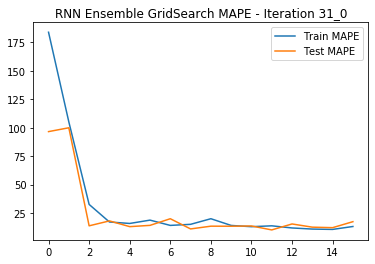

Epoch 1/80
69/69 [==============================] - 8s 121ms/step - loss: 7912416256.0000 - mean_absolute_percentage_error: 93.9749 - val_loss: 7441015296.0000 - val_mean_absolute_percentage_error: 93.9949
Epoch 2/80
69/69 [==============================] - 8s 116ms/step - loss: 7524371456.0000 - mean_absolute_percentage_error: 87.0819 - val_loss: 7701256192.0000 - val_mean_absolute_percentage_error: 95.7472
Epoch 3/80
69/69 [==============================] - 8s 116ms/step - loss: 10525235200.0000 - mean_absolute_percentage_error: 104.1542 - val_loss: 8340435968.0000 - val_mean_absolute_percentage_error: 99.9947
Epoch 4/80
69/69 [==============================] - 8s 116ms/step - loss: 8348956672.0000 - mean_absolute_percentage_error: 99.6373 - val_loss: 2906471680.0000 - val_mean_absolute_percentage_error: 55.4305
Epoch 5/80
69/69 [==============================] - 8s 116ms/step - loss: 4245487616.0000 - mean_absolute_percentage_error: 60.9615 - val_loss: 1529991168.0000 - val_mean_abs

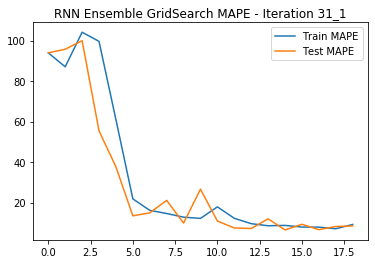

Epoch 1/80
69/69 [==============================] - 9s 126ms/step - loss: 62633963520.0000 - mean_absolute_percentage_error: 128.7911 - val_loss: 8309752832.0000 - val_mean_absolute_percentage_error: 99.8018
Epoch 2/80
69/69 [==============================] - 8s 121ms/step - loss: 22676774912.0000 - mean_absolute_percentage_error: 109.1963 - val_loss: 4025959168.0000 - val_mean_absolute_percentage_error: 66.5526
Epoch 3/80
69/69 [==============================] - 8s 121ms/step - loss: 6222176256.0000 - mean_absolute_percentage_error: 72.2804 - val_loss: 8025584128.0000 - val_mean_absolute_percentage_error: 97.9843
Epoch 4/80
69/69 [==============================] - 8s 120ms/step - loss: 7979976192.0000 - mean_absolute_percentage_error: 91.6814 - val_loss: 2698267904.0000 - val_mean_absolute_percentage_error: 47.6180
Epoch 5/80
69/69 [==============================] - 8s 120ms/step - loss: 8145028608.0000 - mean_absolute_percentage_error: 97.9697 - val_loss: 8325307904.0000 - val_mean_a

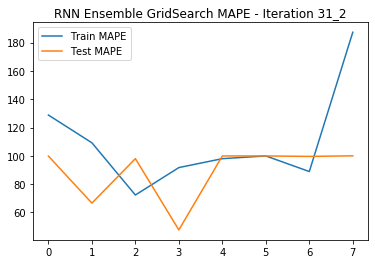

Epoch 1/80
69/69 [==============================] - 9s 135ms/step - loss: 8265148416.0000 - mean_absolute_percentage_error: 68.9077 - val_loss: 266514800.0000 - val_mean_absolute_percentage_error: 16.0096
Epoch 2/80
69/69 [==============================] - 9s 130ms/step - loss: 1305321472.0000 - mean_absolute_percentage_error: 31.8520 - val_loss: 2922270208.0000 - val_mean_absolute_percentage_error: 61.0007
Epoch 3/80
69/69 [==============================] - 9s 130ms/step - loss: 413949216.0000 - mean_absolute_percentage_error: 17.6465 - val_loss: 173277392.0000 - val_mean_absolute_percentage_error: 10.1495
Epoch 4/80
69/69 [==============================] - 9s 130ms/step - loss: 337154624.0000 - mean_absolute_percentage_error: 15.1704 - val_loss: 439720928.0000 - val_mean_absolute_percentage_error: 20.6506
Epoch 5/80
69/69 [==============================] - 9s 130ms/step - loss: 282191008.0000 - mean_absolute_percentage_error: 14.6882 - val_loss: 247140848.0000 - val_mean_absolute_per

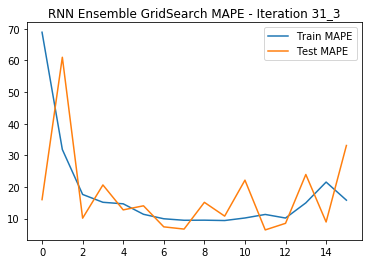

Epoch 1/80
69/69 [==============================] - 9s 132ms/step - loss: 4912755712.0000 - mean_absolute_percentage_error: 68.6362 - val_loss: 5815069184.0000 - val_mean_absolute_percentage_error: 82.3287
Epoch 2/80
69/69 [==============================] - 9s 126ms/step - loss: 6951355904.0000 - mean_absolute_percentage_error: 85.0763 - val_loss: 2235055872.0000 - val_mean_absolute_percentage_error: 45.4836
Epoch 3/80
69/69 [==============================] - 9s 127ms/step - loss: 5154829312.0000 - mean_absolute_percentage_error: 67.8115 - val_loss: 8317747712.0000 - val_mean_absolute_percentage_error: 99.8508
Epoch 4/80
69/69 [==============================] - 9s 126ms/step - loss: 8865167360.0000 - mean_absolute_percentage_error: 98.9045 - val_loss: 8344242688.0000 - val_mean_absolute_percentage_error: 100.0191
Epoch 5/80
69/69 [==============================] - 9s 126ms/step - loss: 8423269888.0000 - mean_absolute_percentage_error: 99.4320 - val_loss: 8298638336.0000 - val_mean_abso

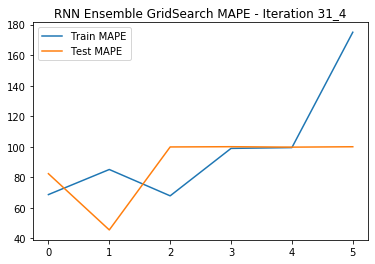

seq_length              24.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            3.000
learning_rate            0.001
epochs                  40.000
Name: 32, dtype: float64
Epoch 1/40
69/69 [==============================] - 9s 135ms/step - loss: 4507397120.0000 - mean_absolute_percentage_error: 64.3816 - val_loss: 641572608.0000 - val_mean_absolute_percentage_error: 23.3835
Epoch 2/40
69/69 [==============================] - 9s 130ms/step - loss: 1420638720.0000 - mean_absolute_percentage_error: 34.0625 - val_loss: 888078848.0000 - val_mean_absolute_percentage_error: 29.1858
Epoch 3/40
69/69 [==============================] - 9s 130ms/step - loss: 1260448384.0000 - mean_absolute_percentage_error: 31.6797 - val_loss: 1115357696.0000 - val_mean_absolute_percentage_error: 33.8490
Epoch 4/40
69/69 [==============================]

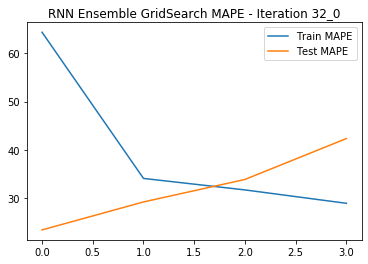

Epoch 1/40
69/69 [==============================] - 9s 132ms/step - loss: 5872741376.0000 - mean_absolute_percentage_error: 78.3306 - val_loss: 623417984.0000 - val_mean_absolute_percentage_error: 22.2162
Epoch 2/40
69/69 [==============================] - 9s 126ms/step - loss: 1828600448.0000 - mean_absolute_percentage_error: 38.9562 - val_loss: 1450234624.0000 - val_mean_absolute_percentage_error: 38.5598
Epoch 3/40
69/69 [==============================] - 9s 126ms/step - loss: 1438778240.0000 - mean_absolute_percentage_error: 34.1095 - val_loss: 168939472.0000 - val_mean_absolute_percentage_error: 10.7863
Epoch 4/40
69/69 [==============================] - 9s 127ms/step - loss: 1406247296.0000 - mean_absolute_percentage_error: 33.0400 - val_loss: 1350153600.0000 - val_mean_absolute_percentage_error: 38.1076
Epoch 5/40
69/69 [==============================] - 9s 126ms/step - loss: 851221568.0000 - mean_absolute_percentage_error: 25.7931 - val_loss: 148922464.0000 - val_mean_absolute_

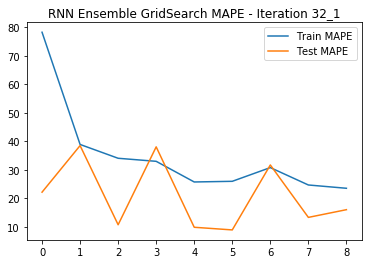

Epoch 1/40
69/69 [==============================] - 9s 129ms/step - loss: 5523667456.0000 - mean_absolute_percentage_error: 73.2620 - val_loss: 950065600.0000 - val_mean_absolute_percentage_error: 27.3523
Epoch 2/40
69/69 [==============================] - 9s 125ms/step - loss: 1859692800.0000 - mean_absolute_percentage_error: 38.6887 - val_loss: 1156437504.0000 - val_mean_absolute_percentage_error: 33.6144
Epoch 3/40
69/69 [==============================] - 9s 124ms/step - loss: 1209008128.0000 - mean_absolute_percentage_error: 30.9497 - val_loss: 367458336.0000 - val_mean_absolute_percentage_error: 16.7212
Epoch 4/40
69/69 [==============================] - 9s 124ms/step - loss: 969604224.0000 - mean_absolute_percentage_error: 27.6250 - val_loss: 1072036864.0000 - val_mean_absolute_percentage_error: 33.2976
Epoch 5/40
69/69 [==============================] - 9s 124ms/step - loss: 878062144.0000 - mean_absolute_percentage_error: 26.2308 - val_loss: 846297984.0000 - val_mean_absolute_p

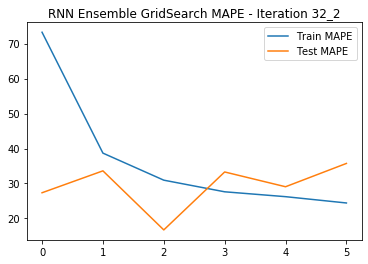

Epoch 1/40
69/69 [==============================] - 9s 129ms/step - loss: 6337869824.0000 - mean_absolute_percentage_error: 82.0486 - val_loss: 1636132096.0000 - val_mean_absolute_percentage_error: 39.1035
Epoch 2/40
69/69 [==============================] - 9s 124ms/step - loss: 1638906240.0000 - mean_absolute_percentage_error: 35.8534 - val_loss: 1780453760.0000 - val_mean_absolute_percentage_error: 44.3366
Epoch 3/40
69/69 [==============================] - 9s 124ms/step - loss: 1304709632.0000 - mean_absolute_percentage_error: 31.7514 - val_loss: 1778606336.0000 - val_mean_absolute_percentage_error: 43.9406
Epoch 4/40
69/69 [==============================] - 9s 124ms/step - loss: 1239335168.0000 - mean_absolute_percentage_error: 31.1720 - val_loss: 1152054016.0000 - val_mean_absolute_percentage_error: 34.9633
Epoch 5/40
69/69 [==============================] - 9s 124ms/step - loss: 1052686976.0000 - mean_absolute_percentage_error: 28.8262 - val_loss: 362934784.0000 - val_mean_absolu

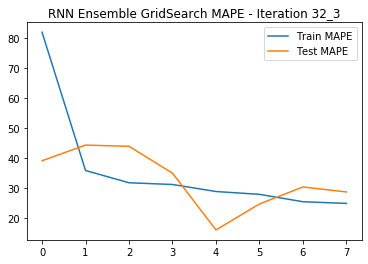

Epoch 1/40
69/69 [==============================] - 10s 142ms/step - loss: 4774548992.0000 - mean_absolute_percentage_error: 66.1506 - val_loss: 2719771648.0000 - val_mean_absolute_percentage_error: 54.5680
Epoch 2/40
69/69 [==============================] - 9s 135ms/step - loss: 2548114432.0000 - mean_absolute_percentage_error: 46.4111 - val_loss: 392039136.0000 - val_mean_absolute_percentage_error: 17.4475
Epoch 3/40
69/69 [==============================] - 9s 135ms/step - loss: 936967360.0000 - mean_absolute_percentage_error: 26.9919 - val_loss: 124705104.0000 - val_mean_absolute_percentage_error: 9.8164
Epoch 4/40
69/69 [==============================] - 9s 135ms/step - loss: 853900864.0000 - mean_absolute_percentage_error: 25.7970 - val_loss: 429253472.0000 - val_mean_absolute_percentage_error: 18.8097
Epoch 5/40
69/69 [==============================] - 9s 135ms/step - loss: 718692224.0000 - mean_absolute_percentage_error: 23.4958 - val_loss: 112502776.0000 - val_mean_absolute_per

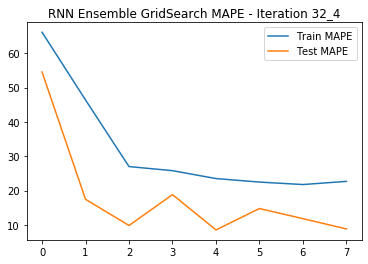

seq_length              24.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            3.000
learning_rate            0.001
epochs                  80.000
Name: 33, dtype: float64
Epoch 1/80
69/69 [==============================] - 10s 141ms/step - loss: 4507397120.0000 - mean_absolute_percentage_error: 64.3816 - val_loss: 641572608.0000 - val_mean_absolute_percentage_error: 23.3835
Epoch 2/80
69/69 [==============================] - 9s 135ms/step - loss: 1420638720.0000 - mean_absolute_percentage_error: 34.0625 - val_loss: 888078848.0000 - val_mean_absolute_percentage_error: 29.1858
Epoch 3/80
69/69 [==============================] - 9s 135ms/step - loss: 1260448384.0000 - mean_absolute_percentage_error: 31.6797 - val_loss: 1115357696.0000 - val_mean_absolute_percentage_error: 33.8490
Epoch 4/80
69/69 [==============================

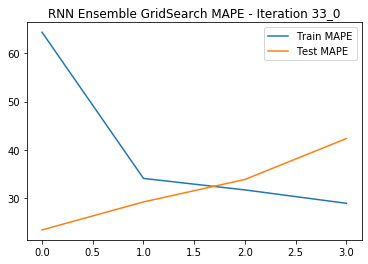

Epoch 1/80
69/69 [==============================] - 9s 138ms/step - loss: 5872741376.0000 - mean_absolute_percentage_error: 78.3306 - val_loss: 623417984.0000 - val_mean_absolute_percentage_error: 22.2162
Epoch 2/80
69/69 [==============================] - 9s 131ms/step - loss: 1828600448.0000 - mean_absolute_percentage_error: 38.9562 - val_loss: 1450234624.0000 - val_mean_absolute_percentage_error: 38.5598
Epoch 3/80
69/69 [==============================] - 9s 132ms/step - loss: 1438778240.0000 - mean_absolute_percentage_error: 34.1095 - val_loss: 168939472.0000 - val_mean_absolute_percentage_error: 10.7863
Epoch 4/80
69/69 [==============================] - 9s 132ms/step - loss: 1406247296.0000 - mean_absolute_percentage_error: 33.0400 - val_loss: 1350153600.0000 - val_mean_absolute_percentage_error: 38.1076
Epoch 5/80
69/69 [==============================] - 9s 131ms/step - loss: 851221568.0000 - mean_absolute_percentage_error: 25.7931 - val_loss: 148922464.0000 - val_mean_absolute_

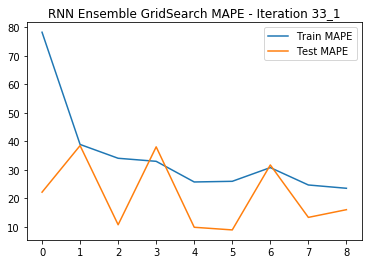

Epoch 1/80
69/69 [==============================] - 9s 133ms/step - loss: 5523667456.0000 - mean_absolute_percentage_error: 73.2620 - val_loss: 950065600.0000 - val_mean_absolute_percentage_error: 27.3523
Epoch 2/80
69/69 [==============================] - 9s 128ms/step - loss: 1859692800.0000 - mean_absolute_percentage_error: 38.6887 - val_loss: 1156437504.0000 - val_mean_absolute_percentage_error: 33.6144
Epoch 3/80
69/69 [==============================] - 9s 128ms/step - loss: 1209008128.0000 - mean_absolute_percentage_error: 30.9497 - val_loss: 367458336.0000 - val_mean_absolute_percentage_error: 16.7212
Epoch 4/80
69/69 [==============================] - 9s 128ms/step - loss: 969604224.0000 - mean_absolute_percentage_error: 27.6250 - val_loss: 1072036864.0000 - val_mean_absolute_percentage_error: 33.2976
Epoch 5/80
69/69 [==============================] - 9s 128ms/step - loss: 878062144.0000 - mean_absolute_percentage_error: 26.2308 - val_loss: 846297984.0000 - val_mean_absolute_p

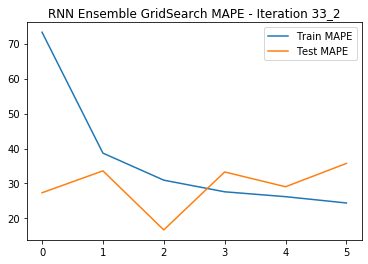

Epoch 1/80
69/69 [==============================] - 9s 131ms/step - loss: 6337869824.0000 - mean_absolute_percentage_error: 82.0486 - val_loss: 1636132096.0000 - val_mean_absolute_percentage_error: 39.1035
Epoch 2/80
69/69 [==============================] - 9s 126ms/step - loss: 1638906240.0000 - mean_absolute_percentage_error: 35.8534 - val_loss: 1780453760.0000 - val_mean_absolute_percentage_error: 44.3366
Epoch 3/80
69/69 [==============================] - 9s 125ms/step - loss: 1304709632.0000 - mean_absolute_percentage_error: 31.7514 - val_loss: 1778606336.0000 - val_mean_absolute_percentage_error: 43.9406
Epoch 4/80
69/69 [==============================] - 9s 125ms/step - loss: 1239335168.0000 - mean_absolute_percentage_error: 31.1720 - val_loss: 1152054016.0000 - val_mean_absolute_percentage_error: 34.9633
Epoch 5/80
69/69 [==============================] - 9s 125ms/step - loss: 1052686976.0000 - mean_absolute_percentage_error: 28.8262 - val_loss: 362934784.0000 - val_mean_absolu

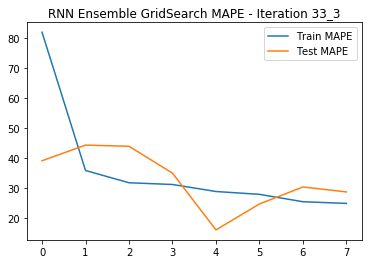

Epoch 1/80
69/69 [==============================] - 9s 133ms/step - loss: 4774548992.0000 - mean_absolute_percentage_error: 66.1506 - val_loss: 2719771648.0000 - val_mean_absolute_percentage_error: 54.5680
Epoch 2/80
69/69 [==============================] - 9s 127ms/step - loss: 2548114432.0000 - mean_absolute_percentage_error: 46.4111 - val_loss: 392039136.0000 - val_mean_absolute_percentage_error: 17.4475
Epoch 3/80
69/69 [==============================] - 9s 127ms/step - loss: 936967360.0000 - mean_absolute_percentage_error: 26.9919 - val_loss: 124705104.0000 - val_mean_absolute_percentage_error: 9.8164
Epoch 4/80
69/69 [==============================] - 9s 127ms/step - loss: 853900864.0000 - mean_absolute_percentage_error: 25.7970 - val_loss: 429253472.0000 - val_mean_absolute_percentage_error: 18.8097
Epoch 5/80
69/69 [==============================] - 9s 127ms/step - loss: 718692224.0000 - mean_absolute_percentage_error: 23.4958 - val_loss: 112502776.0000 - val_mean_absolute_perc

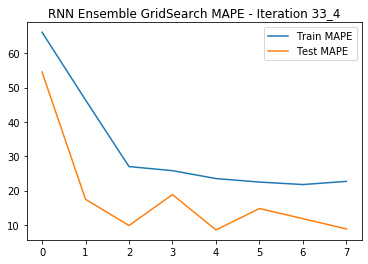

seq_length              24.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.20
stop_patience            3.00
learning_rate            0.01
epochs                  40.00
Name: 34, dtype: float64
Epoch 1/40
69/69 [==============================] - 10s 147ms/step - loss: 162355838976.0000 - mean_absolute_percentage_error: 133.5262 - val_loss: 8250429952.0000 - val_mean_absolute_percentage_error: 99.4165
Epoch 2/40
69/69 [==============================] - 10s 142ms/step - loss: 7152850944.0000 - mean_absolute_percentage_error: 88.3357 - val_loss: 7677484544.0000 - val_mean_absolute_percentage_error: 95.5029
Epoch 3/40
69/69 [==============================] - 10s 142ms/step - loss: 9483283456.0000 - mean_absolute_percentage_error: 80.1640 - val_loss: 8340644864.0000 - val_mean_absolute_percentage_error: 99.9959
Epoch 4/40
69/69 [==============================] -

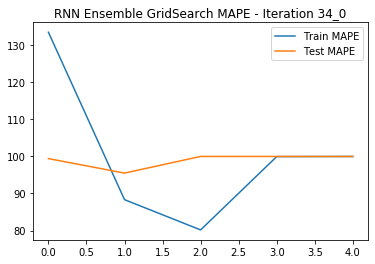

Epoch 1/40
69/69 [==============================] - 10s 143ms/step - loss: 11182183424.0000 - mean_absolute_percentage_error: 96.4544 - val_loss: 2303255552.0000 - val_mean_absolute_percentage_error: 45.0511
Epoch 2/40
69/69 [==============================] - 10s 138ms/step - loss: 5103987712.0000 - mean_absolute_percentage_error: 65.3799 - val_loss: 1143200256.0000 - val_mean_absolute_percentage_error: 32.2639
Epoch 3/40
69/69 [==============================] - 10s 139ms/step - loss: 966168384.0000 - mean_absolute_percentage_error: 27.0760 - val_loss: 215915456.0000 - val_mean_absolute_percentage_error: 11.0298
Epoch 4/40
69/69 [==============================] - 10s 138ms/step - loss: 810350080.0000 - mean_absolute_percentage_error: 25.2704 - val_loss: 232860720.0000 - val_mean_absolute_percentage_error: 12.0519
Epoch 5/40
69/69 [==============================] - 10s 138ms/step - loss: 754628160.0000 - mean_absolute_percentage_error: 24.4534 - val_loss: 446521600.0000 - val_mean_absol

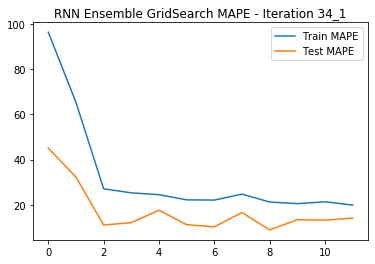

Epoch 1/40
69/69 [==============================] - 10s 140ms/step - loss: 12883889152.0000 - mean_absolute_percentage_error: 98.4957 - val_loss: 8339636224.0000 - val_mean_absolute_percentage_error: 99.9894
Epoch 2/40
69/69 [==============================] - 9s 135ms/step - loss: 8004453888.0000 - mean_absolute_percentage_error: 95.2607 - val_loss: 6943376896.0000 - val_mean_absolute_percentage_error: 90.5438
Epoch 3/40
69/69 [==============================] - 9s 134ms/step - loss: 7479233536.0000 - mean_absolute_percentage_error: 90.9827 - val_loss: 8309544960.0000 - val_mean_absolute_percentage_error: 99.7990
Epoch 4/40
69/69 [==============================] - 9s 134ms/step - loss: 8106740224.0000 - mean_absolute_percentage_error: 96.7758 - val_loss: 8312386560.0000 - val_mean_absolute_percentage_error: 99.8147
Epoch 5/40
69/69 [==============================] - 9s 134ms/step - loss: 8461957632.0000 - mean_absolute_percentage_error: 98.8931 - val_loss: 8337884672.0000 - val_mean_abs

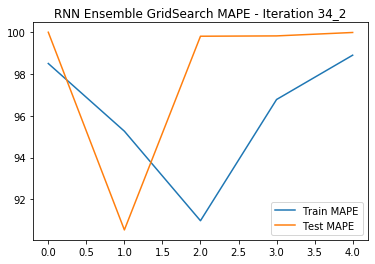

Epoch 1/40
69/69 [==============================] - 9s 137ms/step - loss: 5612046336.0000 - mean_absolute_percentage_error: 76.5658 - val_loss: 22899630080.0000 - val_mean_absolute_percentage_error: 140.3599
Epoch 2/40
69/69 [==============================] - 9s 131ms/step - loss: 7744439808.0000 - mean_absolute_percentage_error: 94.1818 - val_loss: 14988051456.0000 - val_mean_absolute_percentage_error: 100.2865
Epoch 3/40
69/69 [==============================] - 9s 131ms/step - loss: 8925059072.0000 - mean_absolute_percentage_error: 99.7836 - val_loss: 8090571776.0000 - val_mean_absolute_percentage_error: 98.4905
Epoch 4/40
69/69 [==============================] - 9s 131ms/step - loss: 13517171712.0000 - mean_absolute_percentage_error: 102.1008 - val_loss: 8339156480.0000 - val_mean_absolute_percentage_error: 99.9861
Epoch 5/40
69/69 [==============================] - 9s 131ms/step - loss: 121780428800.0000 - mean_absolute_percentage_error: 120.1546 - val_loss: 8340838400.0000 - val_m

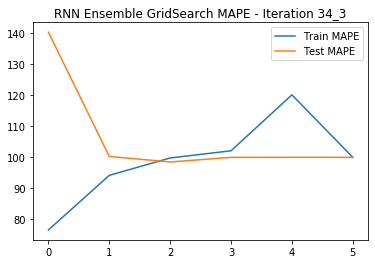

Epoch 1/40
69/69 [==============================] - 9s 133ms/step - loss: 11514864640.0000 - mean_absolute_percentage_error: 105.2250 - val_loss: 7051069952.0000 - val_mean_absolute_percentage_error: 91.1222
Epoch 2/40
69/69 [==============================] - 9s 128ms/step - loss: 8610522112.0000 - mean_absolute_percentage_error: 98.9759 - val_loss: 8324224000.0000 - val_mean_absolute_percentage_error: 99.8916
Epoch 3/40
69/69 [==============================] - 9s 128ms/step - loss: 79346376704.0000 - mean_absolute_percentage_error: 147.5130 - val_loss: 10728668160.0000 - val_mean_absolute_percentage_error: 113.7208
Epoch 4/40
69/69 [==============================] - 9s 127ms/step - loss: 8212368384.0000 - mean_absolute_percentage_error: 97.2007 - val_loss: 4828919808.0000 - val_mean_absolute_percentage_error: 74.2769
Epoch 5/40
69/69 [==============================] - 9s 127ms/step - loss: 5117922304.0000 - mean_absolute_percentage_error: 69.8498 - val_loss: 1503740288.0000 - val_mean

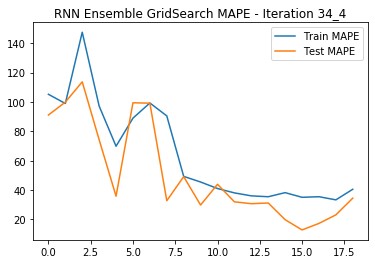

seq_length              24.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.20
stop_patience            3.00
learning_rate            0.01
epochs                  80.00
Name: 35, dtype: float64
Epoch 1/80
69/69 [==============================] - 10s 139ms/step - loss: 162355838976.0000 - mean_absolute_percentage_error: 133.5262 - val_loss: 8250429952.0000 - val_mean_absolute_percentage_error: 99.4165
Epoch 2/80
69/69 [==============================] - 9s 134ms/step - loss: 7152850944.0000 - mean_absolute_percentage_error: 88.3357 - val_loss: 7677484544.0000 - val_mean_absolute_percentage_error: 95.5029
Epoch 3/80
69/69 [==============================] - 9s 133ms/step - loss: 9483283456.0000 - mean_absolute_percentage_error: 80.1640 - val_loss: 8340644864.0000 - val_mean_absolute_percentage_error: 99.9959
Epoch 4/80
69/69 [==============================] - 9

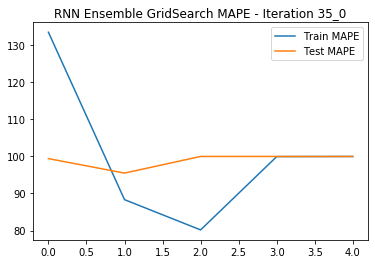

Epoch 1/80
69/69 [==============================] - 10s 141ms/step - loss: 11182183424.0000 - mean_absolute_percentage_error: 96.4544 - val_loss: 2303255552.0000 - val_mean_absolute_percentage_error: 45.0511
Epoch 2/80
69/69 [==============================] - 9s 135ms/step - loss: 5103987712.0000 - mean_absolute_percentage_error: 65.3799 - val_loss: 1143200256.0000 - val_mean_absolute_percentage_error: 32.2639
Epoch 3/80
69/69 [==============================] - 9s 136ms/step - loss: 966168384.0000 - mean_absolute_percentage_error: 27.0760 - val_loss: 215915456.0000 - val_mean_absolute_percentage_error: 11.0298
Epoch 4/80
69/69 [==============================] - 9s 135ms/step - loss: 810350080.0000 - mean_absolute_percentage_error: 25.2704 - val_loss: 232860720.0000 - val_mean_absolute_percentage_error: 12.0519
Epoch 5/80
69/69 [==============================] - 9s 135ms/step - loss: 754628160.0000 - mean_absolute_percentage_error: 24.4534 - val_loss: 446521600.0000 - val_mean_absolute_

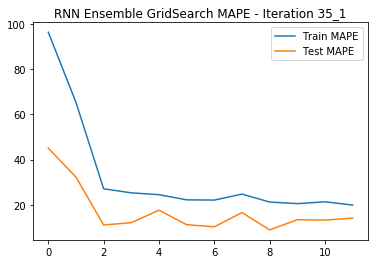

Epoch 1/80
69/69 [==============================] - 10s 149ms/step - loss: 12883889152.0000 - mean_absolute_percentage_error: 98.4957 - val_loss: 8339636224.0000 - val_mean_absolute_percentage_error: 99.9894
Epoch 2/80
69/69 [==============================] - 10s 143ms/step - loss: 8004453888.0000 - mean_absolute_percentage_error: 95.2607 - val_loss: 6943376896.0000 - val_mean_absolute_percentage_error: 90.5438
Epoch 3/80
69/69 [==============================] - 10s 143ms/step - loss: 7479233536.0000 - mean_absolute_percentage_error: 90.9827 - val_loss: 8309544960.0000 - val_mean_absolute_percentage_error: 99.7990
Epoch 4/80
69/69 [==============================] - 10s 143ms/step - loss: 8106740224.0000 - mean_absolute_percentage_error: 96.7758 - val_loss: 8312386560.0000 - val_mean_absolute_percentage_error: 99.8147
Epoch 5/80
69/69 [==============================] - 10s 143ms/step - loss: 8461957632.0000 - mean_absolute_percentage_error: 98.8931 - val_loss: 8337884672.0000 - val_mean

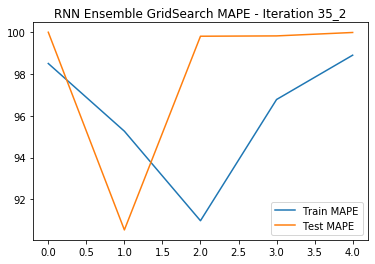

Epoch 1/80
69/69 [==============================] - 10s 145ms/step - loss: 5612046336.0000 - mean_absolute_percentage_error: 76.5658 - val_loss: 22899630080.0000 - val_mean_absolute_percentage_error: 140.3599
Epoch 2/80
69/69 [==============================] - 10s 140ms/step - loss: 7744439808.0000 - mean_absolute_percentage_error: 94.1818 - val_loss: 14988051456.0000 - val_mean_absolute_percentage_error: 100.2865
Epoch 3/80
69/69 [==============================] - 10s 140ms/step - loss: 8925059072.0000 - mean_absolute_percentage_error: 99.7836 - val_loss: 8090571776.0000 - val_mean_absolute_percentage_error: 98.4905
Epoch 4/80
69/69 [==============================] - 10s 140ms/step - loss: 13517171712.0000 - mean_absolute_percentage_error: 102.1008 - val_loss: 8339156480.0000 - val_mean_absolute_percentage_error: 99.9861
Epoch 5/80
69/69 [==============================] - 10s 139ms/step - loss: 121780428800.0000 - mean_absolute_percentage_error: 120.1546 - val_loss: 8340838400.0000 - 

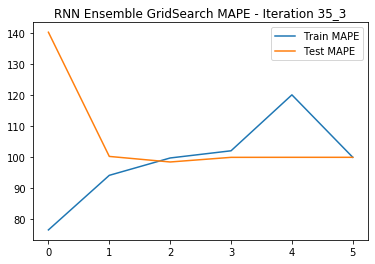

Epoch 1/80
69/69 [==============================] - 10s 142ms/step - loss: 11514864640.0000 - mean_absolute_percentage_error: 105.2250 - val_loss: 7051069952.0000 - val_mean_absolute_percentage_error: 91.1222
Epoch 2/80
69/69 [==============================] - 9s 137ms/step - loss: 8610522112.0000 - mean_absolute_percentage_error: 98.9759 - val_loss: 8324224000.0000 - val_mean_absolute_percentage_error: 99.8916
Epoch 3/80
69/69 [==============================] - 9s 137ms/step - loss: 79346376704.0000 - mean_absolute_percentage_error: 147.5130 - val_loss: 10728668160.0000 - val_mean_absolute_percentage_error: 113.7208
Epoch 4/80
69/69 [==============================] - 9s 137ms/step - loss: 8212368384.0000 - mean_absolute_percentage_error: 97.2007 - val_loss: 4828919808.0000 - val_mean_absolute_percentage_error: 74.2769
Epoch 5/80
69/69 [==============================] - 10s 138ms/step - loss: 5117922304.0000 - mean_absolute_percentage_error: 69.8498 - val_loss: 1503740288.0000 - val_me

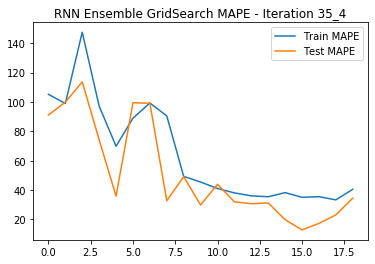

seq_length              24.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            4.000
learning_rate            0.001
epochs                  40.000
Name: 36, dtype: float64
Epoch 1/40
69/69 [==============================] - 10s 146ms/step - loss: 4507397120.0000 - mean_absolute_percentage_error: 64.3816 - val_loss: 641572608.0000 - val_mean_absolute_percentage_error: 23.3835
Epoch 2/40
69/69 [==============================] - 10s 141ms/step - loss: 1420638720.0000 - mean_absolute_percentage_error: 34.0625 - val_loss: 888078848.0000 - val_mean_absolute_percentage_error: 29.1858
Epoch 3/40
69/69 [==============================] - 10s 141ms/step - loss: 1260448384.0000 - mean_absolute_percentage_error: 31.6797 - val_loss: 1115357696.0000 - val_mean_absolute_percentage_error: 33.8490
Epoch 4/40
69/69 [============================

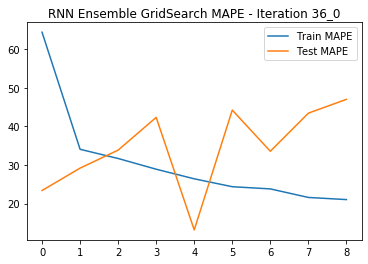

Epoch 1/40
69/69 [==============================] - 10s 144ms/step - loss: 6646948352.0000 - mean_absolute_percentage_error: 84.5764 - val_loss: 1215550336.0000 - val_mean_absolute_percentage_error: 31.0359
Epoch 2/40
69/69 [==============================] - 9s 138ms/step - loss: 1472268032.0000 - mean_absolute_percentage_error: 34.1826 - val_loss: 743719488.0000 - val_mean_absolute_percentage_error: 25.5676
Epoch 3/40
69/69 [==============================] - 9s 138ms/step - loss: 1234190464.0000 - mean_absolute_percentage_error: 31.4264 - val_loss: 211670992.0000 - val_mean_absolute_percentage_error: 12.2676
Epoch 4/40
69/69 [==============================] - 10s 138ms/step - loss: 949049472.0000 - mean_absolute_percentage_error: 27.4731 - val_loss: 775272768.0000 - val_mean_absolute_percentage_error: 25.3375
Epoch 5/40
69/69 [==============================] - 10s 138ms/step - loss: 902323200.0000 - mean_absolute_percentage_error: 26.5388 - val_loss: 140392016.0000 - val_mean_absolute

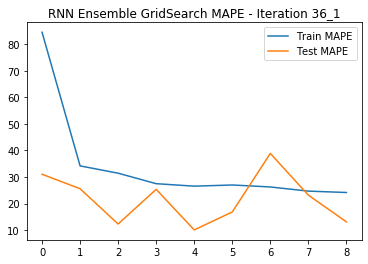

Epoch 1/40
69/69 [==============================] - 10s 140ms/step - loss: 5215432704.0000 - mean_absolute_percentage_error: 70.8476 - val_loss: 739817664.0000 - val_mean_absolute_percentage_error: 24.4728
Epoch 2/40
69/69 [==============================] - 9s 135ms/step - loss: 1549720960.0000 - mean_absolute_percentage_error: 35.4842 - val_loss: 1584615680.0000 - val_mean_absolute_percentage_error: 41.7815
Epoch 3/40
69/69 [==============================] - 9s 135ms/step - loss: 1667160832.0000 - mean_absolute_percentage_error: 37.6086 - val_loss: 538343552.0000 - val_mean_absolute_percentage_error: 21.4949
Epoch 4/40
69/69 [==============================] - 9s 135ms/step - loss: 1000618816.0000 - mean_absolute_percentage_error: 28.0120 - val_loss: 614032960.0000 - val_mean_absolute_percentage_error: 24.3155
Epoch 5/40
69/69 [==============================] - 9s 135ms/step - loss: 738020992.0000 - mean_absolute_percentage_error: 24.0286 - val_loss: 317093952.0000 - val_mean_absolute_

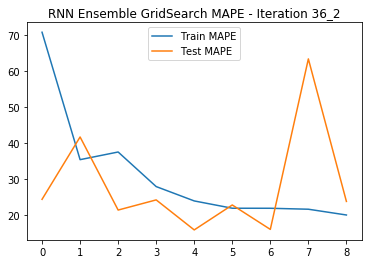

Epoch 1/40
69/69 [==============================] - 11s 160ms/step - loss: 5861015040.0000 - mean_absolute_percentage_error: 76.2944 - val_loss: 2536474112.0000 - val_mean_absolute_percentage_error: 49.2452
Epoch 2/40
69/69 [==============================] - 10s 148ms/step - loss: 1920809344.0000 - mean_absolute_percentage_error: 38.7252 - val_loss: 1207600000.0000 - val_mean_absolute_percentage_error: 35.0609
Epoch 3/40
69/69 [==============================] - 10s 148ms/step - loss: 1367725824.0000 - mean_absolute_percentage_error: 32.7843 - val_loss: 1420818432.0000 - val_mean_absolute_percentage_error: 39.2691
Epoch 4/40
69/69 [==============================] - 10s 148ms/step - loss: 1196977408.0000 - mean_absolute_percentage_error: 30.6727 - val_loss: 655965632.0000 - val_mean_absolute_percentage_error: 24.6427
Epoch 5/40
69/69 [==============================] - 10s 148ms/step - loss: 1101032832.0000 - mean_absolute_percentage_error: 29.6360 - val_loss: 440607680.0000 - val_mean_ab

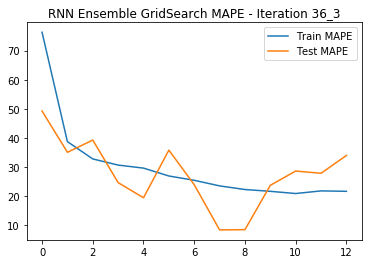

Epoch 1/40
69/69 [==============================] - 10s 151ms/step - loss: 4724728832.0000 - mean_absolute_percentage_error: 65.7267 - val_loss: 601419392.0000 - val_mean_absolute_percentage_error: 21.8251
Epoch 2/40
69/69 [==============================] - 10s 146ms/step - loss: 1171931136.0000 - mean_absolute_percentage_error: 30.6330 - val_loss: 143419696.0000 - val_mean_absolute_percentage_error: 10.3932
Epoch 3/40
69/69 [==============================] - 10s 146ms/step - loss: 946730880.0000 - mean_absolute_percentage_error: 27.2877 - val_loss: 309666048.0000 - val_mean_absolute_percentage_error: 15.6754
Epoch 4/40
69/69 [==============================] - 10s 146ms/step - loss: 901029184.0000 - mean_absolute_percentage_error: 26.6174 - val_loss: 435168320.0000 - val_mean_absolute_percentage_error: 19.3516
Epoch 5/40
69/69 [==============================] - 10s 145ms/step - loss: 835601216.0000 - mean_absolute_percentage_error: 25.7531 - val_loss: 656665984.0000 - val_mean_absolute

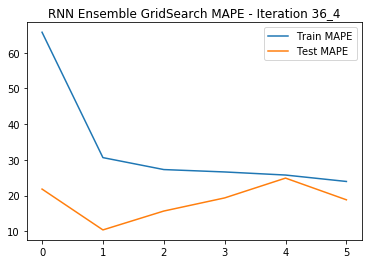

seq_length              24.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            4.000
learning_rate            0.001
epochs                  80.000
Name: 37, dtype: float64
Epoch 1/80
69/69 [==============================] - 11s 153ms/step - loss: 4507397120.0000 - mean_absolute_percentage_error: 64.3816 - val_loss: 641572608.0000 - val_mean_absolute_percentage_error: 23.3835
Epoch 2/80
69/69 [==============================] - 10s 147ms/step - loss: 1420638720.0000 - mean_absolute_percentage_error: 34.0625 - val_loss: 888078848.0000 - val_mean_absolute_percentage_error: 29.1858
Epoch 3/80
69/69 [==============================] - 10s 147ms/step - loss: 1260448384.0000 - mean_absolute_percentage_error: 31.6797 - val_loss: 1115357696.0000 - val_mean_absolute_percentage_error: 33.8490
Epoch 4/80
69/69 [============================

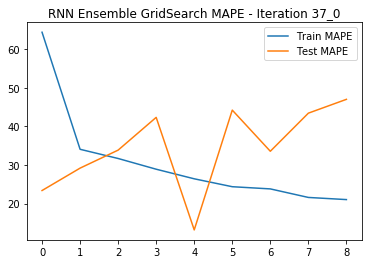

Epoch 1/80
69/69 [==============================] - 10s 150ms/step - loss: 6646948352.0000 - mean_absolute_percentage_error: 84.5764 - val_loss: 1215550336.0000 - val_mean_absolute_percentage_error: 31.0359
Epoch 2/80
69/69 [==============================] - 10s 144ms/step - loss: 1472268032.0000 - mean_absolute_percentage_error: 34.1826 - val_loss: 743719488.0000 - val_mean_absolute_percentage_error: 25.5676
Epoch 3/80
69/69 [==============================] - 10s 144ms/step - loss: 1234190464.0000 - mean_absolute_percentage_error: 31.4264 - val_loss: 211670992.0000 - val_mean_absolute_percentage_error: 12.2676
Epoch 4/80
69/69 [==============================] - 10s 144ms/step - loss: 949049472.0000 - mean_absolute_percentage_error: 27.4731 - val_loss: 775272768.0000 - val_mean_absolute_percentage_error: 25.3375
Epoch 5/80
69/69 [==============================] - 10s 144ms/step - loss: 902323200.0000 - mean_absolute_percentage_error: 26.5388 - val_loss: 140392016.0000 - val_mean_absolu

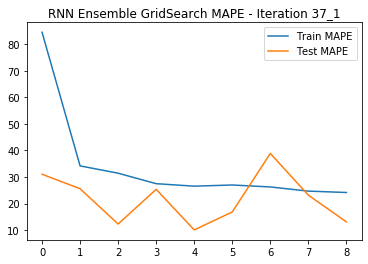

Epoch 1/80
69/69 [==============================] - 10s 146ms/step - loss: 5215432704.0000 - mean_absolute_percentage_error: 70.8476 - val_loss: 739817664.0000 - val_mean_absolute_percentage_error: 24.4728
Epoch 2/80
69/69 [==============================] - 10s 141ms/step - loss: 1549720960.0000 - mean_absolute_percentage_error: 35.4842 - val_loss: 1584615680.0000 - val_mean_absolute_percentage_error: 41.7815
Epoch 3/80
69/69 [==============================] - 10s 141ms/step - loss: 1667160832.0000 - mean_absolute_percentage_error: 37.6086 - val_loss: 538343552.0000 - val_mean_absolute_percentage_error: 21.4949
Epoch 4/80
69/69 [==============================] - 10s 142ms/step - loss: 1000618816.0000 - mean_absolute_percentage_error: 28.0120 - val_loss: 614032960.0000 - val_mean_absolute_percentage_error: 24.3155
Epoch 5/80
69/69 [==============================] - 10s 142ms/step - loss: 738020992.0000 - mean_absolute_percentage_error: 24.0286 - val_loss: 317093952.0000 - val_mean_absol

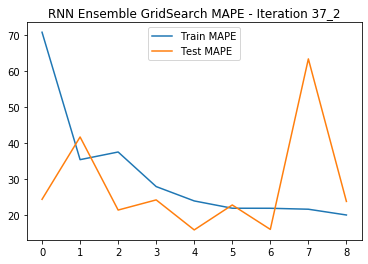

Epoch 1/80
69/69 [==============================] - 10s 144ms/step - loss: 5861015040.0000 - mean_absolute_percentage_error: 76.2944 - val_loss: 2536474112.0000 - val_mean_absolute_percentage_error: 49.2452
Epoch 2/80
69/69 [==============================] - 10s 138ms/step - loss: 1920809344.0000 - mean_absolute_percentage_error: 38.7252 - val_loss: 1207600000.0000 - val_mean_absolute_percentage_error: 35.0609
Epoch 3/80
69/69 [==============================] - 10s 138ms/step - loss: 1367725824.0000 - mean_absolute_percentage_error: 32.7843 - val_loss: 1420818432.0000 - val_mean_absolute_percentage_error: 39.2691
Epoch 4/80
69/69 [==============================] - 10s 138ms/step - loss: 1196977408.0000 - mean_absolute_percentage_error: 30.6727 - val_loss: 655965632.0000 - val_mean_absolute_percentage_error: 24.6427
Epoch 5/80
69/69 [==============================] - 10s 138ms/step - loss: 1101032832.0000 - mean_absolute_percentage_error: 29.6360 - val_loss: 440607680.0000 - val_mean_ab

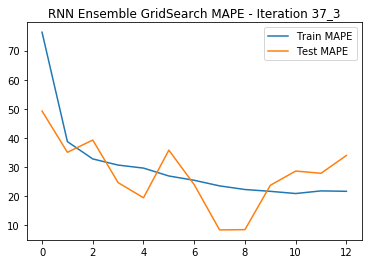

Epoch 1/80
69/69 [==============================] - 10s 148ms/step - loss: 4724728832.0000 - mean_absolute_percentage_error: 65.7267 - val_loss: 601419392.0000 - val_mean_absolute_percentage_error: 21.8251
Epoch 2/80
69/69 [==============================] - 10s 143ms/step - loss: 1171931136.0000 - mean_absolute_percentage_error: 30.6330 - val_loss: 143419696.0000 - val_mean_absolute_percentage_error: 10.3932
Epoch 3/80
69/69 [==============================] - 10s 142ms/step - loss: 946730880.0000 - mean_absolute_percentage_error: 27.2877 - val_loss: 309666048.0000 - val_mean_absolute_percentage_error: 15.6754
Epoch 4/80
69/69 [==============================] - 10s 142ms/step - loss: 901029184.0000 - mean_absolute_percentage_error: 26.6174 - val_loss: 435168320.0000 - val_mean_absolute_percentage_error: 19.3516
Epoch 5/80
69/69 [==============================] - 10s 142ms/step - loss: 835601216.0000 - mean_absolute_percentage_error: 25.7531 - val_loss: 656665984.0000 - val_mean_absolute

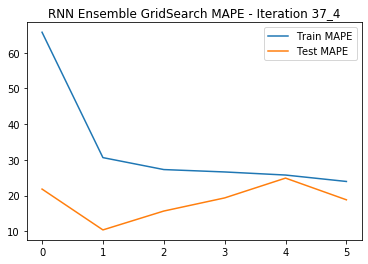

seq_length              24.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.20
stop_patience            4.00
learning_rate            0.01
epochs                  40.00
Name: 38, dtype: float64
Epoch 1/40
69/69 [==============================] - 10s 148ms/step - loss: 162355838976.0000 - mean_absolute_percentage_error: 133.5262 - val_loss: 8250429952.0000 - val_mean_absolute_percentage_error: 99.4165
Epoch 2/40
69/69 [==============================] - 10s 142ms/step - loss: 7152850944.0000 - mean_absolute_percentage_error: 88.3357 - val_loss: 7677484544.0000 - val_mean_absolute_percentage_error: 95.5029
Epoch 3/40
69/69 [==============================] - 10s 142ms/step - loss: 9483283456.0000 - mean_absolute_percentage_error: 80.1640 - val_loss: 8340644864.0000 - val_mean_absolute_percentage_error: 99.9959
Epoch 4/40
69/69 [==============================] -

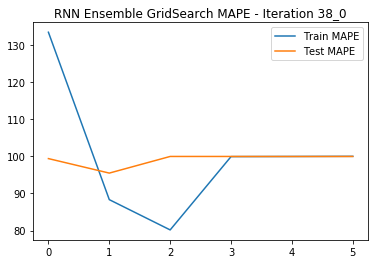

Epoch 1/40
69/69 [==============================] - 11s 156ms/step - loss: 11810778112.0000 - mean_absolute_percentage_error: 102.5833 - val_loss: 8276739584.0000 - val_mean_absolute_percentage_error: 99.5877
Epoch 2/40
69/69 [==============================] - 10s 151ms/step - loss: 8045474816.0000 - mean_absolute_percentage_error: 96.6712 - val_loss: 7515856384.0000 - val_mean_absolute_percentage_error: 94.5961
Epoch 3/40
69/69 [==============================] - 10s 151ms/step - loss: 8939943936.0000 - mean_absolute_percentage_error: 97.5975 - val_loss: 8338557952.0000 - val_mean_absolute_percentage_error: 99.9828
Epoch 4/40
69/69 [==============================] - 10s 151ms/step - loss: 8489116160.0000 - mean_absolute_percentage_error: 96.0576 - val_loss: 8337952768.0000 - val_mean_absolute_percentage_error: 99.9788
Epoch 5/40
69/69 [==============================] - 10s 150ms/step - loss: 8394835968.0000 - mean_absolute_percentage_error: 99.9894 - val_loss: 8339866112.0000 - val_mea

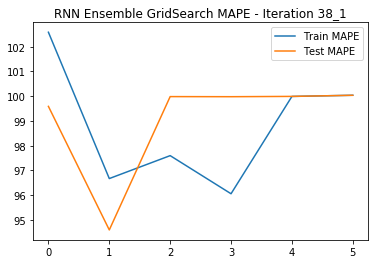

Epoch 1/40
69/69 [==============================] - 11s 153ms/step - loss: 24458082304.0000 - mean_absolute_percentage_error: 105.5925 - val_loss: 8017316352.0000 - val_mean_absolute_percentage_error: 97.9283
Epoch 2/40
69/69 [==============================] - 10s 147ms/step - loss: 30377897984.0000 - mean_absolute_percentage_error: 113.1233 - val_loss: 8340525056.0000 - val_mean_absolute_percentage_error: 99.9952
Epoch 3/40
69/69 [==============================] - 10s 147ms/step - loss: 8127305216.0000 - mean_absolute_percentage_error: 95.4714 - val_loss: 8195173888.0000 - val_mean_absolute_percentage_error: 99.0715
Epoch 4/40
69/69 [==============================] - 10s 147ms/step - loss: 8314067456.0000 - mean_absolute_percentage_error: 99.4787 - val_loss: 8261210112.0000 - val_mean_absolute_percentage_error: 99.4929
Epoch 5/40
69/69 [==============================] - 10s 147ms/step - loss: 8234409472.0000 - mean_absolute_percentage_error: 98.9857 - val_loss: 8064522752.0000 - val_m

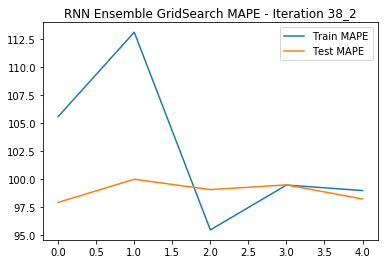

Epoch 1/40
69/69 [==============================] - 10s 151ms/step - loss: 10096178176.0000 - mean_absolute_percentage_error: 101.7842 - val_loss: 8237147648.0000 - val_mean_absolute_percentage_error: 99.3309
Epoch 2/40
69/69 [==============================] - 10s 145ms/step - loss: 9782184960.0000 - mean_absolute_percentage_error: 98.1684 - val_loss: 8316089856.0000 - val_mean_absolute_percentage_error: 99.8397
Epoch 3/40
69/69 [==============================] - 10s 145ms/step - loss: 7459515392.0000 - mean_absolute_percentage_error: 92.1085 - val_loss: 7644857344.0000 - val_mean_absolute_percentage_error: 95.4633
Epoch 4/40
69/69 [==============================] - 10s 145ms/step - loss: 3255242496.0000 - mean_absolute_percentage_error: 52.8577 - val_loss: 350066016.0000 - val_mean_absolute_percentage_error: 14.6706
Epoch 5/40
69/69 [==============================] - 10s 145ms/step - loss: 1076745600.0000 - mean_absolute_percentage_error: 28.9657 - val_loss: 658736640.0000 - val_mean_

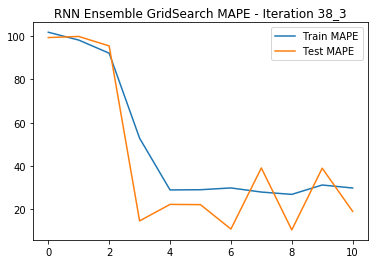

Epoch 1/40
69/69 [==============================] - 10s 146ms/step - loss: 11514864640.0000 - mean_absolute_percentage_error: 105.2250 - val_loss: 7051069952.0000 - val_mean_absolute_percentage_error: 91.1222
Epoch 2/40
69/69 [==============================] - 10s 141ms/step - loss: 8610522112.0000 - mean_absolute_percentage_error: 98.9759 - val_loss: 8324224000.0000 - val_mean_absolute_percentage_error: 99.8916
Epoch 3/40
69/69 [==============================] - 10s 141ms/step - loss: 79346376704.0000 - mean_absolute_percentage_error: 147.5130 - val_loss: 10728668160.0000 - val_mean_absolute_percentage_error: 113.7208
Epoch 4/40
69/69 [==============================] - 10s 141ms/step - loss: 8212368384.0000 - mean_absolute_percentage_error: 97.2007 - val_loss: 4828919808.0000 - val_mean_absolute_percentage_error: 74.2769
Epoch 5/40
69/69 [==============================] - 10s 141ms/step - loss: 5117922304.0000 - mean_absolute_percentage_error: 69.8498 - val_loss: 1503740288.0000 - val

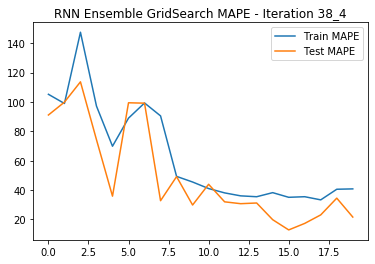

seq_length              24.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.20
stop_patience            4.00
learning_rate            0.01
epochs                  80.00
Name: 39, dtype: float64
Epoch 1/80
69/69 [==============================] - 10s 151ms/step - loss: 162355838976.0000 - mean_absolute_percentage_error: 133.5262 - val_loss: 8250429952.0000 - val_mean_absolute_percentage_error: 99.4165
Epoch 2/80
69/69 [==============================] - 10s 146ms/step - loss: 7152850944.0000 - mean_absolute_percentage_error: 88.3357 - val_loss: 7677484544.0000 - val_mean_absolute_percentage_error: 95.5029
Epoch 3/80
69/69 [==============================] - 10s 145ms/step - loss: 9483283456.0000 - mean_absolute_percentage_error: 80.1640 - val_loss: 8340644864.0000 - val_mean_absolute_percentage_error: 99.9959
Epoch 4/80
69/69 [==============================] -

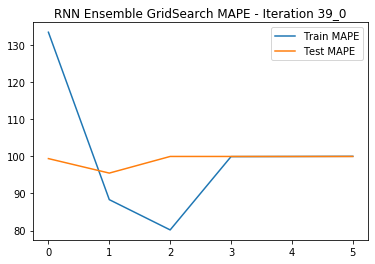

Epoch 1/80
69/69 [==============================] - 10s 149ms/step - loss: 11810778112.0000 - mean_absolute_percentage_error: 102.5833 - val_loss: 8276739584.0000 - val_mean_absolute_percentage_error: 99.5877
Epoch 2/80
69/69 [==============================] - 10s 144ms/step - loss: 8045474816.0000 - mean_absolute_percentage_error: 96.6712 - val_loss: 7515856384.0000 - val_mean_absolute_percentage_error: 94.5961
Epoch 3/80
69/69 [==============================] - 10s 143ms/step - loss: 8939943936.0000 - mean_absolute_percentage_error: 97.5975 - val_loss: 8338557952.0000 - val_mean_absolute_percentage_error: 99.9828
Epoch 4/80
69/69 [==============================] - 10s 143ms/step - loss: 8489116160.0000 - mean_absolute_percentage_error: 96.0576 - val_loss: 8337952768.0000 - val_mean_absolute_percentage_error: 99.9788
Epoch 5/80
69/69 [==============================] - 10s 143ms/step - loss: 8394835968.0000 - mean_absolute_percentage_error: 99.9894 - val_loss: 8339866112.0000 - val_mea

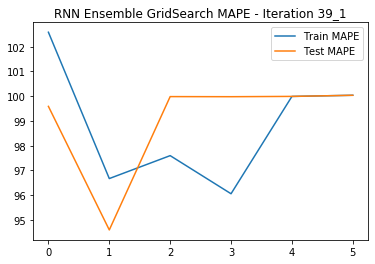

Epoch 1/80
69/69 [==============================] - 10s 147ms/step - loss: 24458082304.0000 - mean_absolute_percentage_error: 105.5925 - val_loss: 8017316352.0000 - val_mean_absolute_percentage_error: 97.9283
Epoch 2/80
69/69 [==============================] - 10s 143ms/step - loss: 30377897984.0000 - mean_absolute_percentage_error: 113.1233 - val_loss: 8340525056.0000 - val_mean_absolute_percentage_error: 99.9952
Epoch 3/80
69/69 [==============================] - 10s 142ms/step - loss: 8127305216.0000 - mean_absolute_percentage_error: 95.4714 - val_loss: 8195173888.0000 - val_mean_absolute_percentage_error: 99.0715
Epoch 4/80
69/69 [==============================] - 10s 141ms/step - loss: 8314067456.0000 - mean_absolute_percentage_error: 99.4787 - val_loss: 8261210112.0000 - val_mean_absolute_percentage_error: 99.4929
Epoch 5/80
69/69 [==============================] - 10s 142ms/step - loss: 8234409472.0000 - mean_absolute_percentage_error: 98.9857 - val_loss: 8064522752.0000 - val_m

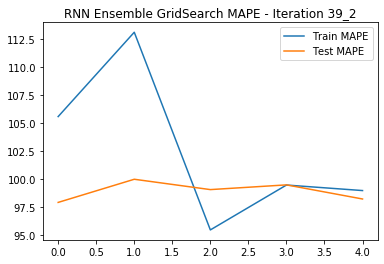

Epoch 1/80
69/69 [==============================] - 11s 159ms/step - loss: 10096178176.0000 - mean_absolute_percentage_error: 101.7842 - val_loss: 8237147648.0000 - val_mean_absolute_percentage_error: 99.3309
Epoch 2/80
69/69 [==============================] - 11s 154ms/step - loss: 9782184960.0000 - mean_absolute_percentage_error: 98.1684 - val_loss: 8316089856.0000 - val_mean_absolute_percentage_error: 99.8397
Epoch 3/80
69/69 [==============================] - 11s 154ms/step - loss: 7459515392.0000 - mean_absolute_percentage_error: 92.1085 - val_loss: 7644857344.0000 - val_mean_absolute_percentage_error: 95.4633
Epoch 4/80
69/69 [==============================] - 11s 154ms/step - loss: 3255242496.0000 - mean_absolute_percentage_error: 52.8577 - val_loss: 350066016.0000 - val_mean_absolute_percentage_error: 14.6706
Epoch 5/80
69/69 [==============================] - 11s 154ms/step - loss: 1076745600.0000 - mean_absolute_percentage_error: 28.9657 - val_loss: 658736640.0000 - val_mean_

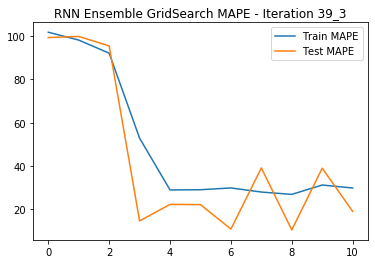

Epoch 1/80
69/69 [==============================] - 11s 155ms/step - loss: 11514864640.0000 - mean_absolute_percentage_error: 105.2250 - val_loss: 7051069952.0000 - val_mean_absolute_percentage_error: 91.1222
Epoch 2/80
69/69 [==============================] - 10s 150ms/step - loss: 8610522112.0000 - mean_absolute_percentage_error: 98.9759 - val_loss: 8324224000.0000 - val_mean_absolute_percentage_error: 99.8916
Epoch 3/80
69/69 [==============================] - 10s 150ms/step - loss: 79346376704.0000 - mean_absolute_percentage_error: 147.5130 - val_loss: 10728668160.0000 - val_mean_absolute_percentage_error: 113.7208
Epoch 4/80
69/69 [==============================] - 10s 149ms/step - loss: 8212368384.0000 - mean_absolute_percentage_error: 97.2007 - val_loss: 4828919808.0000 - val_mean_absolute_percentage_error: 74.2769
Epoch 5/80
69/69 [==============================] - 10s 149ms/step - loss: 5117922304.0000 - mean_absolute_percentage_error: 69.8498 - val_loss: 1503740288.0000 - val

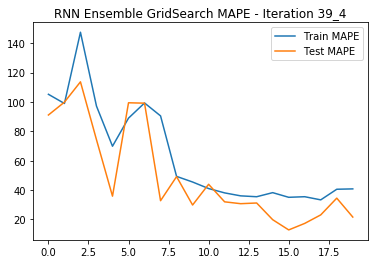

seq_length              24.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.400
stop_patience            3.000
learning_rate            0.001
epochs                  40.000
Name: 40, dtype: float64
Epoch 1/40
69/69 [==============================] - 11s 156ms/step - loss: 5348843008.0000 - mean_absolute_percentage_error: 73.1921 - val_loss: 3730720000.0000 - val_mean_absolute_percentage_error: 62.1287
Epoch 2/40
69/69 [==============================] - 10s 151ms/step - loss: 2532306176.0000 - mean_absolute_percentage_error: 46.6113 - val_loss: 929869952.0000 - val_mean_absolute_percentage_error: 29.9614
Epoch 3/40
69/69 [==============================] - 10s 151ms/step - loss: 1927502080.0000 - mean_absolute_percentage_error: 39.7439 - val_loss: 1188533504.0000 - val_mean_absolute_percentage_error: 35.4286
Epoch 4/40
69/69 [===========================

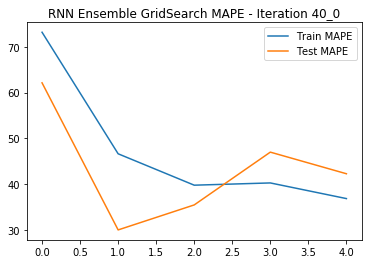

Epoch 1/40
69/69 [==============================] - 11s 153ms/step - loss: 5973566976.0000 - mean_absolute_percentage_error: 78.5361 - val_loss: 4275605760.0000 - val_mean_absolute_percentage_error: 70.0804
Epoch 2/40
69/69 [==============================] - 10s 148ms/step - loss: 3145016320.0000 - mean_absolute_percentage_error: 51.1123 - val_loss: 5279694848.0000 - val_mean_absolute_percentage_error: 78.4327
Epoch 3/40
69/69 [==============================] - 10s 148ms/step - loss: 2356820224.0000 - mean_absolute_percentage_error: 44.5688 - val_loss: 2975960832.0000 - val_mean_absolute_percentage_error: 57.6827
Epoch 4/40
69/69 [==============================] - 10s 147ms/step - loss: 1983526528.0000 - mean_absolute_percentage_error: 40.5308 - val_loss: 3520958464.0000 - val_mean_absolute_percentage_error: 63.6486
Epoch 5/40
69/69 [==============================] - 10s 147ms/step - loss: 1635567104.0000 - mean_absolute_percentage_error: 36.3118 - val_loss: 933116096.0000 - val_mean_a

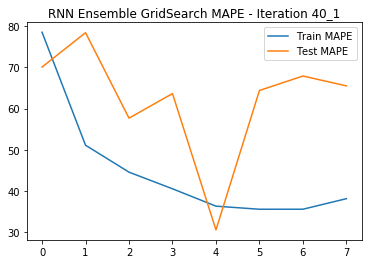

Epoch 1/40
69/69 [==============================] - 10s 150ms/step - loss: 6687560192.0000 - mean_absolute_percentage_error: 85.2708 - val_loss: 3966572032.0000 - val_mean_absolute_percentage_error: 67.1301
Epoch 2/40
69/69 [==============================] - 10s 146ms/step - loss: 2977507072.0000 - mean_absolute_percentage_error: 50.9353 - val_loss: 3972430336.0000 - val_mean_absolute_percentage_error: 67.9348
Epoch 3/40
69/69 [==============================] - 10s 146ms/step - loss: 2200403712.0000 - mean_absolute_percentage_error: 42.7995 - val_loss: 1281994240.0000 - val_mean_absolute_percentage_error: 36.5033
Epoch 4/40
69/69 [==============================] - 10s 145ms/step - loss: 1940077312.0000 - mean_absolute_percentage_error: 39.9981 - val_loss: 2928335616.0000 - val_mean_absolute_percentage_error: 57.6165
Epoch 5/40
69/69 [==============================] - 10s 145ms/step - loss: 1865733248.0000 - mean_absolute_percentage_error: 39.4667 - val_loss: 1959497728.0000 - val_mean_

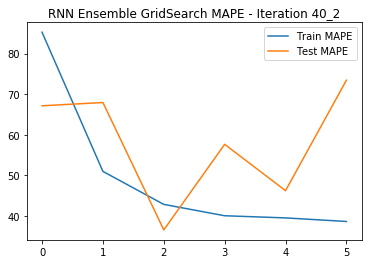

Epoch 1/40
69/69 [==============================] - 10s 148ms/step - loss: 6074170368.0000 - mean_absolute_percentage_error: 79.9651 - val_loss: 5585864192.0000 - val_mean_absolute_percentage_error: 81.1112
Epoch 2/40
69/69 [==============================] - 10s 143ms/step - loss: 2626081280.0000 - mean_absolute_percentage_error: 47.3199 - val_loss: 4398896640.0000 - val_mean_absolute_percentage_error: 71.8870
Epoch 3/40
69/69 [==============================] - 10s 143ms/step - loss: 2493097984.0000 - mean_absolute_percentage_error: 46.1648 - val_loss: 5597499904.0000 - val_mean_absolute_percentage_error: 81.2549
Epoch 4/40
69/69 [==============================] - 10s 142ms/step - loss: 2152468224.0000 - mean_absolute_percentage_error: 42.5949 - val_loss: 2579304192.0000 - val_mean_absolute_percentage_error: 53.4732
Epoch 5/40
69/69 [==============================] - 10s 142ms/step - loss: 3950663424.0000 - mean_absolute_percentage_error: 52.9672 - val_loss: 8274977280.0000 - val_mean_

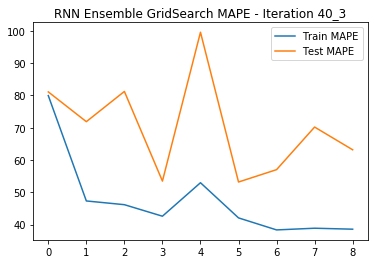

Epoch 1/40
69/69 [==============================] - 10s 151ms/step - loss: 5496076288.0000 - mean_absolute_percentage_error: 73.3410 - val_loss: 1849145856.0000 - val_mean_absolute_percentage_error: 44.3283
Epoch 2/40
69/69 [==============================] - 10s 146ms/step - loss: 2173153024.0000 - mean_absolute_percentage_error: 42.5927 - val_loss: 1585893504.0000 - val_mean_absolute_percentage_error: 41.7388
Epoch 3/40
69/69 [==============================] - 10s 146ms/step - loss: 1846439808.0000 - mean_absolute_percentage_error: 38.9856 - val_loss: 3715983104.0000 - val_mean_absolute_percentage_error: 65.6208
Epoch 4/40
69/69 [==============================] - 10s 146ms/step - loss: 1686132736.0000 - mean_absolute_percentage_error: 37.1864 - val_loss: 1460674304.0000 - val_mean_absolute_percentage_error: 40.1708
Epoch 5/40
69/69 [==============================] - 10s 146ms/step - loss: 1486094592.0000 - mean_absolute_percentage_error: 34.5510 - val_loss: 2268169728.0000 - val_mean_

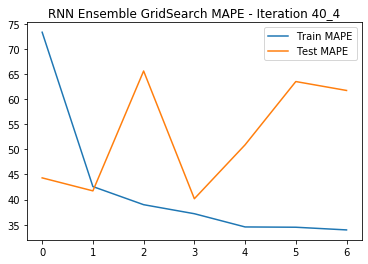

seq_length              24.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.400
stop_patience            3.000
learning_rate            0.001
epochs                  80.000
Name: 41, dtype: float64
Epoch 1/80
69/69 [==============================] - 12s 167ms/step - loss: 5348843008.0000 - mean_absolute_percentage_error: 73.1921 - val_loss: 3730720000.0000 - val_mean_absolute_percentage_error: 62.1287
Epoch 2/80
69/69 [==============================] - 11s 162ms/step - loss: 2532306176.0000 - mean_absolute_percentage_error: 46.6113 - val_loss: 929869952.0000 - val_mean_absolute_percentage_error: 29.9614
Epoch 3/80
69/69 [==============================] - 11s 161ms/step - loss: 1927502080.0000 - mean_absolute_percentage_error: 39.7439 - val_loss: 1188533504.0000 - val_mean_absolute_percentage_error: 35.4286
Epoch 4/80
69/69 [===========================

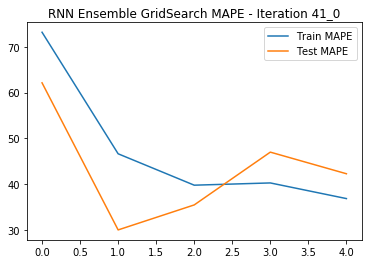

Epoch 1/80
69/69 [==============================] - 11s 163ms/step - loss: 5973566976.0000 - mean_absolute_percentage_error: 78.5361 - val_loss: 4275605760.0000 - val_mean_absolute_percentage_error: 70.0804
Epoch 2/80
69/69 [==============================] - 11s 158ms/step - loss: 3145016320.0000 - mean_absolute_percentage_error: 51.1123 - val_loss: 5279694848.0000 - val_mean_absolute_percentage_error: 78.4327
Epoch 3/80
69/69 [==============================] - 11s 159ms/step - loss: 2356820224.0000 - mean_absolute_percentage_error: 44.5688 - val_loss: 2975960832.0000 - val_mean_absolute_percentage_error: 57.6827
Epoch 4/80
69/69 [==============================] - 11s 157ms/step - loss: 1983526528.0000 - mean_absolute_percentage_error: 40.5308 - val_loss: 3520958464.0000 - val_mean_absolute_percentage_error: 63.6486
Epoch 5/80
69/69 [==============================] - 11s 157ms/step - loss: 1635567104.0000 - mean_absolute_percentage_error: 36.3118 - val_loss: 933116096.0000 - val_mean_a

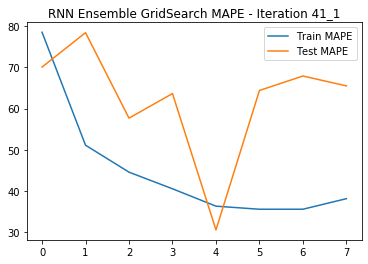

Epoch 1/80
69/69 [==============================] - 11s 159ms/step - loss: 6687560192.0000 - mean_absolute_percentage_error: 85.2708 - val_loss: 3966572032.0000 - val_mean_absolute_percentage_error: 67.1301
Epoch 2/80
69/69 [==============================] - 11s 155ms/step - loss: 2977507072.0000 - mean_absolute_percentage_error: 50.9353 - val_loss: 3972430336.0000 - val_mean_absolute_percentage_error: 67.9348
Epoch 3/80
69/69 [==============================] - 11s 154ms/step - loss: 2200403712.0000 - mean_absolute_percentage_error: 42.7995 - val_loss: 1281994240.0000 - val_mean_absolute_percentage_error: 36.5033
Epoch 4/80
69/69 [==============================] - 11s 154ms/step - loss: 1940077312.0000 - mean_absolute_percentage_error: 39.9981 - val_loss: 2928335616.0000 - val_mean_absolute_percentage_error: 57.6165
Epoch 5/80
69/69 [==============================] - 11s 154ms/step - loss: 1865733248.0000 - mean_absolute_percentage_error: 39.4667 - val_loss: 1959497728.0000 - val_mean_

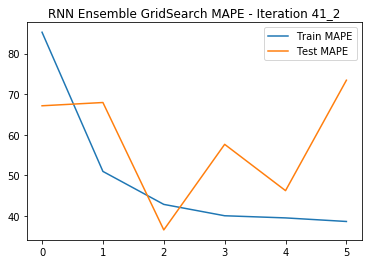

Epoch 1/80
69/69 [==============================] - 11s 157ms/step - loss: 6074170368.0000 - mean_absolute_percentage_error: 79.9651 - val_loss: 5585864192.0000 - val_mean_absolute_percentage_error: 81.1112
Epoch 2/80
69/69 [==============================] - 10s 152ms/step - loss: 2626081280.0000 - mean_absolute_percentage_error: 47.3199 - val_loss: 4398896640.0000 - val_mean_absolute_percentage_error: 71.8870
Epoch 3/80
69/69 [==============================] - 10s 152ms/step - loss: 2493097984.0000 - mean_absolute_percentage_error: 46.1648 - val_loss: 5597499904.0000 - val_mean_absolute_percentage_error: 81.2549
Epoch 4/80
69/69 [==============================] - 10s 152ms/step - loss: 2152468224.0000 - mean_absolute_percentage_error: 42.5949 - val_loss: 2579304192.0000 - val_mean_absolute_percentage_error: 53.4732
Epoch 5/80
69/69 [==============================] - 10s 152ms/step - loss: 3950663424.0000 - mean_absolute_percentage_error: 52.9672 - val_loss: 8274977280.0000 - val_mean_

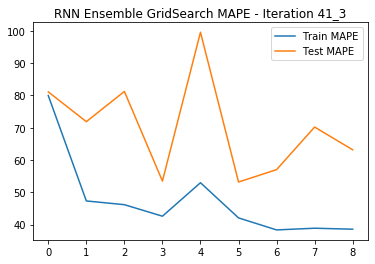

Epoch 1/80
69/69 [==============================] - 11s 155ms/step - loss: 5496076288.0000 - mean_absolute_percentage_error: 73.3410 - val_loss: 1849145856.0000 - val_mean_absolute_percentage_error: 44.3283
Epoch 2/80
69/69 [==============================] - 10s 149ms/step - loss: 2173153024.0000 - mean_absolute_percentage_error: 42.5927 - val_loss: 1585893504.0000 - val_mean_absolute_percentage_error: 41.7388
Epoch 3/80
69/69 [==============================] - 10s 149ms/step - loss: 1846439808.0000 - mean_absolute_percentage_error: 38.9856 - val_loss: 3715983104.0000 - val_mean_absolute_percentage_error: 65.6208
Epoch 4/80
69/69 [==============================] - 10s 150ms/step - loss: 1686132736.0000 - mean_absolute_percentage_error: 37.1864 - val_loss: 1460674304.0000 - val_mean_absolute_percentage_error: 40.1708
Epoch 5/80
69/69 [==============================] - 10s 149ms/step - loss: 1486094592.0000 - mean_absolute_percentage_error: 34.5510 - val_loss: 2268169728.0000 - val_mean_

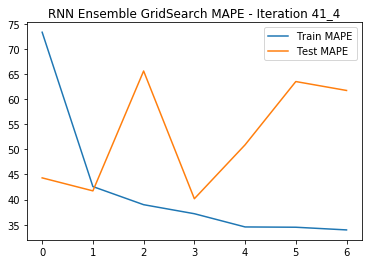

seq_length              24.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.40
stop_patience            3.00
learning_rate            0.01
epochs                  40.00
Name: 42, dtype: float64
Epoch 1/40
69/69 [==============================] - 11s 161ms/step - loss: 9167394816.0000 - mean_absolute_percentage_error: 95.1871 - val_loss: 8009808896.0000 - val_mean_absolute_percentage_error: 97.8629
Epoch 2/40
69/69 [==============================] - 11s 155ms/step - loss: 4400830464.0000 - mean_absolute_percentage_error: 63.5117 - val_loss: 4026019840.0000 - val_mean_absolute_percentage_error: 68.3485
Epoch 3/40
69/69 [==============================] - 11s 155ms/step - loss: 2834669568.0000 - mean_absolute_percentage_error: 48.9605 - val_loss: 2293890560.0000 - val_mean_absolute_percentage_error: 50.5063
Epoch 4/40
69/69 [==============================] - 11

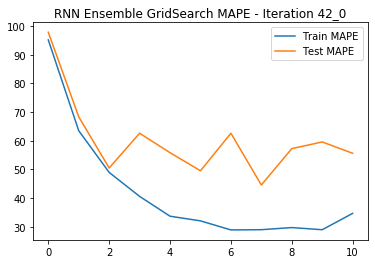

Epoch 1/40
69/69 [==============================] - 11s 156ms/step - loss: 8997607424.0000 - mean_absolute_percentage_error: 97.5483 - val_loss: 1928443136.0000 - val_mean_absolute_percentage_error: 39.8940
Epoch 2/40
69/69 [==============================] - 10s 150ms/step - loss: 3165018880.0000 - mean_absolute_percentage_error: 52.5377 - val_loss: 2998605312.0000 - val_mean_absolute_percentage_error: 57.7425
Epoch 3/40
69/69 [==============================] - 10s 150ms/step - loss: 1596929664.0000 - mean_absolute_percentage_error: 35.9813 - val_loss: 1099603840.0000 - val_mean_absolute_percentage_error: 32.9492
Epoch 4/40
69/69 [==============================] - 10s 150ms/step - loss: 1124816896.0000 - mean_absolute_percentage_error: 29.6503 - val_loss: 126344912.0000 - val_mean_absolute_percentage_error: 9.3818
Epoch 5/40
69/69 [==============================] - 10s 150ms/step - loss: 1083272064.0000 - mean_absolute_percentage_error: 29.0733 - val_loss: 1923716864.0000 - val_mean_ab

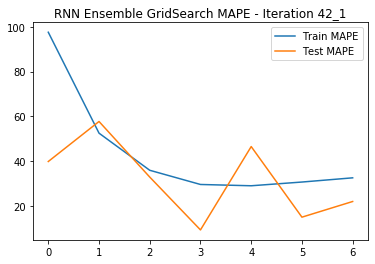

Epoch 1/40
69/69 [==============================] - 11s 157ms/step - loss: 8727592960.0000 - mean_absolute_percentage_error: 97.7520 - val_loss: 8176857600.0000 - val_mean_absolute_percentage_error: 98.9690
Epoch 2/40
69/69 [==============================] - 10s 151ms/step - loss: 7352282624.0000 - mean_absolute_percentage_error: 90.7019 - val_loss: 8110709248.0000 - val_mean_absolute_percentage_error: 98.5253
Epoch 3/40
69/69 [==============================] - 10s 150ms/step - loss: 3951264512.0000 - mean_absolute_percentage_error: 58.8833 - val_loss: 777658432.0000 - val_mean_absolute_percentage_error: 25.1098
Epoch 4/40
69/69 [==============================] - 10s 151ms/step - loss: 1994901504.0000 - mean_absolute_percentage_error: 40.2824 - val_loss: 447190816.0000 - val_mean_absolute_percentage_error: 19.0751
Epoch 5/40
69/69 [==============================] - 10s 151ms/step - loss: 1570825856.0000 - mean_absolute_percentage_error: 35.2380 - val_loss: 191426208.0000 - val_mean_abs

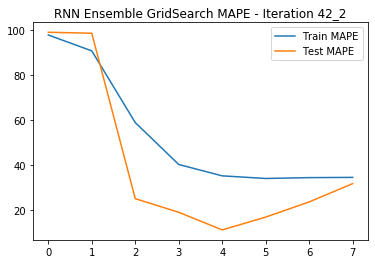

Epoch 1/40
69/69 [==============================] - 12s 171ms/step - loss: 10436079616.0000 - mean_absolute_percentage_error: 101.3617 - val_loss: 8328850432.0000 - val_mean_absolute_percentage_error: 99.9231
Epoch 2/40
69/69 [==============================] - 12s 167ms/step - loss: 5324802048.0000 - mean_absolute_percentage_error: 73.2764 - val_loss: 1976523648.0000 - val_mean_absolute_percentage_error: 45.5270
Epoch 3/40
69/69 [==============================] - 11s 166ms/step - loss: 2865507328.0000 - mean_absolute_percentage_error: 49.8372 - val_loss: 3716162560.0000 - val_mean_absolute_percentage_error: 65.4811
Epoch 4/40
69/69 [==============================] - 11s 166ms/step - loss: 2215477760.0000 - mean_absolute_percentage_error: 43.3788 - val_loss: 3345191680.0000 - val_mean_absolute_percentage_error: 61.9509
Epoch 5/40
69/69 [==============================] - 11s 166ms/step - loss: 1888754432.0000 - mean_absolute_percentage_error: 39.0844 - val_loss: 2653222144.0000 - val_mea

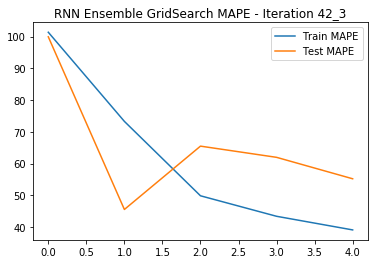

Epoch 1/40
69/69 [==============================] - 12s 168ms/step - loss: 6746798080.0000 - mean_absolute_percentage_error: 84.0877 - val_loss: 8011252224.0000 - val_mean_absolute_percentage_error: 97.8632
Epoch 2/40
69/69 [==============================] - 11s 163ms/step - loss: 8464003584.0000 - mean_absolute_percentage_error: 94.8560 - val_loss: 8340959744.0000 - val_mean_absolute_percentage_error: 99.9980
Epoch 3/40
69/69 [==============================] - 11s 163ms/step - loss: 9414157312.0000 - mean_absolute_percentage_error: 99.6906 - val_loss: 8336208896.0000 - val_mean_absolute_percentage_error: 99.9679
Epoch 4/40
69/69 [==============================] - 11s 163ms/step - loss: 7285811200.0000 - mean_absolute_percentage_error: 89.6742 - val_loss: 4106077184.0000 - val_mean_absolute_percentage_error: 67.6072
Epoch 5/40
69/69 [==============================] - 11s 162ms/step - loss: 2918491904.0000 - mean_absolute_percentage_error: 50.4093 - val_loss: 3278663168.0000 - val_mean_

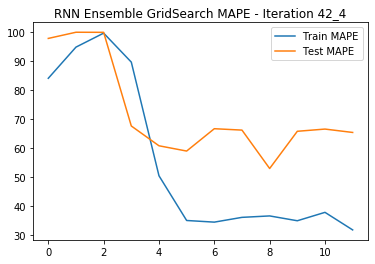

seq_length              24.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.40
stop_patience            3.00
learning_rate            0.01
epochs                  80.00
Name: 43, dtype: float64
Epoch 1/80
69/69 [==============================] - 12s 170ms/step - loss: 9167394816.0000 - mean_absolute_percentage_error: 95.1871 - val_loss: 8009808896.0000 - val_mean_absolute_percentage_error: 97.8629
Epoch 2/80
69/69 [==============================] - 11s 164ms/step - loss: 4400830464.0000 - mean_absolute_percentage_error: 63.5117 - val_loss: 4026019840.0000 - val_mean_absolute_percentage_error: 68.3485
Epoch 3/80
69/69 [==============================] - 11s 164ms/step - loss: 2834669568.0000 - mean_absolute_percentage_error: 48.9605 - val_loss: 2293890560.0000 - val_mean_absolute_percentage_error: 50.5063
Epoch 4/80
69/69 [==============================] - 11

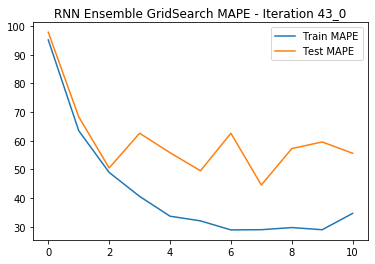

Epoch 1/80
69/69 [==============================] - 11s 166ms/step - loss: 8997607424.0000 - mean_absolute_percentage_error: 97.5483 - val_loss: 1928443136.0000 - val_mean_absolute_percentage_error: 39.8940
Epoch 2/80
69/69 [==============================] - 11s 161ms/step - loss: 3165018880.0000 - mean_absolute_percentage_error: 52.5377 - val_loss: 2998605312.0000 - val_mean_absolute_percentage_error: 57.7425
Epoch 3/80
69/69 [==============================] - 11s 161ms/step - loss: 1596929664.0000 - mean_absolute_percentage_error: 35.9813 - val_loss: 1099603840.0000 - val_mean_absolute_percentage_error: 32.9492
Epoch 4/80
69/69 [==============================] - 11s 161ms/step - loss: 1124816896.0000 - mean_absolute_percentage_error: 29.6503 - val_loss: 126344912.0000 - val_mean_absolute_percentage_error: 9.3818
Epoch 5/80
69/69 [==============================] - 11s 161ms/step - loss: 1083272064.0000 - mean_absolute_percentage_error: 29.0733 - val_loss: 1923716864.0000 - val_mean_ab

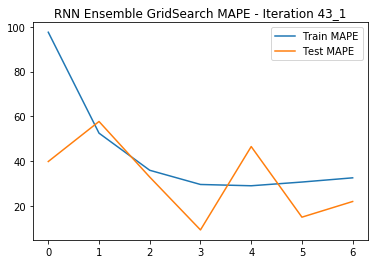

Epoch 1/80
69/69 [==============================] - 11s 164ms/step - loss: 8727592960.0000 - mean_absolute_percentage_error: 97.7520 - val_loss: 8176857600.0000 - val_mean_absolute_percentage_error: 98.9690
Epoch 2/80
69/69 [==============================] - 11s 158ms/step - loss: 7352282624.0000 - mean_absolute_percentage_error: 90.7019 - val_loss: 8110709248.0000 - val_mean_absolute_percentage_error: 98.5253
Epoch 3/80
69/69 [==============================] - 11s 158ms/step - loss: 3951264512.0000 - mean_absolute_percentage_error: 58.8833 - val_loss: 777658432.0000 - val_mean_absolute_percentage_error: 25.1098
Epoch 4/80
69/69 [==============================] - 11s 158ms/step - loss: 1994901504.0000 - mean_absolute_percentage_error: 40.2824 - val_loss: 447190816.0000 - val_mean_absolute_percentage_error: 19.0751
Epoch 5/80
69/69 [==============================] - 11s 158ms/step - loss: 1570825856.0000 - mean_absolute_percentage_error: 35.2380 - val_loss: 191426208.0000 - val_mean_abs

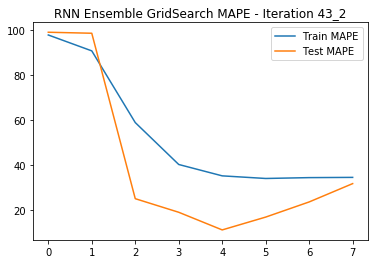

Epoch 1/80
69/69 [==============================] - 11s 160ms/step - loss: 10436079616.0000 - mean_absolute_percentage_error: 101.3617 - val_loss: 8328850432.0000 - val_mean_absolute_percentage_error: 99.9231
Epoch 2/80
69/69 [==============================] - 11s 156ms/step - loss: 5324802048.0000 - mean_absolute_percentage_error: 73.2764 - val_loss: 1976523648.0000 - val_mean_absolute_percentage_error: 45.5270
Epoch 3/80
69/69 [==============================] - 11s 155ms/step - loss: 2865507328.0000 - mean_absolute_percentage_error: 49.8372 - val_loss: 3716162560.0000 - val_mean_absolute_percentage_error: 65.4811
Epoch 4/80
69/69 [==============================] - 11s 155ms/step - loss: 2215477760.0000 - mean_absolute_percentage_error: 43.3788 - val_loss: 3345191680.0000 - val_mean_absolute_percentage_error: 61.9509
Epoch 5/80
69/69 [==============================] - 11s 155ms/step - loss: 1888754432.0000 - mean_absolute_percentage_error: 39.0844 - val_loss: 2653222144.0000 - val_mea

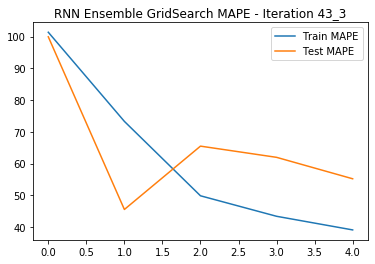

Epoch 1/80
69/69 [==============================] - 11s 158ms/step - loss: 6746798080.0000 - mean_absolute_percentage_error: 84.0877 - val_loss: 8011252224.0000 - val_mean_absolute_percentage_error: 97.8632
Epoch 2/80
69/69 [==============================] - 11s 153ms/step - loss: 8464003584.0000 - mean_absolute_percentage_error: 94.8560 - val_loss: 8340959744.0000 - val_mean_absolute_percentage_error: 99.9980
Epoch 3/80
69/69 [==============================] - 11s 153ms/step - loss: 9414157312.0000 - mean_absolute_percentage_error: 99.6906 - val_loss: 8336208896.0000 - val_mean_absolute_percentage_error: 99.9679
Epoch 4/80
69/69 [==============================] - 11s 153ms/step - loss: 7285811200.0000 - mean_absolute_percentage_error: 89.6742 - val_loss: 4106077184.0000 - val_mean_absolute_percentage_error: 67.6072
Epoch 5/80
69/69 [==============================] - 11s 153ms/step - loss: 2918491904.0000 - mean_absolute_percentage_error: 50.4093 - val_loss: 3278663168.0000 - val_mean_

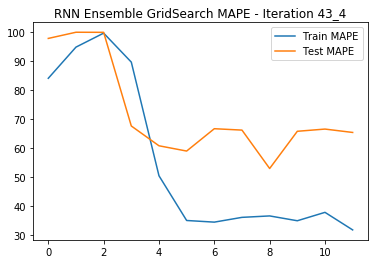

seq_length              24.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.400
stop_patience            4.000
learning_rate            0.001
epochs                  40.000
Name: 44, dtype: float64
Epoch 1/40
69/69 [==============================] - 11s 164ms/step - loss: 5348843008.0000 - mean_absolute_percentage_error: 73.1921 - val_loss: 3730720000.0000 - val_mean_absolute_percentage_error: 62.1287
Epoch 2/40
69/69 [==============================] - 11s 159ms/step - loss: 2532306176.0000 - mean_absolute_percentage_error: 46.6113 - val_loss: 929869952.0000 - val_mean_absolute_percentage_error: 29.9614
Epoch 3/40
69/69 [==============================] - 11s 158ms/step - loss: 1927502080.0000 - mean_absolute_percentage_error: 39.7439 - val_loss: 1188533504.0000 - val_mean_absolute_percentage_error: 35.4286
Epoch 4/40
69/69 [===========================

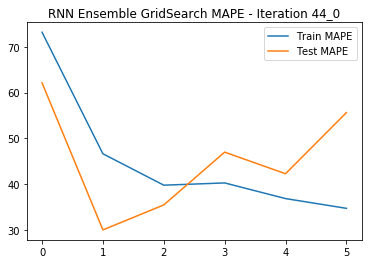

Epoch 1/40
69/69 [==============================] - 12s 173ms/step - loss: 6150977024.0000 - mean_absolute_percentage_error: 79.9090 - val_loss: 3715685632.0000 - val_mean_absolute_percentage_error: 64.7287
Epoch 2/40
69/69 [==============================] - 12s 169ms/step - loss: 2546999552.0000 - mean_absolute_percentage_error: 46.7256 - val_loss: 3145873152.0000 - val_mean_absolute_percentage_error: 60.2052
Epoch 3/40
69/69 [==============================] - 12s 168ms/step - loss: 2190260736.0000 - mean_absolute_percentage_error: 42.6724 - val_loss: 1459938176.0000 - val_mean_absolute_percentage_error: 39.4641
Epoch 4/40
69/69 [==============================] - 12s 167ms/step - loss: 1989299712.0000 - mean_absolute_percentage_error: 40.4845 - val_loss: 1657263232.0000 - val_mean_absolute_percentage_error: 42.8792
Epoch 5/40
69/69 [==============================] - 12s 168ms/step - loss: 1663827840.0000 - mean_absolute_percentage_error: 36.8788 - val_loss: 1312732928.0000 - val_mean_

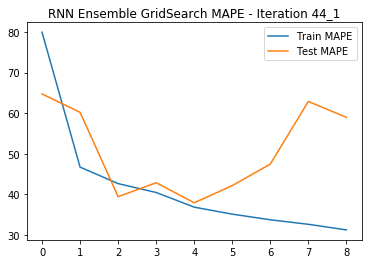

Epoch 1/40
69/69 [==============================] - 12s 169ms/step - loss: 6693743104.0000 - mean_absolute_percentage_error: 84.8450 - val_loss: 3996358144.0000 - val_mean_absolute_percentage_error: 67.3871
Epoch 2/40
69/69 [==============================] - 11s 164ms/step - loss: 2954785536.0000 - mean_absolute_percentage_error: 51.2034 - val_loss: 2014903168.0000 - val_mean_absolute_percentage_error: 46.2043
Epoch 3/40
69/69 [==============================] - 11s 163ms/step - loss: 2263532288.0000 - mean_absolute_percentage_error: 43.7358 - val_loss: 2003400576.0000 - val_mean_absolute_percentage_error: 46.9973
Epoch 4/40
69/69 [==============================] - 11s 163ms/step - loss: 1884841472.0000 - mean_absolute_percentage_error: 39.4448 - val_loss: 3565177088.0000 - val_mean_absolute_percentage_error: 64.3356
Epoch 5/40
69/69 [==============================] - 11s 163ms/step - loss: 1831530368.0000 - mean_absolute_percentage_error: 38.5479 - val_loss: 5346478080.0000 - val_mean_

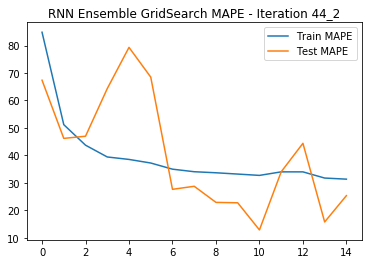

Epoch 1/40
69/69 [==============================] - 11s 165ms/step - loss: 6182541312.0000 - mean_absolute_percentage_error: 80.0316 - val_loss: 3970328832.0000 - val_mean_absolute_percentage_error: 67.7690
Epoch 2/40
69/69 [==============================] - 11s 160ms/step - loss: 2981412096.0000 - mean_absolute_percentage_error: 50.9277 - val_loss: 3162610944.0000 - val_mean_absolute_percentage_error: 60.1315
Epoch 3/40
69/69 [==============================] - 11s 160ms/step - loss: 2541086464.0000 - mean_absolute_percentage_error: 46.2748 - val_loss: 4531584512.0000 - val_mean_absolute_percentage_error: 73.1773
Epoch 4/40
69/69 [==============================] - 11s 160ms/step - loss: 2179873280.0000 - mean_absolute_percentage_error: 42.5494 - val_loss: 3805504512.0000 - val_mean_absolute_percentage_error: 66.7383
Epoch 5/40
69/69 [==============================] - 11s 159ms/step - loss: 2215186944.0000 - mean_absolute_percentage_error: 42.8820 - val_loss: 5297947648.0000 - val_mean_

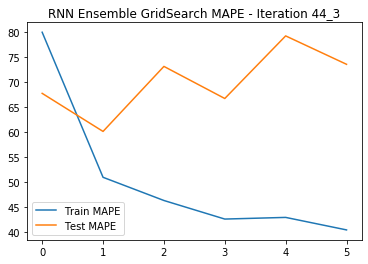

Epoch 1/40
69/69 [==============================] - 11s 162ms/step - loss: 5292266496.0000 - mean_absolute_percentage_error: 71.8080 - val_loss: 1917506176.0000 - val_mean_absolute_percentage_error: 44.5418
Epoch 2/40
69/69 [==============================] - 11s 158ms/step - loss: 2399014656.0000 - mean_absolute_percentage_error: 44.7974 - val_loss: 1339052032.0000 - val_mean_absolute_percentage_error: 37.1977
Epoch 3/40
69/69 [==============================] - 11s 158ms/step - loss: 2116994176.0000 - mean_absolute_percentage_error: 42.1180 - val_loss: 1059850560.0000 - val_mean_absolute_percentage_error: 33.1281
Epoch 4/40
69/69 [==============================] - 11s 157ms/step - loss: 1831922560.0000 - mean_absolute_percentage_error: 38.7736 - val_loss: 2071785088.0000 - val_mean_absolute_percentage_error: 47.1595
Epoch 5/40
69/69 [==============================] - 11s 159ms/step - loss: 2004661376.0000 - mean_absolute_percentage_error: 40.9731 - val_loss: 4007171072.0000 - val_mean_

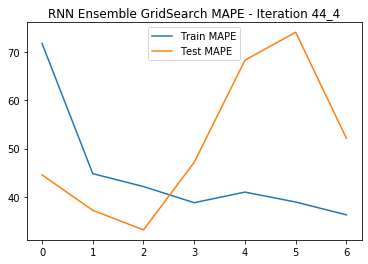

seq_length              24.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.400
stop_patience            4.000
learning_rate            0.001
epochs                  80.000
Name: 45, dtype: float64
Epoch 1/80
69/69 [==============================] - 12s 168ms/step - loss: 5348843008.0000 - mean_absolute_percentage_error: 73.1921 - val_loss: 3730720000.0000 - val_mean_absolute_percentage_error: 62.1287
Epoch 2/80
69/69 [==============================] - 11s 162ms/step - loss: 2532306176.0000 - mean_absolute_percentage_error: 46.6113 - val_loss: 929869952.0000 - val_mean_absolute_percentage_error: 29.9614
Epoch 3/80
69/69 [==============================] - 11s 162ms/step - loss: 1927502080.0000 - mean_absolute_percentage_error: 39.7439 - val_loss: 1188533504.0000 - val_mean_absolute_percentage_error: 35.4286
Epoch 4/80
69/69 [===========================

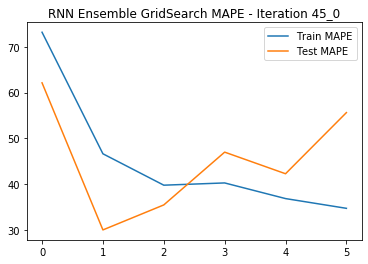

Epoch 1/80
69/69 [==============================] - 11s 165ms/step - loss: 6150977024.0000 - mean_absolute_percentage_error: 79.9090 - val_loss: 3715685632.0000 - val_mean_absolute_percentage_error: 64.7287
Epoch 2/80
69/69 [==============================] - 11s 161ms/step - loss: 2546999552.0000 - mean_absolute_percentage_error: 46.7256 - val_loss: 3145873152.0000 - val_mean_absolute_percentage_error: 60.2052
Epoch 3/80
69/69 [==============================] - 11s 160ms/step - loss: 2190260736.0000 - mean_absolute_percentage_error: 42.6724 - val_loss: 1459938176.0000 - val_mean_absolute_percentage_error: 39.4641
Epoch 4/80
69/69 [==============================] - 11s 159ms/step - loss: 1989299712.0000 - mean_absolute_percentage_error: 40.4845 - val_loss: 1657263232.0000 - val_mean_absolute_percentage_error: 42.8792
Epoch 5/80
69/69 [==============================] - 11s 159ms/step - loss: 1663827840.0000 - mean_absolute_percentage_error: 36.8788 - val_loss: 1312732928.0000 - val_mean_

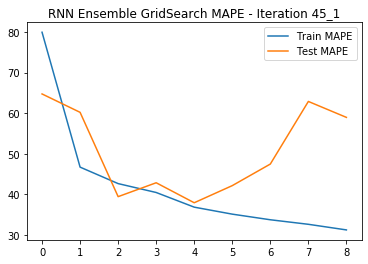

Epoch 1/80
69/69 [==============================] - 11s 166ms/step - loss: 6693743104.0000 - mean_absolute_percentage_error: 84.8450 - val_loss: 3996358144.0000 - val_mean_absolute_percentage_error: 67.3871
Epoch 2/80
69/69 [==============================] - 11s 161ms/step - loss: 2954785536.0000 - mean_absolute_percentage_error: 51.2034 - val_loss: 2014903168.0000 - val_mean_absolute_percentage_error: 46.2043
Epoch 3/80
69/69 [==============================] - 11s 161ms/step - loss: 2263532288.0000 - mean_absolute_percentage_error: 43.7358 - val_loss: 2003400576.0000 - val_mean_absolute_percentage_error: 46.9973
Epoch 4/80
69/69 [==============================] - 11s 160ms/step - loss: 1884841472.0000 - mean_absolute_percentage_error: 39.4448 - val_loss: 3565177088.0000 - val_mean_absolute_percentage_error: 64.3356
Epoch 5/80
69/69 [==============================] - 11s 160ms/step - loss: 1831530368.0000 - mean_absolute_percentage_error: 38.5479 - val_loss: 5346478080.0000 - val_mean_

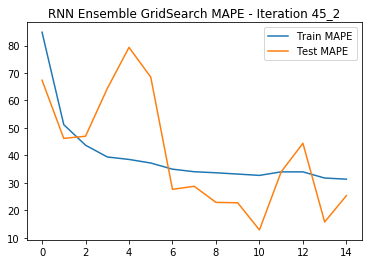

Epoch 1/80
69/69 [==============================] - 12s 168ms/step - loss: 6182541312.0000 - mean_absolute_percentage_error: 80.0316 - val_loss: 3970328832.0000 - val_mean_absolute_percentage_error: 67.7690
Epoch 2/80
69/69 [==============================] - 11s 162ms/step - loss: 2981412096.0000 - mean_absolute_percentage_error: 50.9277 - val_loss: 3162610944.0000 - val_mean_absolute_percentage_error: 60.1315
Epoch 3/80
69/69 [==============================] - 11s 162ms/step - loss: 2541086464.0000 - mean_absolute_percentage_error: 46.2748 - val_loss: 4531584512.0000 - val_mean_absolute_percentage_error: 73.1773
Epoch 4/80
69/69 [==============================] - 11s 162ms/step - loss: 2179873280.0000 - mean_absolute_percentage_error: 42.5494 - val_loss: 3805504512.0000 - val_mean_absolute_percentage_error: 66.7383
Epoch 5/80
69/69 [==============================] - 11s 161ms/step - loss: 2215186944.0000 - mean_absolute_percentage_error: 42.8820 - val_loss: 5297947648.0000 - val_mean_

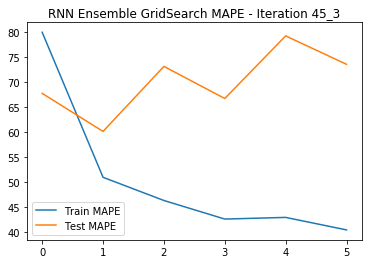

Epoch 1/80
69/69 [==============================] - 13s 184ms/step - loss: 5292266496.0000 - mean_absolute_percentage_error: 71.8080 - val_loss: 1917506176.0000 - val_mean_absolute_percentage_error: 44.5418
Epoch 2/80
69/69 [==============================] - 12s 179ms/step - loss: 2399014656.0000 - mean_absolute_percentage_error: 44.7974 - val_loss: 1339052032.0000 - val_mean_absolute_percentage_error: 37.1977
Epoch 3/80
69/69 [==============================] - 12s 178ms/step - loss: 2116994176.0000 - mean_absolute_percentage_error: 42.1180 - val_loss: 1059850560.0000 - val_mean_absolute_percentage_error: 33.1281
Epoch 4/80
69/69 [==============================] - 12s 179ms/step - loss: 1831922560.0000 - mean_absolute_percentage_error: 38.7736 - val_loss: 2071785088.0000 - val_mean_absolute_percentage_error: 47.1595
Epoch 5/80
69/69 [==============================] - 12s 178ms/step - loss: 2004661376.0000 - mean_absolute_percentage_error: 40.9731 - val_loss: 4007171072.0000 - val_mean_

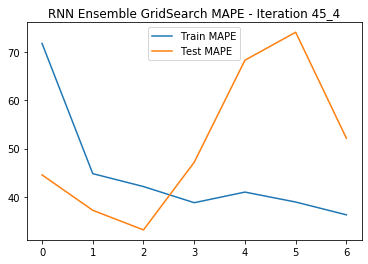

seq_length              24.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.40
stop_patience            4.00
learning_rate            0.01
epochs                  40.00
Name: 46, dtype: float64
Epoch 1/40
69/69 [==============================] - 13s 183ms/step - loss: 9167394816.0000 - mean_absolute_percentage_error: 95.1871 - val_loss: 8009808896.0000 - val_mean_absolute_percentage_error: 97.8629
Epoch 2/40
69/69 [==============================] - 12s 178ms/step - loss: 4400830464.0000 - mean_absolute_percentage_error: 63.5117 - val_loss: 4026019840.0000 - val_mean_absolute_percentage_error: 68.3485
Epoch 3/40
69/69 [==============================] - 12s 178ms/step - loss: 2834669568.0000 - mean_absolute_percentage_error: 48.9605 - val_loss: 2293890560.0000 - val_mean_absolute_percentage_error: 50.5063
Epoch 4/40
69/69 [==============================] - 12

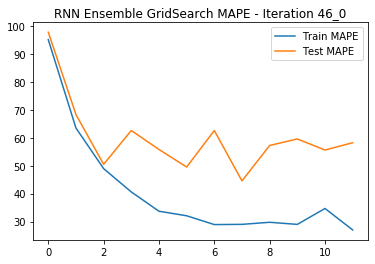

Epoch 1/40
69/69 [==============================] - 13s 181ms/step - loss: 35860320256.0000 - mean_absolute_percentage_error: 108.1881 - val_loss: 8286956544.0000 - val_mean_absolute_percentage_error: 99.6537
Epoch 2/40
69/69 [==============================] - 12s 175ms/step - loss: 7343716864.0000 - mean_absolute_percentage_error: 90.4999 - val_loss: 2865424128.0000 - val_mean_absolute_percentage_error: 55.5095
Epoch 3/40
69/69 [==============================] - 12s 175ms/step - loss: 2645401600.0000 - mean_absolute_percentage_error: 47.4526 - val_loss: 230787280.0000 - val_mean_absolute_percentage_error: 13.3858
Epoch 4/40
69/69 [==============================] - 12s 175ms/step - loss: 2486977792.0000 - mean_absolute_percentage_error: 46.2346 - val_loss: 371481600.0000 - val_mean_absolute_percentage_error: 14.8584
Epoch 5/40
69/69 [==============================] - 12s 175ms/step - loss: 1916259840.0000 - mean_absolute_percentage_error: 39.5178 - val_loss: 1137930752.0000 - val_mean_

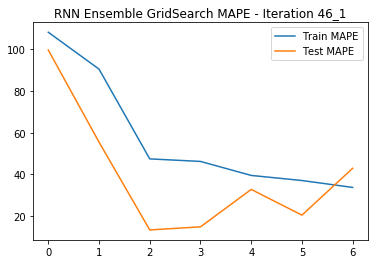

Epoch 1/40
69/69 [==============================] - 12s 178ms/step - loss: 7511026176.0000 - mean_absolute_percentage_error: 88.2660 - val_loss: 2753773568.0000 - val_mean_absolute_percentage_error: 44.8783
Epoch 2/40
69/69 [==============================] - 12s 173ms/step - loss: 169711035744256.0000 - mean_absolute_percentage_error: 1475.8737 - val_loss: 8339945472.0000 - val_mean_absolute_percentage_error: 99.9916
Epoch 3/40
69/69 [==============================] - 12s 173ms/step - loss: 8393950208.0000 - mean_absolute_percentage_error: 99.9836 - val_loss: 8340337152.0000 - val_mean_absolute_percentage_error: 99.9940
Epoch 4/40
69/69 [==============================] - 12s 173ms/step - loss: 6959174144.0000 - mean_absolute_percentage_error: 87.6079 - val_loss: 4107175168.0000 - val_mean_absolute_percentage_error: 67.4486
Epoch 5/40
69/69 [==============================] - 12s 173ms/step - loss: 2040495079424.0000 - mean_absolute_percentage_error: 182.9258 - val_loss: 8323358208.0000 

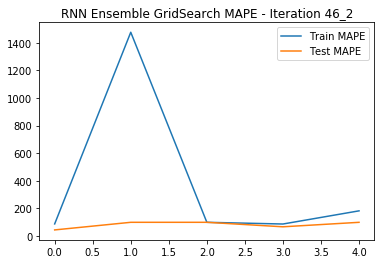

Epoch 1/40
69/69 [==============================] - 12s 176ms/step - loss: 569189269504.0000 - mean_absolute_percentage_error: 175.5576 - val_loss: 5175510016.0000 - val_mean_absolute_percentage_error: 76.4454
Epoch 2/40
69/69 [==============================] - 12s 171ms/step - loss: 6060369920.0000 - mean_absolute_percentage_error: 78.3810 - val_loss: 1425732352.0000 - val_mean_absolute_percentage_error: 34.2259
Epoch 3/40
69/69 [==============================] - 12s 170ms/step - loss: 4020791040.0000 - mean_absolute_percentage_error: 60.4953 - val_loss: 2964355072.0000 - val_mean_absolute_percentage_error: 57.1548
Epoch 4/40
69/69 [==============================] - 12s 171ms/step - loss: 1952829184.0000 - mean_absolute_percentage_error: 39.8497 - val_loss: 2435539200.0000 - val_mean_absolute_percentage_error: 51.6292
Epoch 5/40
69/69 [==============================] - 12s 170ms/step - loss: 1669001216.0000 - mean_absolute_percentage_error: 36.6161 - val_loss: 2432345600.0000 - val_me

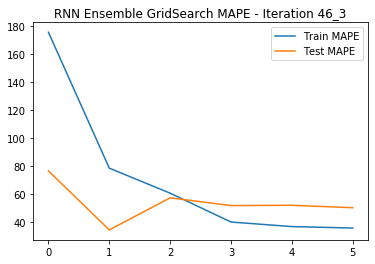

Epoch 1/40
69/69 [==============================] - 12s 173ms/step - loss: 49825918976.0000 - mean_absolute_percentage_error: 118.8134 - val_loss: 8331651072.0000 - val_mean_absolute_percentage_error: 99.9392
Epoch 2/40
69/69 [==============================] - 11s 167ms/step - loss: 10715955200.0000 - mean_absolute_percentage_error: 94.8117 - val_loss: 6625238016.0000 - val_mean_absolute_percentage_error: 88.7796
Epoch 3/40
69/69 [==============================] - 11s 166ms/step - loss: 102348055642112.0000 - mean_absolute_percentage_error: 467.3445 - val_loss: 8342012416.0000 - val_mean_absolute_percentage_error: 100.0048
Epoch 4/40
69/69 [==============================] - 11s 166ms/step - loss: 8388971520.0000 - mean_absolute_percentage_error: 99.9554 - val_loss: 8333719552.0000 - val_mean_absolute_percentage_error: 99.9508
Epoch 5/40
69/69 [==============================] - 11s 166ms/step - loss: 823470850048.0000 - mean_absolute_percentage_error: 172.6005 - val_loss: 8341243392.000

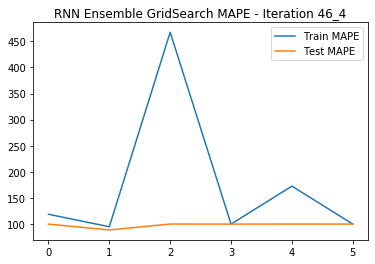

seq_length              24.00
seq_batch_size         256.00
layer_one_neurons      128.00
layer_two_neurons       32.00
layer_three_neurons     16.00
layer_four_neurons      16.00
dropout_rate             0.40
stop_patience            4.00
learning_rate            0.01
epochs                  80.00
Name: 47, dtype: float64
Epoch 1/80
69/69 [==============================] - 12s 173ms/step - loss: 9167394816.0000 - mean_absolute_percentage_error: 95.1871 - val_loss: 8009808896.0000 - val_mean_absolute_percentage_error: 97.8629
Epoch 2/80
69/69 [==============================] - 12s 168ms/step - loss: 4400830464.0000 - mean_absolute_percentage_error: 63.5117 - val_loss: 4026019840.0000 - val_mean_absolute_percentage_error: 68.3485
Epoch 3/80
69/69 [==============================] - 12s 167ms/step - loss: 2834669568.0000 - mean_absolute_percentage_error: 48.9605 - val_loss: 2293890560.0000 - val_mean_absolute_percentage_error: 50.5063
Epoch 4/80
69/69 [==============================] - 12

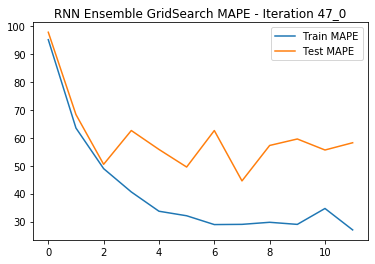

Epoch 1/80
69/69 [==============================] - 12s 168ms/step - loss: 35860320256.0000 - mean_absolute_percentage_error: 108.1881 - val_loss: 8286956544.0000 - val_mean_absolute_percentage_error: 99.6537
Epoch 2/80
69/69 [==============================] - 11s 162ms/step - loss: 7343716864.0000 - mean_absolute_percentage_error: 90.4999 - val_loss: 2865424128.0000 - val_mean_absolute_percentage_error: 55.5095
Epoch 3/80
69/69 [==============================] - 11s 162ms/step - loss: 2645401600.0000 - mean_absolute_percentage_error: 47.4526 - val_loss: 230787280.0000 - val_mean_absolute_percentage_error: 13.3858
Epoch 4/80
69/69 [==============================] - 11s 162ms/step - loss: 2486977792.0000 - mean_absolute_percentage_error: 46.2346 - val_loss: 371481600.0000 - val_mean_absolute_percentage_error: 14.8584
Epoch 5/80
69/69 [==============================] - 11s 162ms/step - loss: 1916259840.0000 - mean_absolute_percentage_error: 39.5178 - val_loss: 1137930752.0000 - val_mean_

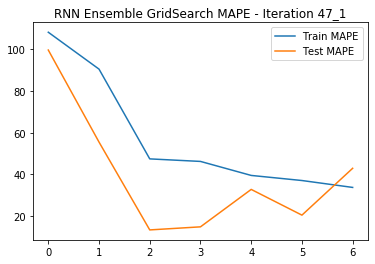

Epoch 1/80
69/69 [==============================] - 13s 181ms/step - loss: 7511026176.0000 - mean_absolute_percentage_error: 88.2660 - val_loss: 2753773568.0000 - val_mean_absolute_percentage_error: 44.8783
Epoch 2/80
69/69 [==============================] - 12s 175ms/step - loss: 169711035744256.0000 - mean_absolute_percentage_error: 1475.8737 - val_loss: 8339945472.0000 - val_mean_absolute_percentage_error: 99.9916
Epoch 3/80
69/69 [==============================] - 12s 175ms/step - loss: 8393950208.0000 - mean_absolute_percentage_error: 99.9836 - val_loss: 8340337152.0000 - val_mean_absolute_percentage_error: 99.9940
Epoch 4/80
69/69 [==============================] - 12s 175ms/step - loss: 6959174144.0000 - mean_absolute_percentage_error: 87.6079 - val_loss: 4107175168.0000 - val_mean_absolute_percentage_error: 67.4486
Epoch 5/80
69/69 [==============================] - 12s 176ms/step - loss: 2040495079424.0000 - mean_absolute_percentage_error: 182.9258 - val_loss: 8323358208.0000 

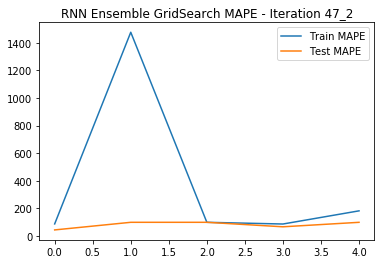

Epoch 1/80
69/69 [==============================] - 12s 178ms/step - loss: 569189269504.0000 - mean_absolute_percentage_error: 175.5576 - val_loss: 5175510016.0000 - val_mean_absolute_percentage_error: 76.4454
Epoch 2/80
69/69 [==============================] - 12s 172ms/step - loss: 6060369920.0000 - mean_absolute_percentage_error: 78.3810 - val_loss: 1425732352.0000 - val_mean_absolute_percentage_error: 34.2259
Epoch 3/80
69/69 [==============================] - 12s 172ms/step - loss: 4020791040.0000 - mean_absolute_percentage_error: 60.4953 - val_loss: 2964355072.0000 - val_mean_absolute_percentage_error: 57.1548
Epoch 4/80
69/69 [==============================] - 12s 173ms/step - loss: 1952829184.0000 - mean_absolute_percentage_error: 39.8497 - val_loss: 2435539200.0000 - val_mean_absolute_percentage_error: 51.6292
Epoch 5/80
69/69 [==============================] - 12s 172ms/step - loss: 1669001216.0000 - mean_absolute_percentage_error: 36.6161 - val_loss: 2432345600.0000 - val_me

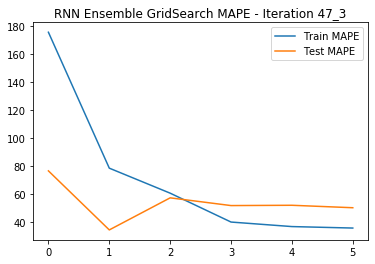

Epoch 1/80
69/69 [==============================] - 12s 175ms/step - loss: 49825918976.0000 - mean_absolute_percentage_error: 118.8134 - val_loss: 8331651072.0000 - val_mean_absolute_percentage_error: 99.9392
Epoch 2/80
69/69 [==============================] - 12s 170ms/step - loss: 10715955200.0000 - mean_absolute_percentage_error: 94.8117 - val_loss: 6625238016.0000 - val_mean_absolute_percentage_error: 88.7796
Epoch 3/80
69/69 [==============================] - 12s 170ms/step - loss: 102348055642112.0000 - mean_absolute_percentage_error: 467.3445 - val_loss: 8342012416.0000 - val_mean_absolute_percentage_error: 100.0048
Epoch 4/80
69/69 [==============================] - 12s 170ms/step - loss: 8388971520.0000 - mean_absolute_percentage_error: 99.9554 - val_loss: 8333719552.0000 - val_mean_absolute_percentage_error: 99.9508
Epoch 5/80
69/69 [==============================] - 12s 170ms/step - loss: 823470850048.0000 - mean_absolute_percentage_error: 172.6005 - val_loss: 8341243392.000

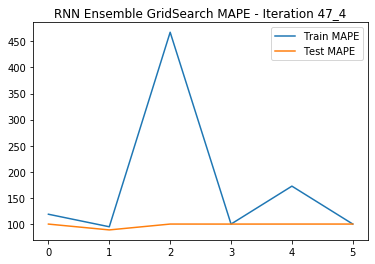

RNN grid search completed in 16420.73 seconds


In [53]:
print("\nBuilding and training models...")
tic = timeit.default_timer()

# Create output dataframes for ensemble predictions
df_ensemble_train = y_train.copy()
df_ensemble_test = y_test.copy()

# Loop through all interactions of parameters from above
for i in df_params.index:
    print(df_params.iloc[i,:-4])
    
    # Set random seed
    random.seed(238)
    set_seed(238)
    
    # Create output dataframes for individual predictions
    df_preds_train = pd.DataFrame()
    df_preds_test = pd.DataFrame()
    
    for x in range(5):
        # Create training sequences
        train_sequences = TimeseriesGenerator(X_train_ss, y_train['value'],
                                              length = df_params['seq_length'][i],
                                              batch_size = df_params['seq_batch_size'][i])

        # Create test sequences
        test_sequences = TimeseriesGenerator(X_test_ss, y_test['value']
                                             , length = df_params['seq_length'][i]
                                             , batch_size = df_params['seq_batch_size'][i])

        ##### RNN MODEL #####
        # Instantiate model and construct all layers
        model = Sequential()
        model.add(GRU(df_params['layer_one_neurons'][i], input_shape = (df_params['seq_length'][i],75),
                      return_sequences = True, activation = 'relu', ))
        model.add(Dropout(df_params['dropout_rate'][i]))
        model.add(GRU(df_params['layer_two_neurons'][i], return_sequences = True, activation = 'relu'))
        model.add(Dropout(df_params['dropout_rate'][i]))
        model.add(GRU(df_params['layer_three_neurons'][i], return_sequences = True, activation = 'relu'))
        model.add(Dropout(df_params['dropout_rate'][i]))
        model.add(GRU(df_params['layer_four_neurons'][i], return_sequences = False, activation = 'relu'))
        model.add(Dropout(df_params['dropout_rate'][i]))
        model.add(Dense(1, activation = 'linear'))

        # Compile and fit model
        model.compile(optimizer = Adam(learning_rate = df_params['learning_rate'][i]),
                      loss = 'mean_squared_error',
                      metrics = 'mean_absolute_percentage_error')

        early_stop = EarlyStopping(monitor='val_loss', min_delta=0,
                                   patience=df_params['stop_patience'][i],
                                   verbose=1, mode='auto')

        history = model.fit(train_sequences,
                            validation_data = test_sequences,
                            epochs = df_params['epochs'][i],
                            callbacks = [early_stop])

        # Write predictions to dataframe, adding nulls equal to lag
        df_preds_train[x] = np.append([np.NaN] * df_params['seq_length'][i], model.predict(train_sequences).transpose())
        df_preds_test[x] = np.append([np.NaN] * df_params['seq_length'][i], model.predict(test_sequences).transpose())
        
        # Plot MAPE by epoch
        plt.plot(history.history['mean_absolute_percentage_error'], label = 'Train MAPE')
        plt.plot(history.history['val_mean_absolute_percentage_error'], label = 'Test MAPE')
        plt.title('RNN Ensemble GridSearch MAPE - Iteration %s_%s' % (i,x))
        plt.legend()
        plt.savefig('../Charts/RNN Ensemble GridSearch MAPE - Iteration %s_%s.png' % (i,x))
        plt.show();
        
    # Create ensemble prediction and add to final output dataframes
    # NOTE: This would be a good spot for future improvement by creating weighting for the ensemble models
    df_ensemble_train[i] = df_preds_train.mean(axis=1).tolist()
    df_ensemble_test[i] = df_preds_test.mean(axis=1).tolist()
    
    # Create mask to exclude all records with null values for the give dataset
    mask_train = (df_ensemble_train[i].notna())
    mask_test = (df_ensemble_test[i].notna())
    
    # Add model performance results to parameters dataframe
    df_params.at[i,'mse_train'] = mean_squared_error(df_ensemble_train.loc[mask_train,'value'],
                                                     df_ensemble_train.loc[mask_train,i])
    df_params.at[i,'mse_test'] = mean_squared_error(df_ensemble_test.loc[mask_test,'value'],
                                                    df_ensemble_test.loc[mask_test,i])
    df_params.at[i,'mape_train'] = mape(df_ensemble_train.loc[mask_train,'value'],
                                        df_ensemble_train.loc[mask_train,i])
    df_params.at[i,'mape_test'] = mape(df_ensemble_test.loc[mask_test,'value'],
                                       df_ensemble_test.loc[mask_test,i])
        

toc = timeit.default_timer()
print('RNN grid search completed in %0.2f seconds' % (toc-tic))

In [60]:
# Write outputs and scores to csv
df_ensemble_train.to_csv('../Outputs/RNN_targeted_gridsearch_training_output.csv')
df_ensemble_test.to_csv('../Outputs/RNN_targeted_gridsearch_testing_output.csv')
df_params.to_csv('../Outputs/RNN_targeted_gridsearch_scores.csv')

### Investigate Model Results

''

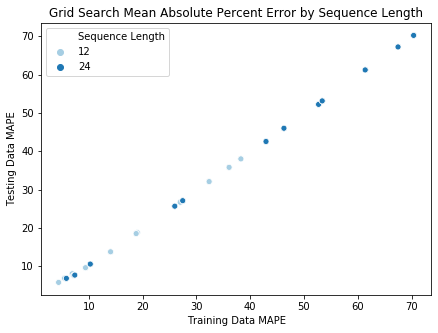

In [61]:
plt.figure(figsize = (7,5))
scatter_seq = sns.scatterplot(df_params['mape_train'],
                              df_params['mape_test'],
                              hue = df_params['seq_length'],
                              palette = 'Paired')

# Legend title fix from:
# https://stackoverflow.com/questions/51579215/remove-seaborn-lineplot-legend-title
scatter_seq.legend().texts[0].set_text("Sequence Length")
plt.title('Grid Search Mean Absolute Percent Error by Sequence Length')
plt.xlabel('Training Data MAPE')
plt.ylabel('Testing Data MAPE')
;

''

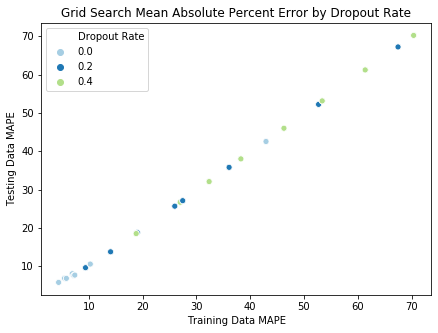

In [106]:
plt.figure(figsize = (7,5))
scatter_seq = sns.scatterplot(df_params['mape_train'],
                              df_params['mape_test'],
                              hue = df_params['dropout_rate'],
                              palette = 'Paired')

# Legend title fix from:
# https://stackoverflow.com/questions/51579215/remove-seaborn-lineplot-legend-title
scatter_seq.legend().texts[0].set_text("Dropout Rate")
plt.title('Grid Search Mean Absolute Percent Error by Dropout Rate')
plt.xlabel('Training Data MAPE')
plt.ylabel('Testing Data MAPE')
plt.savefig('../Charts/RNN Ensemble GridSearch MAPE by Dropout Rate.png')
;

''

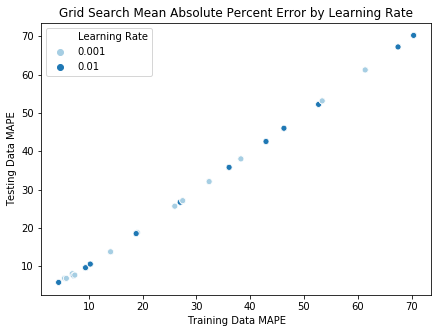

In [107]:
plt.figure(figsize = (7,5))
scatter_seq = sns.scatterplot(df_params['mape_train'],
                              df_params['mape_test'],
                              hue = df_params['learning_rate'],
                              palette = 'Paired')

# Legend title fix from:
# https://stackoverflow.com/questions/51579215/remove-seaborn-lineplot-legend-title
scatter_seq.legend().texts[0].set_text("Learning Rate")
plt.title('Grid Search Mean Absolute Percent Error by Learning Rate')
plt.xlabel('Training Data MAPE')
plt.ylabel('Testing Data MAPE')
plt.savefig('../Charts/RNN Ensemble GridSearch MAPE by Learning Rate.png')
;

In [63]:
# Pull top results for consideration in final model runs
df_params.sort_values('mse_test').head(5)

seq_length  seq_batch_size  layer_one_neurons  layer_two_neurons  \
7           12             256                128                 32   
6           12             256                128                 32   
4           12             256                128                 32   
5           12             256                128                 32   
25          24             256                128                 32   

    layer_three_neurons  layer_four_neurons  dropout_rate  stop_patience  \
7                    16                  16           0.0              4   
6                    16                  16           0.0              4   
4                    16                  16           0.0              4   
5                    16                  16           0.0              4   
25                   16                  16           0.0              3   

    learning_rate  epochs     mse_train      mse_test  mape_train  mape_test  
7           0.010      80  3.212587e+07  5.073526e+07    4.410470   5.758390  
6           0.010      40  3.212587e+07  5.073526e+07    4.410470   5.758390  
4           0.001      40  3.978244e+07  5.952368e+07    5.518663   6.857170  
5           0.001      80  3.978244e+07  5.952368e+07    5.518663   6.857170  
25          0.001      80  5.445604e+07  7.064618e+07    5.847888   6.814226

In [67]:
# Combine training and testing datasets
df_combined = df_ensemble_train.append(df_ensemble_test)

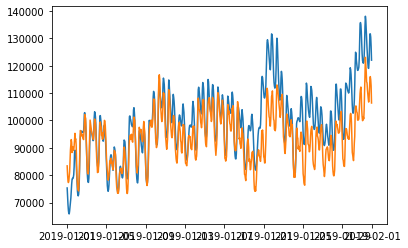

In [79]:
# Plot first month of testing dataset
plt.plot(df_combined['2019-1'][['value',7]])

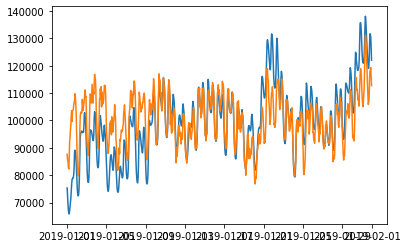

In [93]:
# Plot first month of testing dataset
plt.plot(df_combined['2019-1'][['value',4]])

In [104]:
# Cut testing prediction dataframe to only the first week of results
df_first_week_test = df_ensemble_test[df_ensemble_test.index < '2019-1-8'].dropna().copy()

# Add column to parameters dataframe first first-week MAPE
df_params['mape_test_first_week'] = np.nan

# Loop through all iterations and print the testing MAPE for the first week
print('First Week MAPE:')
for i in df_first_week_test.drop(columns = 'value').columns:
    col_mape = mape(df_first_week_test['value'], df_first_week_test[i])
    df_params.at[i,'mape_test_first_week'] = col_mape
    print('Iteration %s: %s' % (i, round(col_mape,2)))

First Week MAPE:
Iteration 0: 14.86
Iteration 1: 14.86
Iteration 2: 4.62
Iteration 3: 4.62
Iteration 4: 14.98
Iteration 5: 14.98
Iteration 6: 4.34
Iteration 7: 4.34
Iteration 8: 12.73
Iteration 9: 12.73
Iteration 10: 7.64
Iteration 11: 7.64
Iteration 12: 6.38
Iteration 13: 6.38
Iteration 14: 35.28
Iteration 15: 35.28
Iteration 16: 26.19
Iteration 17: 26.19
Iteration 18: 17.08
Iteration 19: 17.08
Iteration 20: 32.3
Iteration 21: 32.3
Iteration 22: 24.96
Iteration 23: 24.96
Iteration 24: 5.71
Iteration 25: 5.71
Iteration 26: 9.92
Iteration 27: 9.92
Iteration 28: 5.81
Iteration 29: 5.81
Iteration 30: 38.52
Iteration 31: 38.52
Iteration 32: 19.02
Iteration 33: 19.02
Iteration 34: 45.91
Iteration 35: 45.91
Iteration 36: 21.4
Iteration 37: 21.4
Iteration 38: 65.72
Iteration 39: 65.72
Iteration 40: 59.48
Iteration 41: 59.48
Iteration 42: 45.78
Iteration 43: 45.78
Iteration 44: 47.99
Iteration 45: 47.99
Iteration 46: 69.56
Iteration 47: 69.56


''

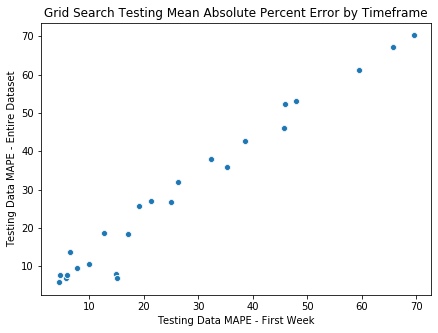

In [108]:
plt.figure(figsize = (7,5))
scatter_seq = sns.scatterplot(df_params['mape_test_first_week'],
                              df_params['mape_test'])
plt.title('Grid Search Testing Mean Absolute Percent Error by Timeframe')
plt.xlabel('Testing Data MAPE - First Week')
plt.ylabel('Testing Data MAPE - Entire Dataset')
plt.savefig('../Charts/RNN Ensemble GridSearch Testing MAPE by Timeframe.png')
;

In [ ]:
# Rewrite parameters dataframe to csv with updated score
df_params.to_csv('../Outputs/RNN_targeted_gridsearch_scores.csv')

Analysis of MAPE scores for each iteration's first week illustrates that these scores vary significantly from the scores for the entire dataset. Given that the near-term accuracy and backcasting accuracy are more pertinent to our interests, this score should be prioritized, however the highest-scoring model ultimately remains consistent between both metrics.